In [40]:
import xgboost as xgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import uproot3 as uproot
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
import scipy.optimize
from scipy.linalg import cholesky
from sklearn.metrics import r2_score
from numpy.linalg import inv
from numpy.linalg import pinv



from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

print(xgb.__version__)
print(uproot.__version__)
print(pd.__version__)

1.5.1
3.14.4
1.1.5


In [41]:
#which of these can all be true at once?
open_data = False
all_data = True
run1_to_3_pred_only = False
open_data_new_file = False
numi_data = False #need rest of data?
fake_data_5 = False
fake_data_7 = False

In [42]:
#Ben: Defining the variables we want into groups
extra_variables = [
    "run",
    "subrun",
    "event",
    "nuvtx_diff",
    "showervtx_diff",
    "muonvtx_diff",
    "truth_isCC",
    "truth_vtxInside",
    "truth_nuPdg",
    "truth_nuEnergy",
    "truth_nuIntType",
    "truth_energyInside",
    "weight_spline",
    "weight_cv",
    "weight_lee",
    "event_type",
    "weight",
    "lowEweight"
]

numu_bdt_score_variables = [
    "cosmict_10_score",
    "numu_1_score",
    "numu_2_score"
]

nue_bdt_score_variables = [
    "tro_5_score",
    "tro_4_score",
    "tro_2_score",
    "tro_1_score",
    "stw_4_score",
    "stw_3_score",
    "stw_2_score",
    "sig_2_score",
    "sig_1_score",
    "pio_2_score",
    "lol_2_score",
    "lol_1_score",
    "br3_6_score",
    "br3_5_score",
    "br3_3_score"
]

kine_scalar_vars = [
    "kine_reco_add_energy",
    "kine_pio_mass",
    "kine_pio_flag",
    "kine_pio_vtx_dis",
    "kine_pio_energy_1",
    "kine_pio_theta_1",
    "kine_pio_phi_1",
    "kine_pio_dis_1",
    "kine_pio_energy_2",
    "kine_pio_theta_2",
    "kine_pio_phi_2",
    "kine_pio_dis_2",
    "kine_pio_angle"
]

kine_vector_vars = [
    "kine_energy_particle",
    "kine_energy_info",
    "kine_particle_type",
    "kine_energy_included",
]

In [43]:
bdt_vars = [
    "nc_delta_score",
    "nc_delta_ntrack_score",
    "nc_delta_0track_score",
    "mip_energy",
    "mip_angle_beam", 
    "spt_angle_vertical",
    "nue_score", 
    "numu_score", 
    "nc_pio_score",
    "numu_cc_flag"
]

shower_dQ_dx_vars = ['mip_vec_dQ_dx_0', 'mip_vec_dQ_dx_1', 'mip_vec_dQ_dx_2', 'mip_vec_dQ_dx_3', 'mip_vec_dQ_dx_4', 'mip_vec_dQ_dx_5', 'mip_vec_dQ_dx_6', 'mip_vec_dQ_dx_7','mip_vec_dQ_dx_8', 'mip_vec_dQ_dx_9', 'mip_vec_dQ_dx_10', 'mip_vec_dQ_dx_11','mip_vec_dQ_dx_12', 'mip_vec_dQ_dx_13', 'mip_vec_dQ_dx_14', 'mip_vec_dQ_dx_15','mip_vec_dQ_dx_16', 'mip_vec_dQ_dx_17', 'mip_vec_dQ_dx_18', 'mip_vec_dQ_dx_19']

bdt_vars += shower_dQ_dx_vars

eval_mc_variables = [
    "run",
    "subrun",
    "event",
    "flash_time",
    "weight_spline", # this and remaining only make sense for MC
    "weight_cv",
    "match_completeness_energy",
    "truth_nuEnergy",
    "truth_energyInside",
    "truth_electronInside",
    "truth_nuPdg",
    "truth_isCC",
    "truth_isFC",
    "truth_vtxInside",
    "truth_vtxX",
    "truth_vtxY",
    "truth_vtxZ",
    "truth_nuTime",
    "flash_measPe",
    "flash_predPe",
]

eval_data_variables = [
    "run",
    "subrun",
    "event",
    "flash_time",
    "flash_measPe",
    "flash_predPe",
]

if not numi_data: # numi files don't have reco_protonMomentum

    pf_eval_mc_variables = [
        "truth_NprimPio",
        "truth_NCDelta",
        "nuvtx_diff",
        "showervtx_diff",
        "reco_showerKE",
        "truth_pio_energy_1",
        "truth_pio_energy_2",
        "truth_pio_angle",
        "reco_nuvtxX",
        "reco_nuvtxY",
        "reco_nuvtxZ",
        "reco_showervtxX",
        "reco_showervtxY",
        "reco_showervtxZ",
        "reco_protonMomentum",
        "truth_nuIntType",
        "reco_Nproton"
        #"reco_showerMomentum"
    ]

    pf_eval_data_variables = [ # also use these for dirt
            "reco_showerKE",
            "reco_nuvtxX",
            "reco_nuvtxY",
            "reco_nuvtxZ",
            "reco_showervtxX",
            "reco_showervtxY",
            "reco_showervtxZ",
            "reco_protonMomentum", # Not in numi data file
            #"reco_showerMomentum", # Not in the data file from processed_checkout_rootfiles, I think Wenqiang is currently separating it from the 7e20.
            #For now just use mip_angle_beam and spt_angle_vertical
            #"reco_Nproton"
    ]
else:
    pf_eval_mc_variables = [
        "truth_NprimPio",
        "truth_NCDelta",
        "nuvtx_diff",
        "showervtx_diff",
        "reco_showerKE",
        "truth_pio_energy_1",
        "truth_pio_energy_2",
        "truth_pio_angle",
        "reco_nuvtxX",
        "reco_nuvtxY",
        "reco_nuvtxZ",
        "reco_showervtxX",
        "reco_showervtxY",
        "reco_showervtxZ",
        "reco_showerMomentum",
        "truth_nuIntType"
    ]

    pf_eval_data_variables = [ # also use these for dirt
        "reco_showerKE",
        "reco_nuvtxX",
        "reco_nuvtxY",
        "reco_nuvtxZ",
        "reco_showervtxX",
        "reco_showervtxY",
        "reco_showervtxZ",
        "reco_showerMomentum", # Not in the data file from processed_checkout_rootfiles, even though it's in Jay's cuts.h, strange. For now just use mip_angle_beam and spt_angle_vertical
    ]
    
dedicated_pf_eval_mc_variables = [
    "truth_pdg", 
    "truth_mother", 
    "truth_startMomentum",
    "truth_endMomentum"
]
    
if open_data_new_file:
    pf_eval_mc_variables.append("reco_showerMomentum")
    pf_eval_data_variables.append("reco_showerMomentum")

In [44]:
# loading NC Delta files

f_nc_delta_run1 = uproot.open("data/checkout_prodgenie_bnb_nc_delta_overlay_run1_PF.root")["wcpselection"]
f_nc_delta_run1_bdt = f_nc_delta_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nc_delta_run1_eval = f_nc_delta_run1["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nc_delta_run1_pfeval = f_nc_delta_run1["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_nc_delta_run1_kine = f_nc_delta_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nc_delta_run1_pot = f_nc_delta_run1["T_pot"].pandas.df(["subRunNo", "pot_tor875good"], flatten=False).query(
    "subRunNo % 2 == 1") # EXCLUDING TRAINING EVENTS FOR POT COUNTING
nc_delta_run1_file_POT = np.sum(f_nc_delta_run1_pot["pot_tor875good"].to_numpy())
nc_delta_run1_df = pd.concat([f_nc_delta_run1_bdt, f_nc_delta_run1_eval, f_nc_delta_run1_pfeval, f_nc_delta_run1_kine], axis=1, sort=False).query(
    "subrun%2==1 and kine_reco_Enu >= 0 and match_isFC==1") # EXCLUDING TRAINING EVENTS  
del f_nc_delta_run1
del f_nc_delta_run1_bdt
del f_nc_delta_run1_eval
del f_nc_delta_run1_pfeval
del f_nc_delta_run1_kine
del f_nc_delta_run1_pot
nc_delta_run1_df["isEXT"] = [0 for i in range(nc_delta_run1_df.shape[0])]
nc_delta_run1_df["isDirt"] = [0 for i in range(nc_delta_run1_df.shape[0])]
nc_delta_run1_df["WC_file"] = ["nc_delta_run1" for i in range(nc_delta_run1_df.shape[0])]
nc_delta_run1_df["run_num"] = [1 for i in range(nc_delta_run1_df.shape[0])]

print(nc_delta_run1_file_POT)
print(nc_delta_run1_df.shape[0])

f_nc_delta_run2 = uproot.open("data/checkout_prodgenie_bnb_nc_delta_overlay_run2_PF.root")["wcpselection"]
f_nc_delta_run2_bdt = f_nc_delta_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nc_delta_run2_eval = f_nc_delta_run2["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nc_delta_run2_pfeval = f_nc_delta_run2["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_nc_delta_run2_kine = f_nc_delta_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nc_delta_run2_pot = f_nc_delta_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
nc_delta_run2_file_POT = np.sum(f_nc_delta_run2_pot["pot_tor875good"].to_numpy()) #same thing with .to_numpy()
nc_delta_run2_df = pd.concat([f_nc_delta_run2_bdt, f_nc_delta_run2_eval, f_nc_delta_run2_pfeval, f_nc_delta_run2_kine], axis=1, sort=False).query(
    "kine_reco_Enu >= 0 and match_isFC==1")
del f_nc_delta_run2
del f_nc_delta_run2_bdt
del f_nc_delta_run2_eval
del f_nc_delta_run2_pfeval
del f_nc_delta_run2_kine
del f_nc_delta_run2_pot
nc_delta_run2_df["isEXT"] = [0 for i in range(nc_delta_run2_df.shape[0])]
nc_delta_run2_df["isDirt"] = [0 for i in range(nc_delta_run2_df.shape[0])]
nc_delta_run2_df["WC_file"] = ["nc_delta_run2" for i in range(nc_delta_run2_df.shape[0])]
nc_delta_run2_df["run_num"] = [2 for i in range(nc_delta_run2_df.shape[0])]

print(nc_delta_run2_file_POT)
print(nc_delta_run2_df.shape[0])

f_nc_delta_run3 = uproot.open("data/checkout_prodgenie_bnb_nc_delta_overlay_run3_PF.root")["wcpselection"]
f_nc_delta_run3_bdt = f_nc_delta_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nc_delta_run3_eval = f_nc_delta_run3["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nc_delta_run3_pfeval = f_nc_delta_run3["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_nc_delta_run3_kine = f_nc_delta_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nc_delta_run3_pot = f_nc_delta_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
nc_delta_run3_file_POT = np.sum(f_nc_delta_run3_pot["pot_tor875good"].to_numpy()) # samre thing with .to_numpy()
nc_delta_run3_df = pd.concat([f_nc_delta_run3_bdt, f_nc_delta_run3_eval, f_nc_delta_run3_pfeval, f_nc_delta_run3_kine], axis=1, sort=False).query(
    "kine_reco_Enu >= 0 and match_isFC==1")
del f_nc_delta_run3
del f_nc_delta_run3_bdt
del f_nc_delta_run3_eval
del f_nc_delta_run3_pfeval
del f_nc_delta_run3_kine
del f_nc_delta_run3_pot
nc_delta_run3_df["isEXT"] = [0 for i in range(nc_delta_run3_df.shape[0])]
nc_delta_run3_df["isDirt"] = [0 for i in range(nc_delta_run3_df.shape[0])]
nc_delta_run3_df["WC_file"] = ["nc_delta_run3" for i in range(nc_delta_run3_df.shape[0])]
nc_delta_run3_df["run_num"] = [3 for i in range(nc_delta_run3_df.shape[0])]

print(nc_delta_run3_file_POT)
print(nc_delta_run3_df.shape[0])


2.157796657242789e+23
24219
4.7398996193248585e+23
52556
5.14123404156446e+23
57650


In [45]:
#combines and gets rid keeps nc delta
nc_delta_df = pd.concat([nc_delta_run1_df, nc_delta_run2_df, nc_delta_run3_df], sort=False).query("truth_isCC==0 and truth_NCDelta==1")

del nc_delta_run1_df
del nc_delta_run2_df
del nc_delta_run3_df

In [46]:
# loading NC Pi0 files
f_ncpi0_run1 = uproot.open("data/checkout_prodgenie_nc_pi0_overlay_run1_PF.root")["wcpselection"]
f_ncpi0_run1_bdt = f_ncpi0_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ncpi0_run1_eval = f_ncpi0_run1["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_ncpi0_run1_pfeval = f_ncpi0_run1["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_ncpi0_run1_kine = f_ncpi0_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ncpi0_run1_pot = f_ncpi0_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
nc_pi0_run1_file_POT = np.sum(f_ncpi0_run1_pot["pot_tor875good"].to_numpy())
nc_pi0_run1_df = pd.concat([f_ncpi0_run1_bdt, f_ncpi0_run1_eval, f_ncpi0_run1_pfeval, f_ncpi0_run1_kine], axis=1, sort=False)
del f_ncpi0_run1
del f_ncpi0_run1_bdt
del f_ncpi0_run1_eval
del f_ncpi0_run1_pfeval
del f_ncpi0_run1_kine
del f_ncpi0_run1_pot
nc_pi0_run1_df["isEXT"] = [0 for i in range(nc_pi0_run1_df.shape[0])]
nc_pi0_run1_df["isDirt"] = [0 for i in range(nc_pi0_run1_df.shape[0])]
nc_pi0_run1_df["WC_file"] = ["NC_Pi0_run1" for i in range(nc_pi0_run1_df.shape[0])]
nc_pi0_run1_df["run_num"] = [1 for i in range(nc_pi0_run1_df.shape[0])]

f_ncpi0_run2 = uproot.open("data/checkout_prodgenie_nc_pi0_overlay_run2_PF.root")["wcpselection"]
f_ncpi0_run2_bdt = f_ncpi0_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ncpi0_run2_eval = f_ncpi0_run2["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_ncpi0_run2_pfeval = f_ncpi0_run2["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_ncpi0_run2_kine = f_ncpi0_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ncpi0_run2_pot = f_ncpi0_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
nc_pi0_run2_file_POT = np.sum(f_ncpi0_run2_pot["pot_tor875good"].to_numpy())
nc_pi0_run2_df = pd.concat([f_ncpi0_run2_bdt, f_ncpi0_run2_eval, f_ncpi0_run2_pfeval, f_ncpi0_run2_kine], axis=1, sort=False)
del f_ncpi0_run2
del f_ncpi0_run2_bdt
del f_ncpi0_run2_eval
del f_ncpi0_run2_pfeval
del f_ncpi0_run2_kine
del f_ncpi0_run2_pot
nc_pi0_run2_df["isEXT"] = [0 for i in range(nc_pi0_run2_df.shape[0])]
nc_pi0_run2_df["isDirt"] = [0 for i in range(nc_pi0_run2_df.shape[0])]
nc_pi0_run2_df["WC_file"] = ["NC_Pi0_run2" for i in range(nc_pi0_run2_df.shape[0])]
nc_pi0_run2_df["run_num"] = [2 for i in range(nc_pi0_run2_df.shape[0])]


f_ncpi0_run3 = uproot.open("data/checkout_prodgenie_nc_pi0_overlay_run3_PF.root")["wcpselection"]
f_ncpi0_run3_bdt = f_ncpi0_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ncpi0_run3_eval = f_ncpi0_run3["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_ncpi0_run3_pfeval = f_ncpi0_run3["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_ncpi0_run3_kine = f_ncpi0_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ncpi0_run3_pot = f_ncpi0_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
nc_pi0_run3_file_POT = np.sum(f_ncpi0_run3_pot["pot_tor875good"].to_numpy())
nc_pi0_run3_df = pd.concat([f_ncpi0_run3_bdt, f_ncpi0_run3_eval, f_ncpi0_run3_pfeval, f_ncpi0_run3_kine], axis=1, sort=False)
del f_ncpi0_run3
del f_ncpi0_run3_bdt
del f_ncpi0_run3_eval
del f_ncpi0_run3_pfeval
del f_ncpi0_run3_kine
del f_ncpi0_run3_pot
nc_pi0_run3_df["isEXT"] = [0 for i in range(nc_pi0_run3_df.shape[0])]
nc_pi0_run3_df["isDirt"] = [0 for i in range(nc_pi0_run3_df.shape[0])]
nc_pi0_run3_df["WC_file"] = ["NC_Pi0_run3" for i in range(nc_pi0_run3_df.shape[0])]
nc_pi0_run3_df["run_num"] = [3 for i in range(nc_pi0_run3_df.shape[0])]

print(nc_pi0_run1_file_POT)
print(nc_pi0_run1_df.shape[0])

print(nc_pi0_run3_file_POT)
print(nc_pi0_run3_df.shape[0])

nc_pi0_df = pd.concat([nc_pi0_run1_df, nc_pi0_run2_df, nc_pi0_run3_df], sort=False).query("truth_isCC==0 and truth_NprimPio>0 and not (truth_NCDelta==1) and kine_reco_Enu >= 0 and match_isFC==1")

del nc_pi0_run1_df
del nc_pi0_run2_df
del nc_pi0_run3_df


1.224676151063279e+21
48005
1.2277865498371458e+21
47066


In [47]:
# nu overlay runs 1, 2, and 3

f_nu_overlay_run1 = uproot.open("data/checkout_prodgenie_bnb_nu_overlay_run1_PF.root")["wcpselection"]
f_nu_overlay_run1_bdt = f_nu_overlay_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nu_overlay_run1_eval = f_nu_overlay_run1["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nu_overlay_run1_pfeval = f_nu_overlay_run1["T_PFeval"].pandas.df(pf_eval_mc_variables+ dedicated_pf_eval_mc_variables, flatten=False)
f_nu_overlay_run1_kine = f_nu_overlay_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nu_overlay_run1_pot = f_nu_overlay_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
nu_overlay_run1_POT = np.sum(f_nu_overlay_run1_pot["pot_tor875good"].to_numpy())
nu_overlay_run1_df = pd.concat([f_nu_overlay_run1_bdt, f_nu_overlay_run1_eval, f_nu_overlay_run1_pfeval, f_nu_overlay_run1_kine], axis=1, sort=False)
del f_nu_overlay_run1
del f_nu_overlay_run1_bdt
del f_nu_overlay_run1_eval
del f_nu_overlay_run1_pfeval
del f_nu_overlay_run1_kine
del f_nu_overlay_run1_pot
nu_overlay_run1_df["isEXT"] = [0 for i in range(nu_overlay_run1_df.shape[0])]
nu_overlay_run1_df["isDirt"] = [0 for i in range(nu_overlay_run1_df.shape[0])]
nu_overlay_run1_df["WC_file"] = ["nu_overlay_run1" for i in range(nu_overlay_run1_df.shape[0])]
nu_overlay_run1_df["run_num"] = [1 for i in range(nu_overlay_run1_df.shape[0])]

f_nu_overlay_run2 = uproot.open("data/checkout_prodgenie_bnb_nu_overlay_run2_PF.root")["wcpselection"]
f_nu_overlay_run2_bdt = f_nu_overlay_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nu_overlay_run2_eval = f_nu_overlay_run2["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nu_overlay_run2_pfeval = f_nu_overlay_run2["T_PFeval"].pandas.df(pf_eval_mc_variables+ dedicated_pf_eval_mc_variables, flatten=False)
f_nu_overlay_run2_kine = f_nu_overlay_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nu_overlay_run2_pot = f_nu_overlay_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
nu_overlay_run2_POT = np.sum(f_nu_overlay_run2_pot["pot_tor875good"].to_numpy())
nu_overlay_run2_df = pd.concat([f_nu_overlay_run2_bdt, f_nu_overlay_run2_eval, f_nu_overlay_run2_pfeval, f_nu_overlay_run2_kine], axis=1, sort=False)
del f_nu_overlay_run2
del f_nu_overlay_run2_bdt
del f_nu_overlay_run2_eval
del f_nu_overlay_run2_pfeval
del f_nu_overlay_run2_kine
del f_nu_overlay_run2_pot
nu_overlay_run2_df["isEXT"] = [0 for i in range(nu_overlay_run2_df.shape[0])]
nu_overlay_run2_df["isDirt"] = [0 for i in range(nu_overlay_run2_df.shape[0])]
nu_overlay_run2_df["WC_file"] = ["nu_overlay_run2" for i in range(nu_overlay_run2_df.shape[0])]
nu_overlay_run2_df["run_num"] = [2 for i in range(nu_overlay_run2_df.shape[0])]

f_nu_overlay_run3 = uproot.open("data/checkout_prodgenie_bnb_nu_overlay_run3_PF.root")["wcpselection"]
f_nu_overlay_run3_bdt = f_nu_overlay_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nu_overlay_run3_eval = f_nu_overlay_run3["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nu_overlay_run3_pfeval = f_nu_overlay_run3["T_PFeval"].pandas.df(pf_eval_mc_variables+ dedicated_pf_eval_mc_variables, flatten=False)
f_nu_overlay_run3_kine = f_nu_overlay_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nu_overlay_run3_pot = f_nu_overlay_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
nu_overlay_run3_POT = np.sum(f_nu_overlay_run3_pot["pot_tor875good"].to_numpy())
nu_overlay_run3_df = pd.concat([f_nu_overlay_run3_bdt, f_nu_overlay_run3_eval, f_nu_overlay_run3_pfeval, f_nu_overlay_run3_kine], axis=1, sort=False)
del f_nu_overlay_run3
del f_nu_overlay_run3_bdt
del f_nu_overlay_run3_eval
del f_nu_overlay_run3_pfeval
del f_nu_overlay_run3_kine
del f_nu_overlay_run3_pot
nu_overlay_run3_df["isEXT"] = [0 for i in range(nu_overlay_run3_df.shape[0])]
nu_overlay_run3_df["isDirt"] = [0 for i in range(nu_overlay_run3_df.shape[0])]
nu_overlay_run3_df["WC_file"] = ["nu_overlay_run3" for i in range(nu_overlay_run3_df.shape[0])]
nu_overlay_run3_df["run_num"] = [3 for i in range(nu_overlay_run3_df.shape[0])]

overlay_df = pd.concat([nu_overlay_run1_df, nu_overlay_run2_df, nu_overlay_run3_df], sort=False).query("not (truth_isCC==0 and truth_NprimPio>0) and not (truth_NCDelta==1) and kine_reco_Enu >= 0 and match_isFC==1")
del nu_overlay_run1_df
del nu_overlay_run2_df
del nu_overlay_run3_df


In [48]:
if not numi_data:
    
    # EXT runs 1, 2, and 3

    f_ext_run1 = uproot.open("data/wcp_data_extbnb_run1_mcc9_v08_00_00_53_checkout.root")["wcpselection"]
    f_ext_run1_bdt = f_ext_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_ext_run1_eval = f_ext_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
    f_ext_run1_pfeval = f_ext_run1["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
    f_ext_run1_kine = f_ext_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    f_ext_run1_pot = f_ext_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
    ext_run1_POT = np.sum(f_ext_run1_pot["pot_tor875good"].to_numpy())
    ext_run1_df = pd.concat([f_ext_run1_bdt, f_ext_run1_eval, f_ext_run1_pfeval, f_ext_run1_kine], axis=1, sort=False)
    del f_ext_run1
    del f_ext_run1_bdt
    del f_ext_run1_eval
    del f_ext_run1_pfeval
    del f_ext_run1_kine
    del f_ext_run1_pot
    ext_run1_df["isEXT"] = [1 for i in range(ext_run1_df.shape[0])]
    ext_run1_df["isDirt"] = [0 for i in range(ext_run1_df.shape[0])]
    ext_run1_df["WC_file"] = ["ext_run1" for i in range(ext_run1_df.shape[0])]
    ext_run1_df["run_num"] = [1 for i in range(ext_run1_df.shape[0])]

    f_ext_run2 = uproot.open("data/wcp_data_extbnb_run2_mcc9_v08_00_00_53_checkout.root")["wcpselection"]
    f_ext_run2_bdt = f_ext_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_ext_run2_eval = f_ext_run2["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
    f_ext_run2_pfeval = f_ext_run2["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
    f_ext_run2_kine = f_ext_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    f_ext_run2_pot = f_ext_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
    ext_run2_POT = np.sum(f_ext_run2_pot["pot_tor875good"].to_numpy())
    ext_run2_df = pd.concat([f_ext_run2_bdt, f_ext_run2_eval, f_ext_run2_pfeval, f_ext_run2_kine], axis=1, sort=False)
    del f_ext_run2
    del f_ext_run2_bdt
    del f_ext_run2_eval
    del f_ext_run2_pfeval
    del f_ext_run2_kine
    del f_ext_run2_pot
    ext_run2_df["isEXT"] = [1 for i in range(ext_run2_df.shape[0])]
    ext_run2_df["isDirt"] = [0 for i in range(ext_run2_df.shape[0])]
    ext_run2_df["WC_file"] = ["ext_run2" for i in range(ext_run2_df.shape[0])]
    ext_run2_df["run_num"] = [2 for i in range(ext_run2_df.shape[0])]

    f_ext_run3 = uproot.open("data/wcp_data_extbnb_run3_mcc9_v08_00_00_53_checkout.root")["wcpselection"]
    f_ext_run3_bdt = f_ext_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_ext_run3_eval = f_ext_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
    f_ext_run3_pfeval = f_ext_run3["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
    f_ext_run3_kine = f_ext_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    f_ext_run3_pot = f_ext_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
    ext_run3_POT = np.sum(f_ext_run3_pot["pot_tor875good"].to_numpy())
    ext_run3_df = pd.concat([f_ext_run3_bdt, f_ext_run3_eval, f_ext_run3_pfeval, f_ext_run3_kine], axis=1, sort=False)
    del f_ext_run3
    del f_ext_run3_bdt
    del f_ext_run3_eval
    del f_ext_run3_pfeval
    del f_ext_run3_kine
    del f_ext_run3_pot
    ext_run3_df["isEXT"] = [1 for i in range(ext_run3_df.shape[0])]
    ext_run3_df["isDirt"] = [0 for i in range(ext_run3_df.shape[0])]
    ext_run3_df["WC_file"] = ["ext_run3" for i in range(ext_run3_df.shape[0])]
    ext_run3_df["run_num"] = [3 for i in range(ext_run3_df.shape[0])]

    ext_df = pd.concat([ext_run1_df, ext_run2_df, ext_run3_df], sort=False).query("kine_reco_Enu >= 0 and match_isFC==1")
    del ext_run1_df
    del ext_run2_df
    del ext_run3_df


In [49]:
if not numi_data:

    # Dirt runs 1, 2, and 3

    f_dirt_run1 = uproot.open("data/checkout_prodgenie_bnb_dirt_overlay_run1_PF.root")["wcpselection"]
    f_dirt_run1_bdt = f_dirt_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_dirt_run1_eval = f_dirt_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
    f_dirt_run1_pfeval = f_dirt_run1["T_PFeval"].pandas.df(pf_eval_data_variables+ dedicated_pf_eval_mc_variables, flatten=False)
    f_dirt_run1_kine = f_dirt_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    f_dirt_run1_pot = f_dirt_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
    dirt_run1_POT = np.sum(f_dirt_run1_pot["pot_tor875good"].to_numpy())
    dirt_run1_df = pd.concat([f_dirt_run1_bdt, f_dirt_run1_eval, f_dirt_run1_pfeval, f_dirt_run1_kine], axis=1, sort=False)
    del f_dirt_run1
    del f_dirt_run1_bdt
    del f_dirt_run1_eval
    del f_dirt_run1_pfeval
    del f_dirt_run1_kine
    del f_dirt_run1_pot
    dirt_run1_df["isEXT"] = [0 for i in range(dirt_run1_df.shape[0])]
    dirt_run1_df["isDirt"] = [1 for i in range(dirt_run1_df.shape[0])]
    dirt_run1_df["WC_file"] = ["dirt_run1" for i in range(dirt_run1_df.shape[0])]
    dirt_run1_df["run_num"] = [1 for i in range(dirt_run1_df.shape[0])]

    f_dirt_run2 = uproot.open("data/checkout_prodgenie_bnb_dirt_overlay_run2_PF.root")["wcpselection"]
    f_dirt_run2_bdt = f_dirt_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_dirt_run2_eval = f_dirt_run2["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
    f_dirt_run2_pfeval = f_dirt_run2["T_PFeval"].pandas.df(pf_eval_data_variables+ dedicated_pf_eval_mc_variables, flatten=False)
    f_dirt_run2_kine = f_dirt_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    f_dirt_run2_pot = f_dirt_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
    dirt_run2_POT = np.sum(f_dirt_run2_pot["pot_tor875good"].to_numpy())
    dirt_run2_df = pd.concat([f_dirt_run2_bdt, f_dirt_run2_eval, f_dirt_run2_pfeval, f_dirt_run2_kine], axis=1, sort=False)
    del f_dirt_run2
    del f_dirt_run2_bdt
    del f_dirt_run2_eval
    del f_dirt_run2_pfeval
    del f_dirt_run2_kine
    del f_dirt_run2_pot
    dirt_run2_df["isEXT"] = [0 for i in range(dirt_run2_df.shape[0])]
    dirt_run2_df["isDirt"] = [1 for i in range(dirt_run2_df.shape[0])]
    dirt_run2_df["WC_file"] = ["dirt_run2" for i in range(dirt_run2_df.shape[0])]
    dirt_run2_df["run_num"] = [2 for i in range(dirt_run2_df.shape[0])]

    f_dirt_run3 = uproot.open("data/checkout_prodgenie_bnb_dirt_overlay_run3_PF.root")["wcpselection"]
    f_dirt_run3_bdt = f_dirt_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_dirt_run3_eval = f_dirt_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
    f_dirt_run3_pfeval = f_dirt_run3["T_PFeval"].pandas.df(pf_eval_data_variables+ dedicated_pf_eval_mc_variables, flatten=False)
    f_dirt_run3_kine = f_dirt_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    f_dirt_run3_pot = f_dirt_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
    dirt_run3_POT = np.sum(f_dirt_run3_pot["pot_tor875good"].to_numpy())
    dirt_run3_df = pd.concat([f_dirt_run3_bdt, f_dirt_run3_eval, f_dirt_run3_pfeval, f_dirt_run3_kine], axis=1, sort=False)
    del f_dirt_run3
    del f_dirt_run3_bdt
    del f_dirt_run3_eval
    del f_dirt_run3_pfeval
    del f_dirt_run3_kine
    del f_dirt_run3_pot
    dirt_run3_df["isEXT"] = [0 for i in range(dirt_run3_df.shape[0])]
    dirt_run3_df["isDirt"] = [1 for i in range(dirt_run3_df.shape[0])]
    dirt_run3_df["WC_file"] = ["dirt_run3" for i in range(dirt_run3_df.shape[0])]
    dirt_run3_df["run_num"] = [3 for i in range(dirt_run3_df.shape[0])]
    
    dirt_all = pd.concat([dirt_run1_df, dirt_run2_df, dirt_run3_df], sort=False)
    print(dirt_all.shape[0])
    del dirt_all

    dirt_df = pd.concat([dirt_run1_df, dirt_run2_df, dirt_run3_df], sort=False).query("kine_reco_Enu >= 0 and match_isFC==1")
    del dirt_run1_df
    del dirt_run2_df
    del dirt_run3_df
    
    

933781


In [50]:
if numi_data:
    f_nu_overlay_run1 = uproot.open("data/checkout_prodgenie_numi_overlay_run1.root")["wcpselection"]
    f_nu_overlay_run1_bdt = f_nu_overlay_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_nu_overlay_run1_eval = f_nu_overlay_run1["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
    f_nu_overlay_run1_pfeval = f_nu_overlay_run1["T_PFeval"].pandas.df(pf_eval_mc_variables, flatten=False)
    f_nu_overlay_run1_kine = f_nu_overlay_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    f_nu_overlay_run1_pot = f_nu_overlay_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
    nu_overlay_run1_POT = np.sum(f_nu_overlay_run1_pot["pot_tor875good"].to_numpy())
    nu_overlay_run1_df = pd.concat([f_nu_overlay_run1_bdt, f_nu_overlay_run1_eval, f_nu_overlay_run1_pfeval, f_nu_overlay_run1_kine], 
                                   axis=1, sort=False).query("kine_reco_Enu >= 0 and match_isFC==1")
    del f_nu_overlay_run1
    del f_nu_overlay_run1_bdt
    del f_nu_overlay_run1_eval
    del f_nu_overlay_run1_pfeval
    del f_nu_overlay_run1_kine
    del f_nu_overlay_run1_pot
    nu_overlay_run1_df["isEXT"] = [0 for i in range(nu_overlay_run1_df.shape[0])]
    nu_overlay_run1_df["isDirt"] = [0 for i in range(nu_overlay_run1_df.shape[0])]
    nu_overlay_run1_df["WC_file"] = ["numi_overlay_run1" for i in range(nu_overlay_run1_df.shape[0])]
    
    f_ext_run1 = uproot.open("data/checkout_data_extnumi_run1.root")["wcpselection"]
    f_ext_run1_bdt = f_ext_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_ext_run1_eval = f_ext_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
    f_ext_run1_pfeval = f_ext_run1["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
    f_ext_run1_kine = f_ext_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    f_ext_run1_pot = f_ext_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
    ext_run1_POT = np.sum(f_ext_run1_pot["pot_tor875good"].to_numpy())
    ext_run1_df = pd.concat([f_ext_run1_bdt, f_ext_run1_eval, f_ext_run1_pfeval, f_ext_run1_kine], 
                            axis=1, sort=False).query("kine_reco_Enu >= 0 and match_isFC==1")
    del f_ext_run1
    del f_ext_run1_bdt
    del f_ext_run1_eval
    del f_ext_run1_pfeval
    del f_ext_run1_kine
    del f_ext_run1_pot
    ext_run1_df["isEXT"] = [1 for i in range(ext_run1_df.shape[0])]
    ext_run1_df["isDirt"] = [0 for i in range(ext_run1_df.shape[0])]
    ext_run1_df["WC_file"] = ["numi_ext_run1" for i in range(ext_run1_df.shape[0])]
    
    

In [51]:
# combining files, don't include ext or dirt for fake data

if open_data or open_data_new_file or run1_to_3_pred_only or all_data:
    
    all_df = pd.concat([overlay_df, dirt_df, nc_delta_df, nc_pi0_df], sort=False, ignore_index=True)
    
    del overlay_df
    del dirt_df
    del nc_delta_df
    del nc_pi0_df
    
elif fake_data_5 or fake_data_7:
    
    all_df = pd.concat([overlay_df, nc_delta_df, nc_pi0_df], sort=False, ignore_index=True)
    
    del overlay_df
    del ext_df
    del dirt_df
    del nc_delta_df
    del nc_pi0_df
    
elif numi_data:
    all_df = pd.concat([nu_overlay_run1_df, ext_run1_df], sort=False, ignore_index=True)
    
    del nu_overlay_run1_df
    del ext_run1_df


In [52]:
# adding truth primary particle nums
num_prim_photons = []
num_prim_protons = []
num_prim_charged_pions = []
num_prim_neutrons = []
num_prim_electrons = []
num_prim_muons = []
num_prim_pi0s = []
num_prim_others = []

photon_thetas = []
photon_phis = []
photon_energies = []

#runnum = all_df["run_num"].to_numpy()
#run = all_df["run"].to_numpy()
#subrun = all_df["subrun"].to_numpy()
#event = all_df["event"].to_numpy()

truth_pdgs = all_df["truth_pdg"].to_numpy()
truth_mothers = all_df["truth_mother"].to_numpy()
truth_startMomentums = all_df["truth_startMomentum"].to_numpy()

num_protons_all = []

max_p_energy = []
min_p_energy = []
max_prim_p_energy = []
min_prim_p_energy = []
max_pi_energy = []
min_pi_energy = []


for i in tqdm(range(all_df.shape[0])):
    num_prim_photon = 0
    num_prim_proton = 0
    num_prim_charged_pion = 0
    num_prim_neutron = 0
    num_prim_electron = 0
    num_prim_muon = 0
    num_prim_pi0 = 0
    num_prim_other = 0

    photon_theta = np.nan
    photon_phi = np.nan
    photon_energy = np.nan
    
    truth_pdg_list = []
    truth_pdg_list = truth_pdgs[i]
    truth_mother_list = truth_mothers[i]
    truth_startMomentum_list = truth_startMomentums[i]
    
    num_protons = 0
    
    imax_p_energy = 0
    imin_p_energy = 0
    imax_prim_p_energy = 0
    imin_prim_p_energy = 0
    imax_pi_energy = 0
    imin_pi_energy = 0

    #for j in range(len(truth_pdg_list)):
    #for j in range(len(truth_pdgs[i])):    
    for j in range(len(truth_startMomentum_list)):

        photon_angle_found = False

        if truth_mother_list[j] != 0: # non-primary
            if truth_pdg_list[j] == 2212:
                if truth_startMomentum_list[j][3]-0.938272>imax_p_energy: imax_p_energy = truth_startMomentum_list[j][3]-0.938272
                num_protons += 1
            continue
        if abs(truth_pdg_list[j]) == 12 or abs(truth_pdg_list[j]) == 14: # primary neutrino (exiting NC interaction)
            continue
        elif truth_pdg_list[j] == 22:
            num_prim_photon += 1

            if not photon_angle_found:

                photon_4_momentum = truth_startMomentum_list[j]

                if photon_4_momentum[3] > 0:
                    photon_momentum_perp = np.sqrt(photon_4_momentum[0] * photon_4_momentum[0] + photon_4_momentum[1] * photon_4_momentum[1])
                    photon_theta = np.arctan2(photon_momentum_perp, photon_4_momentum[2]) * 180. / np.pi
                    photon_phi = np.arctan2(photon_4_momentum[0], photon_4_momentum[1]) * 180. / np.pi
                    photon_energy = photon_4_momentum[3] * 1000.

                photon_angle_found = True

        
                
        elif truth_pdg_list[j] == 2212:
            num_prim_proton += 1
            num_protons += 1
            if truth_startMomentum_list[j][3]-0.938272>imax_p_energy:
                imax_p_energy = truth_startMomentum_list[j][3]-0.938272
            if truth_startMomentum_list[j][3]-0.938272>imax_prim_p_energy:
                imax_prim_p_energy = truth_startMomentum_list[j][3]-0.938272
            if truth_startMomentum_list[j][3]-0.938272<imin_p_energy or imin_p_energy==0:
                imin_p_energy = truth_startMomentum_list[j][3]-0.938272
            if truth_startMomentum_list[j][3]-0.938272<imin_prim_p_energy or imin_prim_p_energy==0:
                imin_prim_p_energy = truth_startMomentum_list[j][3]-0.938272
        elif abs(truth_pdg_list[j]) == 211:
            num_prim_charged_pion += 1
            if truth_startMomentum_list[j][3]-.13957>imax_pi_energy:
                imax_pi_energy = truth_startMomentum_list[j][3]-.13957
            if truth_startMomentum_list[j][3]-.13957<imin_pi_energy or imin_pi_energy==0:
                imin_pi_energy = truth_startMomentum_list[j][3]-.13957
        elif truth_pdg_list[j] == 2112:
            num_prim_neutron += 1
        elif abs(truth_pdg_list[j]) == 11:
            num_prim_electron += 1
        elif abs(truth_pdg_list[j]) == 13:
            num_prim_muon += 1
        elif truth_pdg_list[j] == 111:
            num_prim_pi0 += 1
            if truth_startMomentum_list[j][3]-.1349768>imax_pi_energy:
                imax_pi_energy = truth_startMomentum_list[j][3]-.1349768
            if truth_startMomentum_list[j][3]-.1349768<imin_pi_energy or imin_pi_energy==0:
                imin_pi_energy = truth_startMomentum_list[j][3]-.1349768
        else:
            num_prim_other += 1
            #print(truth_pdg_list[j])
            
    num_prim_photons.append(num_prim_photon)
    num_prim_protons.append(num_prim_proton)
    num_prim_charged_pions.append(num_prim_charged_pion)
    num_prim_neutrons.append(num_prim_neutron)
    num_prim_electrons.append(num_prim_electron)
    num_prim_muons.append(num_prim_muon)
    num_prim_pi0s.append(num_prim_pi0)
    num_prim_others.append(num_prim_other)

    photon_thetas.append(photon_theta)
    photon_phis.append(photon_phi)
    photon_energies.append(photon_energy)
    
    num_protons_all.append(num_protons)
    
    max_p_energy.append(imax_p_energy*1000)
    min_p_energy.append(imin_p_energy*1000)
    max_prim_p_energy.append(imax_p_energy*1000)
    min_prim_p_energy.append(imin_p_energy*1000)
    max_pi_energy.append(imax_pi_energy*1000)
    min_pi_energy.append(imin_pi_energy*1000)
    
        

all_df["num_prim_photons"] = num_prim_photons
all_df["num_prim_protons"] = num_prim_protons
all_df["true_protons"] = num_protons_all
all_df["num_prim_charged_pions"] = num_prim_charged_pions
all_df["num_prim_neutrons"] = num_prim_neutrons
all_df["num_prim_electrons"] = num_prim_electrons
all_df["num_prim_muons"] = num_prim_muons
all_df["num_prim_pi0s"] = num_prim_pi0s
all_df["num_prim_others"] = num_prim_others

all_df["prim_photon_theta"] = photon_thetas
all_df["prim_photon_phi"] = photon_phis
all_df["prim_photon_energy"] = photon_energies

all_df["truth_max_p_energy"] = max_p_energy
all_df["truth_min_p_energy"] = min_p_energy
all_df["truth_max_prim_p_energy"] = max_prim_p_energy
all_df["truth_min_prim_p_energy"] = min_prim_p_energy
all_df["truth_max_pi_energy"] = max_pi_energy
all_df["truth_min_pi_energy"] = min_pi_energy

100%|████████████████████████████████████████████████████████████████████████| 454478/454478 [02:07<00:00, 3574.11it/s]


In [53]:
# combining files without truth information

if open_data or open_data_new_file or run1_to_3_pred_only or all_data:
    
    all_df = pd.concat([all_df, ext_df], sort=False, ignore_index=True)
    
    del ext_df


In [54]:
# from https://www.phy.bnl.gov/xqian/talks/wire-cell/LEEana/training_list/list.dat

prev_train_rsnums_df = pd.read_csv("data/training_used_list.txt", delimiter = " ", header=None, names=['File','run','subrun'])

# in this file there's also nu_overlay_LowE, and intrinsic_nue_overlay, but I don't use those here

ext_run1_used_rsnums = set()
ext_run3_used_rsnums = set()
nu_overlay_run1_used_rsnums = set()
nu_overlay_run3_used_rsnums = set()
nc_delta_overlay_run1_used_rsnums = set()
nc_delta_overlay_run3_used_rsnums = set()
nc_pi0_overlay_run1_used_rsnums = set()
nc_pi0_overlay_run3_used_rsnums = set()

for i, row in tqdm(prev_train_rsnums_df.iterrows(), total=prev_train_rsnums_df.shape[0]):
    if row["File"] == "data_extbnb_run1":
        ext_run1_used_rsnums.add(row["run"] * 1000000 + row["subrun"])
    elif row["File"] == "data_extbnb_run3":
        ext_run3_used_rsnums.add(row["run"] * 1000000 + row["subrun"])
    elif row["File"] == "prodgenie_bnb_nu_overlay_run1":
        nu_overlay_run1_used_rsnums.add(row["run"] * 1000000 + row["subrun"])
    elif row["File"] == "prodgenie_bnb_nu_overlay_run3":
        nu_overlay_run3_used_rsnums.add(row["run"] * 1000000 + row["subrun"])
    elif row["File"] == "prodgenie_nc_delta_overlay_run1":
        nc_delta_overlay_run1_used_rsnums.add(row["run"] * 1000000 + row["subrun"])
    elif row["File"] == "prodgenie_nc_delta_overlay_run3":
        nc_delta_overlay_run3_used_rsnums.add(row["run"] * 1000000 + row["subrun"])
    elif row["File"] == "prodgenie_nc_pi0_overlay_run1":
        nc_pi0_overlay_run1_used_rsnums.add(row["run"] * 1000000 + row["subrun"])
    elif row["File"] == "prodgenie_nc_pi0_overlay_run3":
        nc_pi0_overlay_run3_used_rsnums.add(row["run"] * 1000000 + row["subrun"])
        
print(len(ext_run1_used_rsnums))
print(len(ext_run3_used_rsnums))
print(len(nu_overlay_run1_used_rsnums))
print(len(nu_overlay_run3_used_rsnums))
print(len(nc_delta_overlay_run1_used_rsnums))
print(len(nc_delta_overlay_run3_used_rsnums))
print(len(nc_pi0_overlay_run1_used_rsnums))
print(len(nc_pi0_overlay_run3_used_rsnums))

100%|████████████████████████████████████████████████████████████████████████| 340887/340887 [00:39<00:00, 8607.63it/s]

42759
45813
35342
47025
3470
0
3336
4476


In [55]:
df = all_df.query("WC_file=='ext_run1'")
run_list = df["run"].to_numpy()
subrun_list = df["subrun"].to_numpy()
for i in tqdm(range(df.shape[0])):
    if run_list[i] * 1000000 + subrun_list[i] in ext_run1_used_rsnums:
        print("VERY BAD, NUMU/NUE/DLVERTEX TRAINING EVENTS IN EXT RUN1 TESTING")
        break
df = all_df.query("WC_file=='ext_run3'")
run_list = df["run"].to_numpy()
subrun_list = df["subrun"].to_numpy()
for i in tqdm(range(df.shape[0])):
    if run_list[i] * 1000000 + subrun_list[i] in ext_run3_used_rsnums:
        print("VERY BAD, NUMU/NUE/DLVERTEX TRAINING EVENTS IN EXT RUN3 TESTING")
        break

df = all_df.query("WC_file=='nu_overlay_run1'")
run_list = df["run"].to_numpy()
subrun_list = df["subrun"].to_numpy()
for i in tqdm(range(df.shape[0])):
    if run_list[i] * 1000000 + subrun_list[i] in nu_overlay_run1_used_rsnums:
        print("VERY BAD, NUMU/NUE/DLVERTEX TRAINING EVENTS IN NU OVERLAY RUN1 TESTING")
        break
df = all_df.query("WC_file=='nu_overlay_run3'")
run_list = df["run"].to_numpy()
subrun_list = df["subrun"].to_numpy()
for i in tqdm(range(df.shape[0])):
    if run_list[i] * 1000000 + subrun_list[i] in nu_overlay_run3_used_rsnums:
        print("VERY BAD, NUMU/NUE/DLVERTEX TRAINING EVENTS IN NU OVERLAY RUN3 TESTING")
        break
        
df = all_df.query("WC_file=='nc_delta_run1'")
run_list = df["run"].to_numpy()
subrun_list = df["subrun"].to_numpy()
for i in tqdm(range(df.shape[0])):
    if run_list[i] * 1000000 + subrun_list[i] in nc_delta_overlay_run1_used_rsnums:
        print("VERY BAD, NUMU/NUE/DLVERTEX TRAINING EVENTS IN NC DELTA RUN1 TESTING")
        break
df = all_df.query("WC_file=='nc_delta_run3'")
run_list = df["run"].to_numpy()
subrun_list = df["subrun"].to_numpy()
for i in tqdm(range(df.shape[0])):
    if run_list[i] * 1000000 + subrun_list[i] in nc_delta_overlay_run3_used_rsnums:
        print("VERY BAD, NUMU/NUE/DLVERTEX TRAINING EVENTS IN NC DELTA RUN3 TESTING")
        break
        
df = all_df.query("WC_file=='NC_Pi0_run1'")
run_list = df["run"].to_numpy()
subrun_list = df["subrun"].to_numpy()
for i in tqdm(range(df.shape[0])):
    if run_list[i] * 1000000 + subrun_list[i] in nc_pi0_overlay_run1_used_rsnums:
        print("VERY BAD, NUMU/NUE/DLVERTEX TRAINING EVENTS IN NC PI0 RUN1 TESTING")
        break
df = all_df.query("WC_file=='NC_Pi0_run3'")
run_list = df["run"].to_numpy()
subrun_list = df["subrun"].to_numpy()
for i in tqdm(range(df.shape[0])):
    if run_list[i] * 1000000 + subrun_list[i] in nc_pi0_overlay_run3_used_rsnums:
        print("VERY BAD, NUMU/NUE/DLVERTEX TRAINING EVENTS IN NC PI0 RUN3 TESTING")
        break
        

  0%|                                                                                         | 0/3195 [00:00<?, ?it/s]C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in long_scalars
  """
  0%|                                                                                        | 0/11685 [00:00<?, ?it/s]C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in long_scalars
  if sys.path[0] == '':
100%|████████████████████████████████████████████████████████████████████████| 13179/13179 [00:00<00:00, 357154.05it/s]


In [56]:
if open_data or run1_to_3_pred_only:
    
    f_data_run1 = uproot.open("data/checkout_data_bnb_run1_5e19.root")["wcpselection"]
    #print(f_data_run1.keys())
    #f_data_run1["T_PFeval"].show()
    f_data_run1_bdt = f_data_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_data_run1_eval = f_data_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
    f_data_run1_pfeval = f_data_run1["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
    f_data_run1_kine = f_data_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    data_run1_df = pd.concat([f_data_run1_bdt, f_data_run1_eval, f_data_run1_pfeval, f_data_run1_kine], axis=1, sort=False)
    del f_data_run1
    del f_data_run1_bdt
    del f_data_run1_eval
    del f_data_run1_pfeval
    del f_data_run1_kine
    data_run1_df["isEXT"] = [0 for i in range(data_run1_df.shape[0])]
    data_run1_df["isDirt"] = [0 for i in range(data_run1_df.shape[0])]
    data_run1_df["WC_file"] = ["open_data_run1" for i in range(data_run1_df.shape[0])]
    data_run1_df["category"] = ["data" for i in range(data_run1_df.shape[0])]
    data_run1_df["run_num"] = [1 for i in range(data_run1_df.shape[0])]

    f_data_run3 = uproot.open("data/checkout_data_bnb_run3_1e19.root")["wcpselection"]
    f_data_run3_bdt = f_data_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_data_run3_eval = f_data_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
    f_data_run3_pfeval = f_data_run3["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
    f_data_run3_kine = f_data_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    data_run3_df = pd.concat([f_data_run3_bdt, f_data_run3_eval, f_data_run3_pfeval, f_data_run3_kine], axis=1, sort=False)
    del f_data_run3
    del f_data_run3_bdt
    del f_data_run3_pfeval
    del f_data_run3_eval
    del f_data_run3_kine
    data_run3_df["isEXT"] = [0 for i in range(data_run3_df.shape[0])]
    data_run3_df["isDirt"] = [0 for i in range(data_run3_df.shape[0])]
    data_run3_df["WC_file"] = ["open_data_run3" for i in range(data_run3_df.shape[0])]
    data_run3_df["category"] = ["data" for i in range(data_run3_df.shape[0])]
    data_run3_df["run_num"] = [3 for i in range(data_run3_df.shape[0])]

    data_all_df = pd.concat([data_run1_df, data_run3_df], sort=False, ignore_index=True).query("kine_reco_Enu >= 0 and match_isFC==1")

    del data_run1_df
    del data_run3_df
    
    em_charge_scale = 0.95
    
elif open_data_new_file:
    
    f_data_run1 = uproot.open("data/checkout_data_bnb_run1_opendata_Aug8.root")["wcpselection"]
    #print(f_data_run1.keys())
    #f_data_run1["T_PFeval"].show()
    f_data_run1_bdt = f_data_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_data_run1_eval = f_data_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
    f_data_run1_pfeval = f_data_run1["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
    f_data_run1_kine = f_data_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    data_run1_df = pd.concat([f_data_run1_bdt, f_data_run1_eval, f_data_run1_pfeval, f_data_run1_kine], axis=1, sort=False)
    del f_data_run1
    del f_data_run1_bdt
    del f_data_run1_eval
    del f_data_run1_pfeval
    del f_data_run1_kine
    data_run1_df["isEXT"] = [0 for i in range(data_run1_df.shape[0])]
    data_run1_df["isDirt"] = [0 for i in range(data_run1_df.shape[0])]
    data_run1_df["WC_file"] = ["open_data_run1" for i in range(data_run1_df.shape[0])]
    data_run1_df["category"] = ["data" for i in range(data_run1_df.shape[0])]
    data_run1_df["run_num"] = [1 for i in range(data_run1_df.shape[0])]

    f_data_run3 = uproot.open("data/checkout_data_bnb_run3_opendata_Aug8.root")["wcpselection"]
    f_data_run3_bdt = f_data_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_data_run3_eval = f_data_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
    f_data_run3_pfeval = f_data_run3["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
    f_data_run3_kine = f_data_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    data_run3_df = pd.concat([f_data_run3_bdt, f_data_run3_eval, f_data_run3_pfeval, f_data_run3_kine], axis=1, sort=False)
    del f_data_run3
    del f_data_run3_bdt
    del f_data_run3_pfeval
    del f_data_run3_eval
    del f_data_run3_kine
    data_run3_df["isEXT"] = [0 for i in range(data_run3_df.shape[0])]
    data_run3_df["isDirt"] = [0 for i in range(data_run3_df.shape[0])]
    data_run3_df["WC_file"] = ["open_data_run3" for i in range(data_run3_df.shape[0])]
    data_run3_df["category"] = ["data" for i in range(data_run3_df.shape[0])]
    data_run3_df["run_num"] = [3 for i in range(data_run3_df.shape[0])]

    data_all_df = pd.concat([data_run1_df, data_run3_df], sort=False, ignore_index=True).query("kine_reco_Enu >= 0 and match_isFC==1")

    del data_run1_df
    del data_run3_df
    
    em_charge_scale = 0.95
elif fake_data_5:
    
    # run1 only in the name because I copied and pasted
    
    f_data_run1 = uproot.open("data/checkout_nu2020_fakedata_set5.root")["wcpselection"]
    f_data_run1_bdt = f_data_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_data_run1_eval = f_data_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
    f_data_run1_pfeval = f_data_run1["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
    f_data_run1_kine = f_data_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    data_run1_df = pd.concat([f_data_run1_bdt, f_data_run1_eval, f_data_run1_pfeval, f_data_run1_kine], axis=1, sort=False)
    del f_data_run1
    del f_data_run1_bdt
    del f_data_run1_eval
    del f_data_run1_pfeval
    del f_data_run1_kine
    data_run1_df["isEXT"] = [0 for i in range(data_run1_df.shape[0])]
    data_run1_df["isDirt"] = [0 for i in range(data_run1_df.shape[0])]
    data_run1_df["WC_file"] = ["fake_data_set_5" for i in range(data_run1_df.shape[0])]
    data_run1_df["category"] = ["data" for i in range(data_run1_df.shape[0])]
    data_run1_df["run_num"] = [1 for i in range(data_run1_df.shape[0])]

    data_all_df = data_run1_df.query("kine_reco_Enu >= 0 and match_isFC==1")

    del data_run1_df
    
    em_charge_scale = 1.

    
elif fake_data_7:
    
    f_data_run1 = uproot.open("data/checkout_fakedata_set7_run1.root")["wcpselection"]
    f_data_run1_bdt = f_data_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_data_run1_eval = f_data_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
    f_data_run1_pfeval = f_data_run1["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
    f_data_run1_kine = f_data_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    data_run1_df = pd.concat([f_data_run1_bdt, f_data_run1_eval, f_data_run1_pfeval, f_data_run1_kine], axis=1, sort=False)
    del f_data_run1
    del f_data_run1_bdt
    del f_data_run1_eval
    del f_data_run1_pfeval
    del f_data_run1_kine
    data_run1_df["isEXT"] = [0 for i in range(data_run1_df.shape[0])]
    data_run1_df["isDirt"] = [0 for i in range(data_run1_df.shape[0])]
    data_run1_df["WC_file"] = ["open_data_run1" for i in range(data_run1_df.shape[0])]
    data_run1_df["category"] = ["data" for i in range(data_run1_df.shape[0])]
    data_run1_df["run_num"] = [1 for i in range(data_run1_df.shape[0])]

    f_data_run3 = uproot.open("data/checkout_fakedata_set7_run3.root")["wcpselection"]
    f_data_run3_bdt = f_data_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_data_run3_eval = f_data_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
    f_data_run3_pfeval = f_data_run3["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
    f_data_run3_kine = f_data_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    data_run3_df = pd.concat([f_data_run3_bdt, f_data_run3_eval, f_data_run3_pfeval, f_data_run3_kine], axis=1, sort=False)
    del f_data_run3
    del f_data_run3_bdt
    del f_data_run3_pfeval
    del f_data_run3_eval
    del f_data_run3_kine
    data_run3_df["isEXT"] = [0 for i in range(data_run3_df.shape[0])]
    data_run3_df["isDirt"] = [0 for i in range(data_run3_df.shape[0])]
    data_run3_df["WC_file"] = ["open_data_run3" for i in range(data_run3_df.shape[0])]
    data_run3_df["category"] = ["data" for i in range(data_run3_df.shape[0])]
    data_run3_df["run_num"] = [3 for i in range(data_run3_df.shape[0])]

    data_all_df = pd.concat([data_run1_df, data_run3_df], sort=False, ignore_index=True).query("kine_reco_Enu >= 0 and match_isFC==1")
    
    del data_run1_df
    del data_run3_df
    
    em_charge_scale = 1.
    
elif numi_data:
    
    f_data_run1 = uproot.open("data/checkout_data_numi_run1_full_FHC.root")["wcpselection"]
    f_data_run1_bdt = f_data_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_data_run1_eval = f_data_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
    f_data_run1_pfeval = f_data_run1["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
    f_data_run1_kine = f_data_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    data_run1_df = pd.concat([f_data_run1_bdt, f_data_run1_eval, f_data_run1_pfeval, f_data_run1_kine], axis=1, sort=False)
    del f_data_run1
    del f_data_run1_bdt
    del f_data_run1_eval
    del f_data_run1_pfeval
    del f_data_run1_kine
    data_run1_df["isEXT"] = [0 for i in range(data_run1_df.shape[0])]
    data_run1_df["isDirt"] = [0 for i in range(data_run1_df.shape[0])]
    data_run1_df["WC_file"] = ["open_data_run1" for i in range(data_run1_df.shape[0])]
    data_run1_df["category"] = ["data" for i in range(data_run1_df.shape[0])]
    
    data_all_df = data_run1_df.query("kine_reco_Enu >= 0 and match_isFC==1")

    del data_run1_df

    em_charge_scale = 0.95

elif all_data:
    
    f_data_run1 = uproot.open("data/checkout_data_bnb_run1_all.root")["wcpselection"]
    #print(f_data_run1.keys())
    #f_data_run1["T_PFeval"].show()
    f_data_run1_bdt = f_data_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_data_run1_eval = f_data_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
    f_data_run1_pfeval = f_data_run1["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
    f_data_run1_kine = f_data_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    data_run1_df = pd.concat([f_data_run1_bdt, f_data_run1_eval, f_data_run1_pfeval, f_data_run1_kine], axis=1, sort=False)
    del f_data_run1
    del f_data_run1_bdt
    del f_data_run1_eval
    del f_data_run1_pfeval
    del f_data_run1_kine
    data_run1_df["isEXT"] = [0 for i in range(data_run1_df.shape[0])]
    data_run1_df["isDirt"] = [0 for i in range(data_run1_df.shape[0])]
    data_run1_df["WC_file"] = ["open_data_run1" for i in range(data_run1_df.shape[0])]
    data_run1_df["category"] = ["data" for i in range(data_run1_df.shape[0])]
    data_run1_df["run_num"] = [1 for i in range(data_run1_df.shape[0])]

    f_data_run2 = uproot.open("data/checkout_data_bnb_run2_all.root")["wcpselection"]
    #print(f_data_run1.keys())
    #f_data_run1["T_PFeval"].show()
    f_data_run2_bdt = f_data_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_data_run2_eval = f_data_run2["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
    f_data_run2_pfeval = f_data_run2["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
    f_data_run2_kine = f_data_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    data_run2_df = pd.concat([f_data_run2_bdt, f_data_run2_eval, f_data_run2_pfeval, f_data_run2_kine], axis=1, sort=False)
    del f_data_run2
    del f_data_run2_bdt
    del f_data_run2_eval
    del f_data_run2_pfeval
    del f_data_run2_kine
    data_run2_df["isEXT"] = [0 for i in range(data_run2_df.shape[0])]
    data_run2_df["isDirt"] = [0 for i in range(data_run2_df.shape[0])]
    data_run2_df["WC_file"] = ["open_data_run2" for i in range(data_run2_df.shape[0])]
    data_run2_df["category"] = ["data" for i in range(data_run2_df.shape[0])]
    data_run2_df["run_num"] = [2 for i in range(data_run2_df.shape[0])]
    
    f_data_run3 = uproot.open("data/checkout_data_bnb_run3_all.root")["wcpselection"]
    f_data_run3_bdt = f_data_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
    f_data_run3_eval = f_data_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
    f_data_run3_pfeval = f_data_run3["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
    f_data_run3_kine = f_data_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
    data_run3_df = pd.concat([f_data_run3_bdt, f_data_run3_eval, f_data_run3_pfeval, f_data_run3_kine], axis=1, sort=False)
    del f_data_run3
    del f_data_run3_bdt
    del f_data_run3_pfeval
    del f_data_run3_eval
    del f_data_run3_kine
    data_run3_df["isEXT"] = [0 for i in range(data_run3_df.shape[0])]
    data_run3_df["isDirt"] = [0 for i in range(data_run3_df.shape[0])]
    data_run3_df["WC_file"] = ["open_data_run3" for i in range(data_run3_df.shape[0])]
    data_run3_df["category"] = ["data" for i in range(data_run3_df.shape[0])]
    data_run3_df["run_num"] = [3 for i in range(data_run3_df.shape[0])]

    data_all_df = pd.concat([data_run1_df, data_run2_df, data_run3_df], sort=False, ignore_index=True).query("kine_reco_Enu >= 0 and match_isFC==1")

    del data_run1_df
    del data_run2_df
    del data_run3_df
    
    em_charge_scale = 0.95
    

In [57]:
# adding proton and pion nums, adjusting em scale for reco_showerKE and kine_reco_Enu
#should think just a bit more about the diffrence between data_all_df vs all_df

proton_nums = []
proton_nrgs = []
track_nums = []
energy_lists = all_df["kine_energy_particle"].to_numpy()
pdg_lists = all_df["kine_particle_type"].to_numpy()
for i in tqdm(range(all_df.shape[0])):
    proton_num = 0
    proton_nrg = 0
    track_num = 0
    energy_list = energy_lists[i]
    pdg_list = pdg_lists[i]
    for j in range(len(energy_list)):
        if abs(pdg_list[j]) == 2212 and energy_list[j] > 35.:
            proton_num += 1
            if energy_list[j] > proton_nrg:
                proton_nrg = energy_list[j]
        if abs(pdg_list[j]) == 13 or abs(pdg_list[j]) == 211 and energy_list[j] > 10.: # see N_tracks at https://github.com/BNLIF/wcp-uboone-bdt/blob/main/inc/WCPLEEANA/cuts.h
            track_num += 1
    proton_nums.append(proton_num)
    proton_nrgs.append(proton_nrg)
    track_nums.append(track_num)
all_df["num_proton"] = proton_nums
all_df["proton_KE"] = proton_nrgs
all_df["num_other_tracks"] = track_nums

proton_nums = []
proton_nrgs = []
track_nums = []
corrected_kine_reco_Enus = []
energy_info_lists = data_all_df["kine_energy_info"].to_numpy()
energy_lists = data_all_df["kine_energy_particle"].to_numpy()
pdg_lists = data_all_df["kine_particle_type"].to_numpy()
add_energies = data_all_df["kine_reco_add_energy"].to_numpy()
for i in tqdm(range(data_all_df.shape[0])):
    proton_num = 0
    proton_nrg = 0
    track_num = 0
    corrected_kine_reco_Enu = 0.
    energy_list = energy_lists[i]
    pdg_list = pdg_lists[i]
    energy_info_list = energy_info_lists[i]
    for j in range(len(energy_list)):
        if abs(pdg_list[j]) == 2212 and energy_list[j] > 35.:
            proton_num += 1
            if energy_list[j] > proton_nrg:
                proton_nrg = energy_list[j]
        if abs(pdg_list[j]) == 13 or abs(pdg_list[j]) == 211 and energy_list[j] > 10.: # see N_tracks at https://github.com/BNLIF/wcp-uboone-bdt/blob/main/inc/WCPLEEANA/cuts.h
            track_num += 1
        if energy_info_list[j] == 2 and pdg_list[j] == 11:
            corrected_kine_reco_Enu += em_charge_scale * energy_list[j]
        else:
            corrected_kine_reco_Enu += energy_list[j]
    corrected_kine_reco_Enu += add_energies[i]
    
    corrected_kine_reco_Enus.append(corrected_kine_reco_Enu)        
    proton_nums.append(proton_num)
    proton_nrgs.append(proton_nrg)
    track_nums.append(track_num)
    
data_all_df["num_proton"] = proton_nums
data_all_df["num_other_tracks"] = track_nums
data_all_df["proton_KE"] = proton_nrgs
                                         
uncorrected_reco_showerKE = all_df["reco_showerKE"].to_numpy()
all_df["reco_showerKE"] = uncorrected_reco_showerKE * 1000.

uncorrected_reco_showerKE = data_all_df["reco_showerKE"].to_numpy()
data_all_df["reco_showerKE"] = em_charge_scale * uncorrected_reco_showerKE * 1000.

100%|█████████████████████████████████████████████████████████████████████████| 90420/90420 [00:04<00:00, 20386.97it/s]


In [58]:
#attempt to add pion variables, not sure about mass and if it is the same as DL's mass
tNprimPios = all_df["truth_NprimPio"].to_numpy()
tEgamma1 = all_df["truth_pio_energy_1"].to_numpy()
tEgamma2 = all_df["truth_pio_energy_2"].to_numpy()
tangle = all_df["truth_pio_angle"].to_numpy()
tenergy_in = all_df["truth_energyInside"].to_numpy()
tfrac_pioEs = []
tfrac_pioE2s = []
tpio_moms = []
tpio_mom2s = []
tpio_KEs = []
tpio_Es = []
tnonpio_Es = []
tpio_Es2 = []
tnonpio_Es2 = []

Egamma1 = all_df["kine_pio_energy_1"].to_numpy()
Egamma2 = all_df["kine_pio_energy_2"].to_numpy()
angle = all_df["kine_pio_angle"].to_numpy()
pio_flags = all_df["kine_pio_flag"].to_numpy()
kine_pio_masses = all_df["kine_pio_mass"].to_numpy()
energy_in = all_df["kine_reco_Enu"].to_numpy()
frac_pioEs = []
frac_pioE2s = []
pio_KEs = []
pio_KE2s = []
KE_diffs = []
pio_moms = []
pio_mom2s = []
mom_diffs = []
pio_Es = []
pio_Es2 = []
nonpio_Es = []
nonpio_Es2 = []
 

pio_restmass = 135 #MeV

for i in tqdm(range(all_df.shape[0])):
    #truth stuff
    if(1):
        talpha = abs(tEgamma1[i] - tEgamma2[i])/(tEgamma1[i] + tEgamma2[i])
        tpio_mom = pio_restmass * np.sqrt(2/(1-talpha*talpha)/(1-np.cos(tangle[i]*np.pi/180))-1)
        tpio_KE = pio_restmass * (np.sqrt(2/(1-talpha*talpha)/(1-np.cos(tangle[i]*np.pi/180)))-1)
        tpio_E = pio_restmass * np.sqrt(2/(1-talpha*talpha)/(1-np.cos(tangle[i]*np.pi/180)))
        #tpio_E2 = kine_pio_masses[i] * np.sqrt(2/(1-talpha*talpha)/(1-np.cos(tangle[i]*np.pi/180)))
        tpio_E2 = (tEgamma1[i] + tEgamma2[i])*1000
        tpio_mom2 = np.sqrt(tpio_E**2-pio_restmass**2)
        
    else:
        tpio_mom=0
        tpio_mom2=0
        tpio_KE=0
        tpio_E=0
        tpio_E2=0
        
    tpio_moms.append(tpio_mom)
    tpio_KEs.append(tpio_KE)
    tpio_Es.append(tpio_E)
    tpio_mom2s.append(tpio_mom2)
    tnonpio_Es.append(tenergy_in[i]-tpio_E)
    tpio_Es2.append(tpio_E2)
    tnonpio_Es2.append(tenergy_in[i]-tpio_E2)
    tfrac_pioEs.append(tpio_E/tenergy_in[i])
    tfrac_pioE2s.append(tpio_E2/tenergy_in[i])
    
    
    #reconstructed stuff
    #if(pio_flags[i]>0):       
    if(1):
        alpha = abs(Egamma1[i] - Egamma2[i])/(Egamma1[i] + Egamma2[i])
        pio_mom = pio_restmass * np.sqrt(2/(1-alpha*alpha)/(1-np.cos(angle[i]*np.pi/180))-1)
        pio_E = pio_restmass * np.sqrt(2/(1-alpha*alpha)/(1-np.cos(angle[i]*np.pi/180)))
        pio_KE = pio_restmass * (np.sqrt(2/(1-alpha*alpha)/(1-np.cos(angle[i]*np.pi/180)))-1)
        pio_KE2 = kine_pio_masses[i] * (np.sqrt(2/(1-alpha*alpha)/(1-np.cos(angle[i]*np.pi/180)))-1)
        pio_mom2 = np.sqrt(pio_E**2-pio_restmass**2)
        #pio_E2 = np.sqrt(2*Egamma1[i]*Egamma2[i]*(1-np.cos(angle[i]*np.pi/180))) * np.sqrt(2/(1-alpha*alpha)/(1-np.cos(angle[i]*np.pi/180)))
        #pio_E2 = kine_pio_masses[i] * np.sqrt(2/(1-alpha*alpha)/(1-np.cos(angle[i]*np.pi/180)))
        #pio_E2 = kine_pio_masses[i] * np.sqrt(2/(1-alpha*alpha)/(1-np.cos(angle[i]*np.pi/180))) - pio_restmass
        pio_E2 = Egamma1[i] + Egamma2[i]
        
    else:
        pio_KE=0
        pio_KE2=0
        pio_E=0
        pio_mom=0
        pio_mom2=0 
        pio_E2=0
    
    pio_KEs.append(pio_KE)
    pio_KE2s.append(pio_KE2)
    pio_moms.append(pio_mom)
    pio_mom2s.append(pio_mom2)
    pio_Es.append(pio_E)
    nonpio_Es.append(energy_in[i]-pio_E)
    pio_Es2.append(pio_E2)
    nonpio_Es2.append(energy_in[i]-pio_E2)
    frac_pioEs.append(pio_E/energy_in[i])
    frac_pioE2s.append(pio_E2/energy_in[i])
        
all_df["tpio_mom"] = tpio_moms 
all_df["tpio_mom2"] = tpio_moms
all_df["tpio_KE"] = tpio_KEs
all_df["tpio_E"] = tpio_Es
all_df["tnonpio_E"] = tnonpio_Es
all_df["tpio_E2"] = tpio_Es2
all_df["tnonpio_E2"] = tnonpio_Es2

all_df["pio_mom"] = pio_moms 
all_df["pio_mom2"] = pio_mom2s
all_df["pio_KE"] = pio_KEs
all_df["pio_KE2"] = pio_KE2s
all_df["pio_E"] = pio_Es
all_df["nonpio_E"] = nonpio_Es
all_df["pio_E2"] = pio_Es2
all_df["nonpio_E2"] = nonpio_Es2

all_df["tfrac_pioE"] = tfrac_pioEs
all_df["tfrac_pioE2"] = tfrac_pioE2s
all_df["frac_pioE"] = frac_pioEs
all_df["frac_pioE2"] = frac_pioE2s

#and the same thing for the data
Egamma1 = data_all_df["kine_pio_energy_1"].to_numpy()
Egamma2 = data_all_df["kine_pio_energy_2"].to_numpy()
angle = data_all_df["kine_pio_angle"].to_numpy()
pio_flags = data_all_df["kine_pio_flag"].to_numpy()
kine_pio_masses = data_all_df["kine_pio_mass"].to_numpy()
energy_in = data_all_df["kine_reco_Enu"].to_numpy()
pio_KEs = []
pio_KE2s = []
KE_diffs = []
pio_moms = []
pio_mom2s = []
mom_diffs = []
pio_Es = []
nonpio_Es = []
pio_Es2 = []
nonpio_Es2 = []
frac_pioEs = []
frac_pioE2s = []

for i in tqdm(range(data_all_df.shape[0])):
    #if(pio_flags[i]>0): 
    if (1):
        alpha = abs(Egamma1[i] - Egamma2[i])/(Egamma1[i] + Egamma2[i])
        pio_mom = pio_restmass * np.sqrt(2/(1-alpha*alpha)/(1-np.cos(angle[i]*np.pi/180))-1)
        pio_mom2 = np.sqrt(pio_E**2-pio_restmass**2)
        pio_KE = pio_restmass * (np.sqrt(2/(1-alpha*alpha)/(1-np.cos(angle[i]*np.pi/180)))-1)
        pio_KE2 = (Egamma1[i] + Egamma2[i])-kine_pio_masses[i]
        pio_E = pio_restmass * np.sqrt(2/(1-alpha*alpha)/(1-np.cos(angle[i]*np.pi/180)))
        #pio_E2 = em_charge_scale *np.sqrt(2*Egamma1[i]*Egamma2[i]*(1-np.cos(angle[i]*np.pi/180))) * np.sqrt(2/(1-alpha*alpha)/(1-np.cos(angle[i]*np.pi/180)))
        pio_E2 =  (Egamma1[i] + Egamma2[i])*em_charge_scale
        
    else:
        pio_KE=0
        pio_KE2=0
        pio_E=0
        pio_mom=0
        pio_mom2=0
        pio_E2=0
    
    pio_KEs.append(pio_KE)
    pio_KE2s.append(pio_KE2)
    pio_moms.append(pio_mom)
    pio_mom2s.append(pio_mom2)
    pio_Es.append(pio_E)
    nonpio_Es.append(energy_in[i]-pio_E)
    pio_Es2.append(pio_E2)
    nonpio_Es2.append(energy_in[i]-pio_E2)
    frac_pioEs.append(pio_E/energy_in[i])
    frac_pioE2s.append(pio_E2/energy_in[i])
        
data_all_df["pio_mom"] = pio_moms 
data_all_df["pio_mom2"] = pio_mom2s
data_all_df["pio_KE"] = pio_KEs
data_all_df["pio_KE2"] = pio_KE2s
data_all_df["pio_E"] = pio_Es
data_all_df["nonpio_E"] = nonpio_Es
data_all_df["pio_E2"] = pio_Es2
data_all_df["nonpio_E2"] = nonpio_Es2
data_all_df["frac_pioE"] = frac_pioEs
data_all_df["frac_pioE2"] = frac_pioE2s

  0%|                                                                            | 1/478941 [00:00<18:08:09,  7.34it/s]C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars
  3%|██                                                                       | 13883/478941 [00:02<00:55, 8401.04it/s]C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_sc

'''
tnon = plot_df["tnonpio_E"].to_numpy()
tpioE1 = plot_df["tpio_E"].to_numpy()
tnon2 = plot_df["tnonpio_E2"].to_numpy()
tpioE2 = plot_df["tpio_E2"].to_numpy()
nu = plot_df["kine_reco_Enu"].to_numpy()
tnu = plot_df["truth_energyInside"].to_numpy()

tnu2 = np.zeros(len(tnon))
truth_pdg = all_df["truth_pdg"].to_numpy()
truth_mother = all_df["truth_mother"].to_numpy()
truth_startMomentum = all_df["truth_startMomentum"].to_numpy()
truth_endMomentum = all_df["truth_endMomentum"].to_numpy()

truth_vtxInside= all_df["truth_vtxInside"].to_numpy()

for event in range(len(tnu2)):
    for particle in range(len(truth_startMomentum[event])):
        if abs(truth_pdg[event][particle]) == 12 or abs(truth_pdg[event][particle]) == 14:
            tnu2[event] = truth_startMomentum[event][particle][3]-truth_endMomentum[event][particle][3]
    if tnu2[event] <= 0:
       tnu2[event] = tnu[event] 

pio_flags = plot_df["kine_pio_flag"].to_numpy()
tangle = plot_df["truth_pio_angle"].to_numpy()
Egamma1 = plot_df["truth_pio_energy_1"].to_numpy()
Egamma2 = plot_df["truth_pio_energy_2"].to_numpy()
masses = plot_df["kine_pio_mass"].to_numpy()
add_energies = plot_df["kine_reco_add_energy"].to_numpy()
kine_pio_dis_1 = plot_df["kine_pio_dis_1"].to_numpy()
kine_pio_dis_2 = plot_df["kine_pio_dis_2"].to_numpy()
kine_pio_vtx_dis = plot_df["kine_pio_vtx_dis"].to_numpy()
diffnogamma = []
diff = []
diff2 = []
diffnogamma2 = []
smallg = []
exangle = []
largeEg = []
badmass = []
largedis = []
largevtx = []
smallg2 = []
exangle2 = []
largeEg2 = []
badmass2 = []
largedis2 = []
largevtx2 = []
zerog2 = []
for i in range(len(non)):
    if tnu2[i]-tpioE2[i]<0:
        diff2.append(i)
        print(tnu2[i],tpioE2[i])
        print(truth_vtxInside[i])
    #if tnon2[i]<0:
        #diff2.append(i)
        '''
        if Egamma1[i]<30 or Egamma2[i]<30 or angle[i]<10 or angle[i]>170 or Egamma1[i]+Egamma2[i]>=nu[i] or kine_pio_dis_1[i] > 100 or kine_pio_dis_2[i] > 100 or kine_pio_vtx_dis[i] > 10:
            diffnogamma2.append(i)
        if Egamma1[i]<30 or Egamma2[i]<30:
            smallg2.append(i)
        if angle[i]<10 or angle[i]>170:
            exangle2.append(i)
        if Egamma1[i]+Egamma2[i]>=nu[i]:
            largeEg2.append(i)
        #if masses[i]<30 or masses[i]>300:
            #badmass.append(i)
        if kine_pio_dis_1[i] > 100 or kine_pio_dis_2[i] > 100:
            largedis2.append(i)
        if kine_pio_vtx_dis[i] > 10:
            largevtx2.append(i)
        if Egamma1[i]==0 or Egamma2[i]==0 or angle[i] == 0:
            zerog2.append(i)
        '''
        
    if tnon[i]<0:
        diff.append(i)
        '''
        if Egamma1[i]<30 or Egamma2[i]<30 or angle[i]<10 or angle[i]>170 or Egamma1[i]+Egamma2[i]>=nu[i] or kine_pio_dis_1[i] > 100 or kine_pio_dis_2[i] > 100 or kine_pio_vtx_dis[i] > 10:
            diffnogamma.append(i)
        if Egamma1[i]<30 or Egamma2[i]<30:
            smallg.append(i)
        if angle[i]<10 or angle[i]>170:
            exangle.append(i)
        if Egamma1[i]+Egamma2[i]>=nu[i]:
            largeEg.append(i)
        if masses[i]<30 or masses[i]>300:
            badmass.append(i)
        if kine_pio_dis_1[i] > 100 or kine_pio_dis_2[i] > 100:
            largedis.append(i)
        if kine_pio_vtx_dis[i] > 10:
            largevtx.append(i)
        '''
#print(len(diff))
#print(len(diffnogamma))
print("all neg non-pi0 energy: ", len(diff2))
#print("all neg with oddity: ",len(tdiffnogamma))
#print("gamma energy < 30: ",len(smallg2))
#print("10 < pio_angle < 170: ", len(exangle2))
#print("Egamma1+Egamma2 >= kine_reco_Enu: ", len(largeEg2))
#print("kine_pi0_mass<30 or kine_pi0_mass>300: ", len(badmass))
#print("kine_pio_dis_1 > 100 or kine_pio_dis_2 > 100: ", len(largedis2))
#print("kine_pio_vtx_dis > 10: ",len(largevtx2))
print("#########################################")
print(len(diff))
#print(len(diffnogamma))
#print("all neg non-pi0 energy: ", len(diff))
#print("all neg with oddity: ",len(diffnogamma))
#print("gamma energy < 30: ",len(smallg))
#print("10 < pio_angle < 170: ", len(exangle))
#print("Egamma1+Egamma2 >= kine_reco_Enu: ", len(largeEg))
#print("kine_pi0_mass<30 or kine_pi0_mass>300: ", len(badmass))
#print("kine_pio_dis_1 > 100 or kine_pio_dis_2 > 100: ", len(largedis))
#print("kine_pio_vtx_dis > 10: ",len(largevtx))
print("#########################################")
print("#########################################")
'''

In [59]:
reco_nu_vtx_reco_shwr_vtx_diffs = []

reco_nu_x = all_df["reco_nuvtxX"].to_numpy()
reco_nu_y = all_df["reco_nuvtxY"].to_numpy()
reco_nu_z = all_df["reco_nuvtxZ"].to_numpy()

reco_shwr_x = all_df["reco_showervtxX"].to_numpy()
reco_shwr_y = all_df["reco_showervtxY"].to_numpy()
reco_shwr_z = all_df["reco_showervtxZ"].to_numpy()

for i in tqdm(range(all_df.shape[0])):
    reco_nu_vtx_reco_shwr_vtx_diffs.append(np.sqrt((reco_nu_x[i] - reco_shwr_x[i]) * (reco_nu_x[i] - reco_shwr_x[i]) + 
                                                  (reco_nu_y[i] - reco_shwr_y[i]) * (reco_nu_y[i] - reco_shwr_y[i]) + 
                                                  (reco_nu_z[i] - reco_shwr_z[i]) * (reco_nu_z[i] - reco_shwr_z[i])))
all_df["reco_nu_vtx_reco_shwr_vtx_diff"] = reco_nu_vtx_reco_shwr_vtx_diffs



reco_nu_vtx_reco_shwr_vtx_diffs = []

reco_nu_x = data_all_df["reco_nuvtxX"].to_numpy()
reco_nu_y = data_all_df["reco_nuvtxY"].to_numpy()
reco_nu_z = data_all_df["reco_nuvtxZ"].to_numpy()

reco_shwr_x = data_all_df["reco_showervtxX"].to_numpy()
reco_shwr_y = data_all_df["reco_showervtxY"].to_numpy()
reco_shwr_z = data_all_df["reco_showervtxZ"].to_numpy()

for i in tqdm(range(data_all_df.shape[0])):
    reco_nu_vtx_reco_shwr_vtx_diffs.append(np.sqrt((reco_nu_x[i] - reco_shwr_x[i]) * (reco_nu_x[i] - reco_shwr_x[i]) + 
                                                  (reco_nu_y[i] - reco_shwr_y[i]) * (reco_nu_y[i] - reco_shwr_y[i]) + 
                                                  (reco_nu_z[i] - reco_shwr_z[i]) * (reco_nu_z[i] - reco_shwr_z[i])))
data_all_df["reco_nu_vtx_reco_shwr_vtx_diff"] = reco_nu_vtx_reco_shwr_vtx_diffs

100%|████████████████████████████████████████████████████████████████████████| 90420/90420 [00:00<00:00, 136806.55it/s]


In [60]:
include_dE_dx = False

if include_dE_dx:

    def give_medians(df, variables):    
        median_2_8 = []
        for ith in tqdm(df.index):
            vec = list(df[variables[2:9]].loc[ith,:])
            #print(vec)
            vec = np.array([x for x in vec if x != 3.0])
            #print(vec)
            #print(ith)
            median_2_8.append(np.median(vec))#.astype(float)))
        df.loc[:,'median_dQ_dx'] = median_2_8
        return df

    def cal_kine_dQdx(dQdx_list):
        if len(dQdx_list) == 0: return dQdx_list
        else:
            alpha = 1.
            beta = 0.255
            dEdx_list = [(np.exp((x*43e3) * 23.6e-6*beta/1.38/0.273) - alpha)/(beta/1.38/0.273) for x in dQdx_list]
            dEdx_list = np.array(dEdx_list)
            dEdx_list = np.where(dEdx_list < 0, 0., dEdx_list)
            dEdx_list = np.where(dEdx_list > 50, 50., dEdx_list)
            return dEdx_list

    all_df = give_medians(all_df, shower_dQ_dx_vars)
    data_all_df = give_medians(data_all_df, shower_dQ_dx_vars)

    dQ_dx = all_df["median_dQ_dx"].to_numpy()
    all_df["median_dE_dx"] = cal_kine_dQdx(dQ_dx)

    dQ_dx = data_all_df["median_dQ_dx"].to_numpy()
    data_all_df["median_dE_dx"] = cal_kine_dQdx(dQ_dx)

In [61]:
# adding proton angle

if not numi_data:

    proton_thetas = []
    proton_phis = []
    proton_energies = []
    reco_proton_momentum_0 = all_df["reco_protonMomentum[0]"].to_numpy()
    reco_proton_momentum_1 = all_df["reco_protonMomentum[1]"].to_numpy()
    reco_proton_momentum_2 = all_df["reco_protonMomentum[2]"].to_numpy()
    reco_proton_momentum_3 = all_df["reco_protonMomentum[3]"].to_numpy()
    for i in tqdm(range(all_df.shape[0])):
        if reco_proton_momentum_3[i] > 0:
            proton_energies.append(reco_proton_momentum_3[i])
            reco_proton_momentum_perp = np.sqrt(reco_proton_momentum_0[i] * reco_proton_momentum_0[i] + reco_proton_momentum_1[i] * reco_proton_momentum_1[i])
            # defined in https://root.cern/doc/master/TVector3_8cxx_source.html
            proton_thetas.append(np.arctan2(reco_proton_momentum_perp, reco_proton_momentum_2[i]) * 180. / np.pi)
            proton_phis.append(np.arctan2(reco_proton_momentum_0[i], reco_proton_momentum_1[i]) * 180. / np.pi) 
        else:
            proton_thetas.append(np.nan)
            proton_phis.append(np.nan)
            proton_energies.append(np.nan)
    all_df["proton_theta"] = proton_thetas
    all_df["proton_phi"] = proton_phis
    all_df["proton_energy"] = np.array(proton_energies) * 1000.

    proton_thetas = []
    proton_phis = []
    proton_energies = []
    reco_proton_momentum_0 = data_all_df["reco_protonMomentum[0]"].to_numpy()
    reco_proton_momentum_1 = data_all_df["reco_protonMomentum[1]"].to_numpy()
    reco_proton_momentum_2 = data_all_df["reco_protonMomentum[2]"].to_numpy()
    reco_proton_momentum_3 = data_all_df["reco_protonMomentum[3]"].to_numpy()
    for i in tqdm(range(data_all_df.shape[0])):
        if reco_proton_momentum_3[i] > 0:
            proton_energies.append(reco_proton_momentum_3[i])
            reco_proton_momentum_perp = np.sqrt(reco_proton_momentum_0[i] * reco_proton_momentum_0[i] + reco_proton_momentum_1[i] * reco_proton_momentum_1[i])
            # defined in https://root.cern/doc/master/TVector3_8cxx_source.html
            proton_thetas.append(np.arctan2(reco_proton_momentum_perp, reco_proton_momentum_2[i]) * 180. / np.pi)
            proton_phis.append(np.arctan2(reco_proton_momentum_0[i], reco_proton_momentum_1[i]) * 180. / np.pi) 
        else:
            proton_thetas.append(np.nan)
            proton_phis.append(np.nan)
            proton_energies.append(np.nan)
    data_all_df["proton_theta"] = proton_thetas
    data_all_df["proton_phi"] = proton_phis
    data_all_df["proton_energy"] = np.array(proton_energies) * 1000.


100%|█████████████████████████████████████████████████████████████████████████| 90420/90420 [00:00<00:00, 93955.09it/s]


In [62]:
# THESE ARE FROM MIP_ENERGY, SHOULD MAYBE BE FROM SHOWER_THETA LATER IF THE FILES ARE FIXED

all_df["shower_costheta"] = np.cos(all_df["mip_angle_beam"].to_numpy() * np.pi / 180.)
data_all_df["shower_costheta"] = np.cos(data_all_df["mip_angle_beam"].to_numpy() * np.pi / 180.)

In [63]:
# adding shower angle and inwardness and distance from boundary

if open_data_new_file:

    shower_thetas = []
    shower_phis = []
    inwardness_3d = []
    inwardness_2d = []
    distances_to_boundary = []
    reco_shower_momentum_0 = all_df["reco_showerMomentum[0]"].to_numpy()
    reco_shower_momentum_1 = all_df["reco_showerMomentum[1]"].to_numpy()
    reco_shower_momentum_2 = all_df["reco_showerMomentum[2]"].to_numpy()
    reco_shower_momentum_3 = all_df["reco_showerMomentum[3]"].to_numpy()
    reco_nu_vtx_x = all_df["reco_nuvtxX"].to_numpy()
    reco_nu_vtx_y = all_df["reco_nuvtxY"].to_numpy()
    reco_nu_vtx_z = all_df["reco_nuvtxZ"].to_numpy()
    for i in tqdm(range(all_df.shape[0])):
        if reco_shower_momentum_3[i] > 0:
            reco_shower_momentum_perp = np.sqrt(reco_shower_momentum_0[i] * reco_shower_momentum_0[i] + reco_shower_momentum_1[i] * reco_shower_momentum_1[i])
            # defined in https://root.cern/doc/master/TVector3_8cxx_source.html
            shower_thetas.append(np.arctan2(reco_shower_momentum_perp, reco_shower_momentum_2[i]) * 180. / np.pi)
            shower_phis.append(np.arctan2(reco_shower_momentum_0[i], reco_shower_momentum_1[i]) * 180. / np.pi)

            shower_momentum_total_3d = np.sqrt(reco_shower_momentum_0[i] * reco_shower_momentum_0[i] + 
                                               reco_shower_momentum_1[i] * reco_shower_momentum_1[i] + 
                                               reco_shower_momentum_2[i] * reco_shower_momentum_2[i])
            shower_unit_vector_3d = [reco_shower_momentum_0[i] / shower_momentum_total_3d, 
                                     reco_shower_momentum_1[i] / shower_momentum_total_3d, 
                                     reco_shower_momentum_2[i] / shower_momentum_total_3d]
            center_x = 130.
            center_y = 0.
            center_z = 525.    
            towards_center_length = np.sqrt((reco_nu_vtx_x[i] - center_x) * (reco_nu_vtx_x[i] - center_x) + 
                                            (reco_nu_vtx_y[i] - center_y) * (reco_nu_vtx_y[i] - center_y) + 
                                            (reco_nu_vtx_z[i] - center_z) * (reco_nu_vtx_z[i] - center_z))
            towards_center_unit_vector_3d = [(center_x - reco_nu_vtx_x[i]) / towards_center_length, 
                                             (center_y - reco_nu_vtx_y[i]) / towards_center_length, 
                                             (center_z - reco_nu_vtx_z[i]) / towards_center_length]
            inwardness_3d.append(shower_unit_vector_3d[0] * towards_center_unit_vector_3d[0] + 
                                 shower_unit_vector_3d[1] * towards_center_unit_vector_3d[1] + 
                                 shower_unit_vector_3d[2] * towards_center_unit_vector_3d[2])

            shower_momentum_total_2d = np.sqrt(reco_shower_momentum_0[i] * reco_shower_momentum_0[i] + 
                                               reco_shower_momentum_1[i] * reco_shower_momentum_1[i])
            shower_unit_vector_2d = [reco_shower_momentum_0[i] / shower_momentum_total_3d, 
                                     reco_shower_momentum_1[i] / shower_momentum_total_3d]
            towards_center_length = np.sqrt((reco_nu_vtx_x[i] - center_x) * (reco_nu_vtx_x[i] - center_x) + 
                                            (reco_nu_vtx_y[i] - center_y) * (reco_nu_vtx_y[i] - center_y))
            towards_center_unit_vector_2d = [(center_x - reco_nu_vtx_x[i]) / towards_center_length, 
                                             (center_y - reco_nu_vtx_y[i]) / towards_center_length]
            inwardness_2d.append(shower_unit_vector_2d[0] * towards_center_unit_vector_2d[0] + 
                                 shower_unit_vector_2d[1] * towards_center_unit_vector_2d[1])
            
        else:
            shower_thetas.append(np.nan)
            shower_phis.append(np.nan)
            inwardness_3d.append(np.nan)
            inwardness_2d.append(np.nan)
            
        # got these numbers from the truth active volume cut, from Jay slack message 2021_08_06
        distances_to_boundary.append(np.min([
            abs(reco_nu_vtx_x[i] - (-1.)),
            abs(reco_nu_vtx_x[i] - (254.3)),
            abs(reco_nu_vtx_y[i] - (-115.)),
            abs(reco_nu_vtx_y[i] - (117.)),
            abs(reco_nu_vtx_z[i] - (0.6)),
            abs(reco_nu_vtx_z[i] - (1036.4))
        ]))
    all_df["shower_theta"] = shower_thetas
    all_df["shower_phi"] = shower_phis
    all_df["inwardness_3d"] = inwardness_3d
    all_df["inwardness_2d"] = inwardness_2d
    all_df["distance_to_boundary"] = distances_to_boundary

    shower_thetas = []
    shower_phis = []
    inwardness_3d = []
    inwardness_2d = []
    distances_to_boundary = []
    reco_shower_momentum_0 = data_all_df["reco_showerMomentum[0]"].to_numpy()
    reco_shower_momentum_1 = data_all_df["reco_showerMomentum[1]"].to_numpy()
    reco_shower_momentum_2 = data_all_df["reco_showerMomentum[2]"].to_numpy()
    reco_shower_momentum_3 = data_all_df["reco_showerMomentum[3]"].to_numpy()
    reco_nu_vtx_x = data_all_df["reco_nuvtxX"].to_numpy()
    reco_nu_vtx_y = data_all_df["reco_nuvtxY"].to_numpy()
    reco_nu_vtx_z = data_all_df["reco_nuvtxZ"].to_numpy()
    for i in tqdm(range(data_all_df.shape[0])):
        if reco_shower_momentum_3[i] > 0:
            reco_shower_momentum_perp = np.sqrt(reco_shower_momentum_0[i] * reco_shower_momentum_0[i] + reco_shower_momentum_1[i] * reco_shower_momentum_1[i])
            # defined in https://root.cern/doc/master/TVector3_8cxx_source.html
            shower_thetas.append(np.arctan2(reco_shower_momentum_perp, reco_shower_momentum_2[i]) * 180. / np.pi)
            shower_phis.append(np.arctan2(reco_shower_momentum_0[i], reco_shower_momentum_1[i]) * 180. / np.pi)

            shower_momentum_total_3d = np.sqrt(reco_shower_momentum_0[i] * reco_shower_momentum_0[i] + 
                                               reco_shower_momentum_1[i] * reco_shower_momentum_1[i] + 
                                               reco_shower_momentum_2[i] * reco_shower_momentum_2[i])
            shower_unit_vector_3d = [reco_shower_momentum_0[i] / shower_momentum_total_3d, 
                                     reco_shower_momentum_1[i] / shower_momentum_total_3d, 
                                     reco_shower_momentum_2[i] / shower_momentum_total_3d]
            center_x = 130.
            center_y = 0.
            center_z = 525.    
            towards_center_length = np.sqrt((reco_nu_vtx_x[i] - center_x) * (reco_nu_vtx_x[i] - center_x) + 
                                            (reco_nu_vtx_y[i] - center_y) * (reco_nu_vtx_y[i] - center_y) + 
                                            (reco_nu_vtx_z[i] - center_z) * (reco_nu_vtx_z[i] - center_z))
            towards_center_unit_vector_3d = [(center_x - reco_nu_vtx_x[i]) / towards_center_length, 
                                             (center_y - reco_nu_vtx_y[i]) / towards_center_length, 
                                             (center_z - reco_nu_vtx_z[i]) / towards_center_length]
            inwardness_3d.append(shower_unit_vector_3d[0] * towards_center_unit_vector_3d[0] + 
                                 shower_unit_vector_3d[1] * towards_center_unit_vector_3d[1] + 
                                 shower_unit_vector_3d[2] * towards_center_unit_vector_3d[2])

            shower_momentum_total_2d = np.sqrt(reco_shower_momentum_0[i] * reco_shower_momentum_0[i] + 
                                               reco_shower_momentum_1[i] * reco_shower_momentum_1[i])
            shower_unit_vector_2d = [reco_shower_momentum_0[i] / shower_momentum_total_3d, 
                                     reco_shower_momentum_1[i] / shower_momentum_total_3d]
            towards_center_length = np.sqrt((reco_nu_vtx_x[i] - center_x) * (reco_nu_vtx_x[i] - center_x) + 
                                            (reco_nu_vtx_y[i] - center_y) * (reco_nu_vtx_y[i] - center_y))
            towards_center_unit_vector_2d = [(center_x - reco_nu_vtx_x[i]) / towards_center_length, 
                                             (center_y - reco_nu_vtx_y[i]) / towards_center_length]
            inwardness_2d.append(shower_unit_vector_2d[0] * towards_center_unit_vector_2d[0] + 
                                 shower_unit_vector_2d[1] * towards_center_unit_vector_2d[1])
            
        else:
            shower_thetas.append(np.nan)
            shower_phis.append(np.nan)
            inwardness_3d.append(np.nan)
            inwardness_2d.append(np.nan)
            
        # got these numbers from the truth active volume cut, from Jay slack message 2021_08_06
        distances_to_boundary.append(np.min([
            abs(reco_nu_vtx_x[i] - (-1.)),
            abs(reco_nu_vtx_x[i] - (254.3)),
            abs(reco_nu_vtx_y[i] - (-115.)),
            abs(reco_nu_vtx_y[i] - (117.)),
            abs(reco_nu_vtx_z[i] - (0.6)),
            abs(reco_nu_vtx_z[i] - (1036.4))
        ]))
        
    data_all_df["shower_theta"] = shower_thetas
    data_all_df["shower_phi"] = shower_phis
    data_all_df["inwardness_3d"] = inwardness_3d
    data_all_df["inwardness_2d"] = inwardness_2d
    data_all_df["distance_to_boundary"] = distances_to_boundary
    
    all_df["shower_costheta"] = np.cos(all_df["shower_theta"].to_numpy() * np.pi / 180.)
    data_all_df["shower_costheta"] = np.cos(data_all_df["shower_theta"].to_numpy() * np.pi / 180.)


In [64]:
# adding E_nu_QE 
# reconstructed neutrino energy assuming quasielastic and assuming shower is electron (same as miniboone plot)
# uses just the energy and angle of the shower
# from https://arxiv.org/abs/1208.3678, agrees with https://aip.scitation.org/doi/pdf/10.1063/1.3274156

proton_mass =  938.272088 # MeV
neutron_mass = 939.565421 # MeV
electron_mass = 0.510998950 # MeV
binding_energy = 30.0 # MeV, taken from Jay's cuts.h file

E_nu_QE = []
energies = all_df["reco_showerKE"].to_numpy()
angles = all_df["mip_angle_beam"].to_numpy() # in degrees. Would use the value from reco_showerMomentum to be consistent with Jay's cuts.h, but it doesn't exist in these data files
for i in tqdm(range(all_df.shape[0])):
    E_nu_QE.append((2. * (neutron_mass - binding_energy) * energies[i] - 
                    (binding_energy * binding_energy - 2. * neutron_mass * binding_energy + electron_mass * electron_mass + neutron_mass * neutron_mass - proton_mass * proton_mass)) / 
                   (2. * (neutron_mass - binding_energy - energies[i] + np.sqrt(energies[i] * energies[i] - electron_mass * electron_mass) * np.cos(angles[i] * np.pi / 180.))))
    #E_nu_QE.append((proton_mass * proton_mass - neutron_mass * neutron_mass - electron_mass * electron_mass + 2. * neutron_mass * energies[i]) / 
    #               (2. * (neutron_mass - electron_mass + np.sqrt(energies[i] * energies[i] - electron_mass * electron_mass) * np.cos(angles[i] * np.pi / 180.))))
all_df["E_nu_QE"] = E_nu_QE

E_nu_QE = []
energies = data_all_df["reco_showerKE"].to_numpy()
angles = data_all_df["mip_angle_beam"].to_numpy() # in degrees
for i in tqdm(range(data_all_df.shape[0])):
    E_nu_QE.append((2. * (neutron_mass - binding_energy) * energies[i] - 
                    (binding_energy * binding_energy - 2. * neutron_mass * binding_energy + electron_mass * electron_mass + neutron_mass * neutron_mass - proton_mass * proton_mass)) / 
                   (2. * (neutron_mass - binding_energy - energies[i] + np.sqrt(energies[i] * energies[i] - electron_mass * electron_mass) * np.cos(angles[i] * np.pi / 180.))))
data_all_df["E_nu_QE"] = E_nu_QE


100%|█████████████████████████████████████████████████████████████████████████| 90420/90420 [00:01<00:00, 59666.43it/s]


In [65]:
# adding invariant mass

if open_data_new_file:

    num_protons = all_df["num_proton"].to_numpy()
    num_other_tracks = all_df["num_other_tracks"].to_numpy()
    proton_momentum_x = all_df["reco_protonMomentum[0]"].to_numpy() * 1000.
    proton_momentum_y = all_df["reco_protonMomentum[1]"].to_numpy() * 1000.
    proton_momentum_z = all_df["reco_protonMomentum[2]"].to_numpy() * 1000.
    proton_energy = all_df["reco_protonMomentum[3]"].to_numpy() * 1000.
    photon_momentum_x = all_df["reco_showerMomentum[0]"].to_numpy() * 1000.
    photon_momentum_y = all_df["reco_showerMomentum[1]"].to_numpy() * 1000.
    photon_momentum_z = all_df["reco_showerMomentum[2]"].to_numpy() * 1000. 
    photon_energy = all_df["reco_showerKE"].to_numpy() # using reco_showerKE because it has been adjusted with the 0.95 energy scale
    invariant_mass = []
    photon_proton_angle = []
    for i in tqdm(range(all_df.shape[0])):
        
        #if num_protons[i]==1 and num_other_tracks[i]==0:
        #    print(proton_energy[i])
        
        if proton_energy[i] < 0 or not (num_protons[i]==1 and num_other_tracks[i]==0):
            invariant_mass.append(-1.)
            photon_proton_angle.append(-1.)
        else:
            #print("adding nonnegative ivariant mass...")
            invariant_mass.append(np.sqrt(proton_mass * proton_mass + 2. * (proton_energy[i] * photon_energy[i] - 
                                                                            proton_momentum_x[i] * photon_momentum_x[i] + 
                                                                            proton_momentum_y[i] * photon_momentum_y[i] + 
                                                                            proton_momentum_z[i] * photon_momentum_z[i])))
            
            photon_momentum_total = np.sqrt(photon_momentum_x[i] * photon_momentum_x[i] + 
                                            photon_momentum_y[i] * photon_momentum_y[i] + 
                                            photon_momentum_z[i] * photon_momentum_z[i])
            proton_momentum_total = np.sqrt(proton_momentum_x[i] * proton_momentum_x[i] + 
                                            proton_momentum_y[i] * proton_momentum_y[i] + 
                                            proton_momentum_z[i] * proton_momentum_z[i])
            
            photon_proton_angle.append(
                np.arccos(
                    (proton_momentum_x[i] * photon_momentum_x[i] + 
                     proton_momentum_y[i] * photon_momentum_y[i] + 
                     proton_momentum_z[i] * photon_momentum_z[i]) / (photon_momentum_total * proton_momentum_total))
                                       * 180. / np.pi)
            
            
    all_df["invariant_mass"] = invariant_mass
    all_df["proton_photon_angle"] = photon_proton_angle

    num_protons = data_all_df["num_proton"].to_numpy()
    num_other_tracks = data_all_df["num_other_tracks"].to_numpy()
    proton_momentum_x = data_all_df["reco_protonMomentum[0]"].to_numpy() * 1000.
    proton_momentum_y = data_all_df["reco_protonMomentum[1]"].to_numpy() * 1000.
    proton_momentum_z = data_all_df["reco_protonMomentum[2]"].to_numpy() * 1000.
    proton_energy = data_all_df["reco_protonMomentum[3]"].to_numpy() * 1000.
    photon_momentum_x = data_all_df["reco_showerMomentum[0]"].to_numpy() * 1000.
    photon_momentum_y = data_all_df["reco_showerMomentum[1]"].to_numpy() * 1000.
    photon_momentum_z = data_all_df["reco_showerMomentum[2]"].to_numpy() * 1000. 
    photon_energy = data_all_df["reco_showerKE"].to_numpy() # using reco_showerKE because it has been adjusted with the 0.95 energy scale
    invariant_mass = []
    photon_proton_angle = []
    for i in tqdm(range(data_all_df.shape[0])):
        if not (num_protons[i]==1 and num_other_tracks[i]==0) or proton_energy[i] < 0:
            invariant_mass.append(-1.)
            photon_proton_angle.append(-1.)
        else:
            invariant_mass.append(np.sqrt(proton_mass * proton_mass + 2. * (proton_energy[i] * photon_energy[i] - 
                                                                            proton_momentum_x[i] * photon_momentum_x[i] + 
                                                                            proton_momentum_y[i] * photon_momentum_y[i] + 
                                                                            proton_momentum_z[i] * photon_momentum_z[i])))
            
            photon_momentum_total = np.sqrt(photon_momentum_x[i] * photon_momentum_x[i] + 
                                            photon_momentum_y[i] * photon_momentum_y[i] + 
                                            photon_momentum_z[i] * photon_momentum_z[i])
            proton_momentum_total = np.sqrt(proton_momentum_x[i] * proton_momentum_x[i] + 
                                            proton_momentum_y[i] * proton_momentum_y[i] + 
                                            proton_momentum_z[i] * proton_momentum_z[i])
            
            photon_proton_angle.append(
                np.arccos(
                    (proton_momentum_x[i] * photon_momentum_x[i] + 
                     proton_momentum_y[i] * photon_momentum_y[i] + 
                     proton_momentum_z[i] * photon_momentum_z[i]) / (photon_momentum_total * proton_momentum_total))
                                       * 180. / np.pi)
            
            
    data_all_df["invariant_mass"] = invariant_mass
    data_all_df["proton_photon_angle"] = photon_proton_angle


In [66]:
# ext wasn't set correctly, setting them myself by copying Jay's cv_input.txt which shows POT for data files

if not numi_data:
    ext_run1_POT = 2.21814e20
    ext_run2_POT = 6.25014e20
    ext_run3_POT = 7.4127e20
    
if numi_data:
    ext_run1_POT = 1.292e20

"""for pot in (nu_overlay_run1_POT, nu_overlay_run2_POT, nu_overlay_run3_POT, 
            dirt_run1_POT, dirt_run2_POT, dirt_run3_POT, 
            ext_run1_POT, ext_run2_POT, ext_run3_POT,
            nc_delta_run1_file_POT, 
            nc_pi0_run1_file_POT, nc_pi0_run3_file_POT):
    print(pot)"""
    

'for pot in (nu_overlay_run1_POT, nu_overlay_run2_POT, nu_overlay_run3_POT, \n            dirt_run1_POT, dirt_run2_POT, dirt_run3_POT, \n            ext_run1_POT, ext_run2_POT, ext_run3_POT,\n            nc_delta_run1_file_POT, \n            nc_pi0_run1_file_POT, nc_pi0_run3_file_POT):\n    print(pot)'

In [67]:
if numi_data:
    normalizing_POT = 2.099e20
    
if open_data_new_file:
    normalizing_POT_run1 = 3.60486e19
    normalizing_POT_run2 = 0.
    normalizing_POT_run3 = 9.10675e+18
if open_data:
    normalizing_POT_run1 = 4.42723e+19
    normalizing_POT_run2 = 0.
    normalizing_POT_run3 = 9.00001e+18
if run1_to_3_pred_only:
    normalizing_POT_run1 = 1.423e20
    normalizing_POT_run2 = 2.541e20
    normalizing_POT_run3 = 2.405e20
elif fake_data_5:
    normalizing_POT_run1 = 7.2432440e+20
    normalizing_POT_run2 = 0.
    normalizing_POT_run3 = 0.
if fake_data_7:
    normalizing_POT_run1 = 1.82202e+20
    normalizing_POT_run2 = 0.
    normalizing_POT_run3 = 2.01956e+20
elif all_data:
    normalizing_POT_run1 = 1.42e+20
    normalizing_POT_run2 = 2.54e+20
    normalizing_POT_run3 = 2.40e+20

weight_cv = all_df["weight_cv"].to_numpy()
weight_spline = all_df["weight_spline"].to_numpy()
is_ext = all_df["isEXT"].to_numpy()
is_dirt = all_df["isDirt"].to_numpy()
is_nc_delta = all_df["truth_NCDelta"].to_numpy() # should give 0 for data (truth_NCDelta==NaN)
is_CC = all_df["truth_isCC"].to_numpy() # should give 0 for data (truth_isCC==NaN)
num_pi0 = all_df["truth_NprimPio"].to_numpy() # should give 0 for data (truth_NprimPio==NaN)

# using processed checkout_rootfiles, so all training events are already removed and we're using the whole files


if not numi_data: # make POT match data for each run
    
    run_nums = all_df["run_num"].to_numpy()
    WC_file_str = all_df["WC_file"].to_numpy()
    
    net_weights = []
    for i in tqdm(range(len(weight_cv))):
        weight_temp = weight_cv[i] * weight_spline[i]
        if weight_temp <= 0. or weight_temp > 30. or np.isnan(weight_temp): # something went wrong with the saved weights
            weight_temp = 1.
            
        if run_nums[i] == 1:
            if is_ext[i]:
                net_weights.append(normalizing_POT_run1 / ext_run1_POT)
            elif is_dirt[i]:
                net_weights.append(weight_temp * normalizing_POT_run1 / dirt_run1_POT)
            elif is_nc_delta[i]:
                net_weights.append(weight_temp * normalizing_POT_run1 / nc_delta_run1_file_POT)
            elif not is_CC[i] and num_pi0[i] > 0:
                net_weights.append(weight_temp * normalizing_POT_run1 / nc_pi0_run1_file_POT)
            else:
                net_weights.append(weight_temp * normalizing_POT_run1 / nu_overlay_run1_POT)
        elif run_nums[i] == 2:
            if is_ext[i]:
                net_weights.append(normalizing_POT_run2 / ext_run2_POT)
            elif is_dirt[i]:
                net_weights.append(weight_temp * normalizing_POT_run2 / dirt_run2_POT)
            elif is_nc_delta[i]:
                net_weights.append(weight_temp * normalizing_POT_run2 / nc_delta_run2_file_POT)
            elif not is_CC[i] and num_pi0[i] > 0:
                net_weights.append(weight_temp * normalizing_POT_run2 / nc_pi0_run2_file_POT)
            else:
                net_weights.append(weight_temp * normalizing_POT_run2 / nu_overlay_run2_POT)
        elif run_nums[i] == 3:
            if is_ext[i]:
                net_weights.append(normalizing_POT_run3 / ext_run3_POT)
            elif is_dirt[i]:
                net_weights.append(weight_temp * normalizing_POT_run3 / dirt_run3_POT)
            elif is_nc_delta[i]:
                net_weights.append(weight_temp * normalizing_POT_run3 / nc_delta_run3_file_POT)
            elif not is_CC[i] and num_pi0[i] > 0:
                net_weights.append(weight_temp * normalizing_POT_run3 / nc_pi0_run3_file_POT)
            else:
                net_weights.append(weight_temp * normalizing_POT_run3 / nu_overlay_run3_POT)
        

else:

    net_weights = []
    for i in tqdm(range(len(weight_cv))):
        weight_temp = weight_cv[i] * weight_spline[i]
        if weight_temp <= 0. or weight_temp > 30. or np.isnan(weight_temp): # something went wrong with the saved weights
            weight_temp = 1.

        if is_ext[i]:
            net_weights.append(normalizing_POT / ext_run1_POT)
        else:
            net_weights.append(weight_temp * normalizing_POT / nu_overlay_run1_POT)
        
all_df["net_weight"] = net_weights

100%|███████████████████████████████████████████████████████████████████████| 478941/478941 [00:04<00:00, 97990.90it/s]


# NOTICE: All code above this must be run. The three sections below seperated by headings can be run independently afterwords

## numuCC pre-reweighting


In [29]:
#pre reweighting of the numuCC channels

s_variable = "truth_energyInside"
m_variable = "kine_reco_Enu"
min_m = 200
max_m = 2000
min_s = 200
max_s = 2000
 
nbins_reco = 20
nbins_truth = 20

min_m_Np = 0
max_m_Np = 2000
min_s_Np = 0
max_s_Np = 2000
min_m_0p = 0
max_m_0p = 2000
min_s_0p = 0
max_s_0p = 2000

Xp_truth = False
Xp_reco = False
data = True
overflow = True
underflow = False

sel_query = "match_isFC==1 and numu_cc_flag>=0 and numu_score > 0.9 and nc_pio_score < 1.816 and nc_delta_score<2.61" 
sig_query = "not (isEXT==1) and not (isDirt==1) and truth_isCC==1 and abs(truth_nuPdg)==14"
reco0p_query = "num_proton == 0"
recoNp_query = "num_proton > 0"
truth0p_query = "true_protons==0 or truth_max_p_energy<35"
truthNp_query = "true_protons>0 and truth_max_p_energy>=35"

truth bins
[0.0e+00 1.0e+02 2.0e+02 3.0e+02 4.0e+02 5.0e+02 6.0e+02 7.0e+02 8.0e+02
 9.0e+02 1.0e+03 1.1e+03 1.2e+03 1.3e+03 1.4e+03 1.5e+03 1.6e+03 1.7e+03
 1.8e+03 1.9e+03 2.0e+03 1.0e+06 0.0e+00 1.0e+02 2.0e+02 3.0e+02 4.0e+02
 5.0e+02 6.0e+02 7.0e+02 8.0e+02 9.0e+02 1.0e+03 1.1e+03 1.2e+03 1.3e+03
 1.4e+03 1.5e+03 1.6e+03 1.7e+03 1.8e+03 1.9e+03 2.0e+03 1.0e+06]
reco bins
[0.0e+00 1.0e+02 2.0e+02 3.0e+02 4.0e+02 5.0e+02 6.0e+02 7.0e+02 8.0e+02
 9.0e+02 1.0e+03 1.1e+03 1.2e+03 1.3e+03 1.4e+03 1.5e+03 1.6e+03 1.7e+03
 1.8e+03 1.9e+03 2.0e+03 1.0e+06 0.0e+00 1.0e+02 2.0e+02 3.0e+02 4.0e+02
 5.0e+02 6.0e+02 7.0e+02 8.0e+02 9.0e+02 1.0e+03 1.1e+03 1.2e+03 1.3e+03
 1.4e+03 1.5e+03 1.6e+03 1.7e+03 1.8e+03 1.9e+03 2.0e+03 1.0e+06]


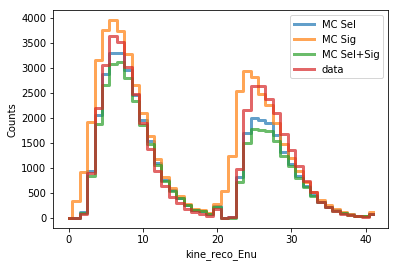

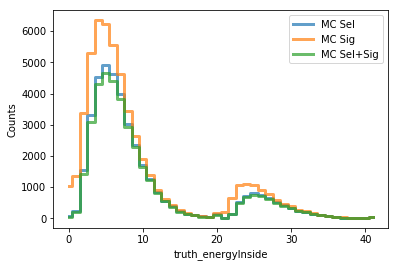

In [30]:
df_data = data_all_df.query(sel_query)
df_sel = all_df.query(sel_query)
df_sig_sel = all_df.query(sig_query).query(sel_query)
df_sig = all_df.query(sig_query)

reco_sel = df_sel[m_variable].to_numpy()
reco_sig_sel = df_sig_sel[m_variable].to_numpy()
reco_sig = df_sig[m_variable].to_numpy()
reco_data = df_data[m_variable].to_numpy()
truth_sel = df_sel[s_variable].to_numpy()
truth_sig_sel = df_sig_sel[s_variable].to_numpy()
truth_sig = df_sig[s_variable].to_numpy()


if Xp_truth:     
    b_truth = np.linspace(min_s, max_s, nbins_truth+1)   
    nbins_truth_plot = nbins_truth
    for x in range(len(extra_bins)):
        b_truth = np.append(b_truth,extra_bins[x])
        nbins_truth_plot+=1
    if overflow:
        b_truth = np.append(b_truth,1000000)
        nbins_truth_plot +=1
    if underflow:
        b_truth = np.insert(b_truth,0,-100000)
        nbins_truth_plot +=1
    truth_sel_bined, _ = np.histogram(truth_sel, bins=b_truth, weights=df_sel["net_weight"].to_numpy())
    truth_sig_sel_bined, _ = np.histogram(truth_sig_sel, bins=b_truth, weights=df_sig_sel["net_weight"].to_numpy())
    truth_sig_bined, _ = np.histogram(truth_sig, bins=b_truth, weights=df_sig["net_weight"].to_numpy()) 
else: #np0p for truth 
    b_truth_Np = np.linspace(min_s_Np, max_s_Np, nbins_truth+1)
    b_truth_0p = np.linspace(min_s_0p, max_s_0p, nbins_truth+1)
    nbins_truth_plot = nbins_truth*2
    if overflow:
        b_truth_Np = np.append(b_truth_Np,1000000)
        b_truth_0p = np.append(b_truth_0p,1000000)
        nbins_truth_plot +=2
    if underflow:
        b_truth_Np = np.insert(b_truth_Np,0,-100000)
        b_truth_0p = np.insert(b_truth_0p,0,-100000)
        nbins_truth_plot +=2
    b_truth =np.hstack((b_truth_Np,b_truth_0p))
    df_sel_Np_true = df_sel.query(truthNp_query)
    df_sel_0p_true = df_sel.query(truth0p_query)
    df_sig_Np_true = df_sig.query(truthNp_query)
    df_sig_0p_true = df_sig.query(truth0p_query)
    df_sig_sel_Np_true = df_sig_sel.query(truthNp_query)
    df_sig_sel_0p_true = df_sig_sel.query(truth0p_query)
    
    truth_sel_bined_Np, _ = np.histogram(df_sel_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sel_Np_true["net_weight"].to_numpy())
    truth_sel_bined_0p, _ = np.histogram(df_sel_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sel_0p_true["net_weight"].to_numpy())
    truth_sel_bined = np.hstack((truth_sel_bined_Np,truth_sel_bined_0p)) 
    truth_sig_bined_Np, _ = np.histogram(df_sig_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sig_Np_true["net_weight"].to_numpy())
    truth_sig_bined_0p, _ = np.histogram(df_sig_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sig_0p_true["net_weight"].to_numpy())
    truth_sig_bined = np.hstack((truth_sig_bined_Np,truth_sig_bined_0p))
    truth_sig_sel_bined_Np, _ = np.histogram(df_sig_sel_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sig_sel_Np_true["net_weight"].to_numpy())
    truth_sig_sel_bined_0p, _ = np.histogram(df_sig_sel_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sig_sel_0p_true["net_weight"].to_numpy())
    truth_sig_sel_bined = np.hstack((truth_sig_sel_bined_Np,truth_sig_sel_bined_0p))
        
if Xp_reco:
    b_reco = np.linspace(min_m, max_m, nbins_reco+1)
    nbins_reco_plot = nbins_reco
    if overflow:
        b_reco = np.append(b_reco,1000000)
        nbins_reco_plot +=1
    if underflow:
        b_reco = np.insert(b_reco,0,-100000)
        nbins_reco_plot +=1
    reco_sel_bined, _ = np.histogram(reco_sel, bins=b_reco, weights=df_sel["net_weight"].to_numpy())    
    reco_sig_sel_bined, _ = np.histogram(reco_sig_sel, bins=b_reco, weights=df_sig_sel["net_weight"].to_numpy())
    reco_sig_bined, _ = np.histogram(reco_sig, bins=b_reco, weights=df_sig["net_weight"].to_numpy())
    reco_bined_data, _ = np.histogram(reco_data, bins=b_reco)
else: #Np0p for reco
    b_reco_Np = np.linspace(min_m_Np, max_m_Np, nbins_reco+1)  
    b_reco_0p = np.linspace(min_m_0p, max_m_0p, nbins_reco+1) 
    nbins_reco_plot = nbins_reco*2
    if overflow:
        b_reco_Np = np.append(b_reco_Np,1000000)
        b_reco_0p = np.append(b_reco_0p,1000000)
        nbins_reco_plot +=2
    if underflow:
        b_reco_Np = np.insert(b_reco_Np,0,-100000)
        b_reco_0p = np.insert(b_reco_0p,0,-100000)
        nbins_reco_plot +=2
    b_reco = np.hstack((b_reco_Np,b_reco_0p))
    df_sel_Np = df_sel.query(recoNp_query)
    df_sel_0p = df_sel.query(reco0p_query)
    df_sig_Np = df_sig.query(recoNp_query)
    df_sig_0p = df_sig.query(reco0p_query)
    df_sig_sel_Np = df_sig_sel.query(recoNp_query)
    df_sig_sel_0p = df_sig_sel.query(reco0p_query) 
    reco_sel_bined_Np, _ = np.histogram(df_sel_Np[m_variable].to_numpy(), bins=b_reco_Np, weights=df_sel_Np["net_weight"].to_numpy())
    reco_sel_bined_0p, _ = np.histogram(df_sel_0p[m_variable].to_numpy(), bins=b_reco_0p, weights=df_sel_0p["net_weight"].to_numpy())
    reco_sel_bined = np.hstack((reco_sel_bined_Np,reco_sel_bined_0p)) 
    reco_sig_bined_Np, _ = np.histogram(df_sig_Np[m_variable].to_numpy(), bins=b_reco_Np, weights=df_sig_Np["net_weight"].to_numpy())
    reco_sig_bined_0p, _ = np.histogram(df_sig_0p[m_variable].to_numpy(), bins=b_reco_0p, weights=df_sig_0p["net_weight"].to_numpy())
    reco_sig_bined = np.hstack((reco_sig_bined_Np,reco_sig_bined_0p))
    reco_sig_sel_bined_Np, _ = np.histogram(df_sig_sel_Np[m_variable].to_numpy(), bins=b_reco_Np, weights=df_sig_sel_Np["net_weight"].to_numpy())
    reco_sig_sel_bined_0p, _ = np.histogram(df_sig_sel_0p[m_variable].to_numpy(), bins=b_reco_0p, weights=df_sig_sel_0p["net_weight"].to_numpy())
    reco_sig_sel_bined = np.hstack((reco_sig_sel_bined_Np,reco_sig_sel_bined_0p))
    
    df_Np_data = df_data.query(recoNp_query)
    df_0p_data = df_data.query(reco0p_query)
    reco_binedNp_data, _ = np.histogram(df_Np_data[m_variable].to_numpy(), bins=b_reco_Np)
    reco_bined0p_data, _ = np.histogram(df_0p_data[m_variable].to_numpy(), bins=b_reco_0p)
    reco_bined_data = np.hstack((reco_binedNp_data,reco_bined0p_data))

#plotting the distributions as a check
fig, ax = plt.subplots()
ax.step(np.arange(nbins_reco_plot), reco_sel_bined, where='mid', lw=3,
        alpha=0.7, label='MC Sel')
ax.step(np.arange(nbins_reco_plot), reco_sig_bined, where='mid', lw=3,
        alpha=0.7, label='MC Sig')
ax.step(np.arange(nbins_reco_plot), reco_sig_sel_bined, where='mid', lw=3,
        alpha=0.7, label='MC Sel+Sig')
ax.step(np.arange(nbins_reco_plot), reco_bined_data, where='mid', lw=3,
       alpha=0.7, label='data')
ax.set(xlabel=f'{m_variable}', ylabel='Counts')
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.step(np.arange(nbins_truth_plot), truth_sel_bined, where='mid', lw=3,
        alpha=0.7, label='MC Sel')
ax.step(np.arange(nbins_truth_plot), truth_sig_bined, where='mid', lw=3,
        alpha=0.7, label='MC Sig')
ax.step(np.arange(nbins_truth_plot), truth_sig_sel_bined, where='mid', lw=3,
        alpha=0.7, label='MC Sel+Sig')
ax.set(xlabel=f'{s_variable}', ylabel='Counts')
ax.legend()
plt.show()

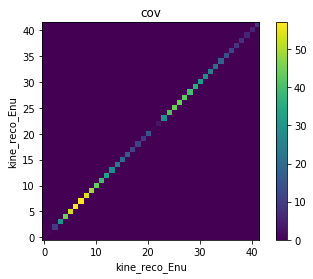

[0.05258859 0.15524499 0.41887919 0.58371131 0.67843035 0.74785154
 0.79315964 0.82905554 0.84391991 0.8577142  0.86108822 0.87333992
 0.87050708 0.87273033 0.87268944 0.85534111 0.85290594 0.84699278
 0.80110278 0.71632322 0.68950825 0.04230229 0.19131981 0.45003277
 0.59897934 0.71210308 0.7640127  0.80236526 0.84581296 0.86655006
 0.85314127 0.84713815 0.87484555 0.85936156 0.86891007 0.8569794
 0.81682512 0.70965019 0.83596694 0.79332476 0.75788659 0.65269726]


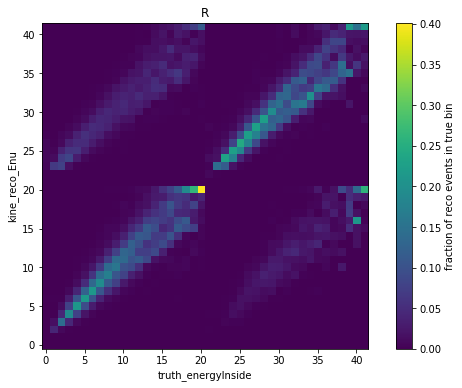

[0.00000000e+00 2.45168974e+00 9.94264281e+01 8.48071921e+02
 1.87278127e+03 2.66179214e+03 3.07408323e+03 3.11296303e+03
 2.79558487e+03 2.33870211e+03 1.85731741e+03 1.46970780e+03
 1.05111245e+03 7.28811814e+02 5.36968176e+02 3.89529013e+02
 2.50143428e+02 1.53096939e+02 1.34360777e+02 8.20704988e+01
 2.11923995e+02 1.10101686e+00 9.49573686e+00 7.16943093e+02
 1.49115473e+03 1.76938139e+03 1.75070777e+03 1.74572272e+03
 1.53362362e+03 1.23896462e+03 1.03012475e+03 8.05951658e+02
 6.23954127e+02 4.44310090e+02 3.10733355e+02 2.14408312e+02
 1.48096689e+02 9.38623728e+01 6.84709014e+01 3.75020928e+01
 3.88744904e+01 7.84181643e+01]
[0.00000000e+00 2.45168974e+00 9.94264281e+01 8.48071921e+02
 1.87278127e+03 2.66179214e+03 3.07408323e+03 3.11296303e+03
 2.79558487e+03 2.33870211e+03 1.85731741e+03 1.46970780e+03
 1.05111245e+03 7.28811814e+02 5.36968176e+02 3.89529013e+02
 2.50143428e+02 1.53096939e+02 1.34360777e+02 8.20704988e+01
 2.11923995e+02 1.10101686e+00 9.49573686e+00 7.16943

In [31]:

cov = np.array([[0]*nbins_reco_plot for _ in range(nbins_reco_plot)])
for i in range(len(reco_sel_bined)):
    cov[i][i] = np.sqrt(reco_sel_bined[i])


fig, ax = plt.subplots()
im = ax.imshow(cov, origin='lower')
cbar = plt.colorbar(im)
ax.set(xlabel=f"{m_variable}", ylabel=f"{m_variable}")
plt.title("cov")
plt.show()


R = [[0]*nbins_truth_plot for _ in range(nbins_reco_plot)]
if Xp_truth:
    len_bin_truth = (max_s-min_s)/nbins_truth
else: #Np0p for truth
    len_bin_truth_Np = (max_s_Np-min_s_Np)/nbins_truth
    len_bin_truth_0p = (max_s_0p-min_s_0p)/nbins_truth
if Xp_reco:
    len_bin_reco = (max_m-min_m)/nbins_reco
else: #Np0p for reco
    len_bin_reco_Np = (max_m_Np-min_m_Np)/nbins_reco
    len_bin_reco_0p = (max_m_0p-min_m_0p)/nbins_reco
    
#print(len_bin_truth)
truth_sig_sel = np.nan_to_num(truth_sig_sel)
reco_sig_sel = np.nan_to_num(reco_sig_sel)
weight = df_sig_sel["net_weight"].to_numpy()
nump = df_sig_sel["num_proton"].to_numpy()
tnump = df_sig_sel["num_prim_protons"].to_numpy()
pE = df_sig_sel["truth_max_p_energy"].to_numpy()
for event in range(len(reco_sig_sel)):
    if Xp_truth:
        if truth_sig_sel[event]<min_s:
            if underflow: truth_bin = 0 
            else: continue
        elif truth_sig_sel[event]>max_s:
            if overflow: truth_bin = -1
            else: continue
        else: truth_bin = int(underflow+(truth_sig_sel[event]-min_s)//len_bin_truth)
    else: #N0pTruth
        if tnump[event]>0 and pE[event]>35:#TrueNp
            if truth_sig_sel[event]<min_s_Np:
                if underflow: truth_bin=0
                else: continue 
            elif truth_sig_sel[event]>max_s_Np:
                if overflow: truth_bin = nbins_truth+underflow
                else: continue
            else: truth_bin = int(underflow+(truth_sig_sel[event]-min_s_Np)//len_bin_truth_Np)               
        else:#true0p 
            if truth_sig_sel[event]<min_s_0p:
                if underflow: truth_bin = nbins_truth+underflow+overflow
                else: continue
            elif truth_sig_sel[event]>max_s_0p:
                if overflow: truth_bin = -1
                else: continue
            else: truth_bin = int(2*underflow+overflow+nbins_truth+(truth_sig_sel[event]-min_s_0p)//len_bin_truth_0p)
    if Xp_reco:
        if reco_sig_sel[event]<min_m:
            if underflow: reco_bin = 0
            else: continue
        elif reco_sig_sel[event]>max_m:
            if overflow: reco_bin = -1 
            else: continue
        else: reco_bin = int(underflow+(reco_sig_sel[event]-min_m)//len_bin_reco)
    else: #Np0preco              
        if nump[event]>0:#recoNp
            if reco_sig_sel[event]<min_m_Np:
                if underflow: reco_bin=0
                else: continue  
            elif reco_sig_sel[event]>max_m_Np:
                if overflow: reco_bin = nbins_reco+underflow  
                else: continue
            else: reco_bin = int(underflow+(reco_sig_sel[event]-min_m_Np)//len_bin_reco_Np)
        else:#reco0p
            if reco_sig_sel[event]<min_m_0p:
                if underflow: reco_bin = underflow+nbins_reco+overflow
                else: continue  
            elif reco_sig_sel[event]>max_m_0p:
                if overflow: reco_bin = -1  
                else: continue
            else: reco_bin = int(2*underflow+overflow+nbins_reco+(reco_sig_sel[event]-min_m_0p)//len_bin_reco_0p)               
    R[reco_bin][truth_bin] += weight[event]

column_sums = np.array(R).sum(axis=0)
normalization_factor = 1 / column_sums
normalization_factor = np.nan_to_num(normalization_factor)
R = R * normalization_factor
if Xp_truth:
    normalization_factor2, _ = np.histogram(df_sig_sel[s_variable].to_numpy(), bins=b_truth, weights=df_sig_sel["net_weight"].to_numpy())
    normalization_factor1, _ = np.histogram(df_sig[s_variable].to_numpy(), bins=b_truth, weights=df_sig["net_weight"].to_numpy())   
else:
    normalization_factor2_Np, _ = np.histogram(df_sig_sel_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sig_sel_Np_true["net_weight"].to_numpy())
    normalization_factor2_0p, _ = np.histogram(df_sig_sel_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sig_sel_0p_true["net_weight"].to_numpy())
    normalization_factor2 = np.hstack((normalization_factor2_Np,normalization_factor2_0p))
    normalization_factor1_Np, _ = np.histogram(df_sig_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sig_Np_true["net_weight"].to_numpy())
    normalization_factor1_0p, _ = np.histogram(df_sig_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sig_0p_true["net_weight"].to_numpy())
    normalization_factor1 = np.hstack((normalization_factor1_Np,normalization_factor1_0p))
normalization_factor = normalization_factor2/normalization_factor1
R = R * normalization_factor
print(np.array(R).sum(axis=0))


fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(R, origin='lower')
cbar = plt.colorbar(im, label='fraction of reco events in true bin')
ax.set(xlabel=f"{s_variable}", ylabel=f"{m_variable}")
plt.title("R")
plt.show()

if Xp_reco:
    bckg_df = df_sel.query(f"not ({sig_query})")
    bckg, _ = np.histogram(bckg_df[m_variable], bins=b_reco, weights=bckg_df["net_weight"].to_numpy())
else:
    bckg_Np_df = df_sel.query(f"not ({sig_query}) and num_proton>0")
    bckg_0p_df = df_sel.query(f"not ({sig_query}) and num_proton==0")
    bckg_Np, _ = np.histogram(bckg_Np_df[m_variable], bins=b_reco_Np, weights=bckg_Np_df["net_weight"].to_numpy())
    bckg_0p, _ = np.histogram(bckg_0p_df[m_variable], bins=b_reco_0p, weights=bckg_0p_df["net_weight"].to_numpy())
    bckg = np.hstack((bckg_Np,bckg_0p))
    

print(reco_sel_bined-bckg)
print((np.matmul(R,truth_sig_bined)))
print("####################################")
if data:
    reco_sel_bined = reco_bined_data
'''#m_hat = np.matmul(R,truth_sig_sel_bined)
m_hat = np.matmul(R,truth_sig_bined)
sum_m = 0
sum_m_hat = 0
for i in range(len(m_c)):
    sum_m_hat += m_hat[i]
    sum_m += m_c[i]-bckg_c[i]
print(sum_m_hat)
print(sum_m)'''   
    
#saving stuff to a root file to put in the framework
with uproot.recreate("wiener.root") as file:

    file["R"] = uproot.newtree({"R": np.double})
    file["R"].extend({"R": R.flatten()})
    file["cov"] = uproot.newtree({"cov":np.double})
    file["cov"].extend({"cov": cov.flatten()})
    
    file["sig"] = uproot.newtree({"sig": np.double})#unsed in reweight
    file["sig"].extend({"sig": truth_sel_bined})#unsed in reweight
    file["bins"] = uproot.newtree({"bins": np.double})
    file["bins"].extend({"bins":b_truth})
    file["meas"] = uproot.newtree({"meas": np.double})
    file["meas"].extend({"meas": reco_sel_bined})
    file["tsig"] = uproot.newtree({"tsig": np.double})#unsed in reweight
    file["tsig"].extend({"tsig": truth_sig_sel_bined})#unsed in reweight
    file["bckg"] = uproot.newtree({"bckg": np.double})
    file["bckg"].extend({"bckg": bckg})
    
    file["sig_all"] = uproot.newtree({"sig_all": np.double})
    file["sig_all"].extend({"sig_all": truth_sig_bined})
    #file["sig_all"].extend({"sig_all": truth_sig_sel_bined})
    

In [175]:
reweight = [0.810563, 0.867117, 0.820935, 1.05802, 1.03275, 1.14742, 1.05235, 0.943924, 0.988252, 0.944705, 0.778566, 0.639468, 0.624466, 0.573806, 0.367477, 0.181954, 0.135965, 0.310726, 0.624897, 0.897318, 0.683811,
2.0383, 1.62078, 1.76489, 2.02162, 1.97358, 1.71678, 1.59773, 1.71367, 1.9158, 1.96495, 1.9844, 1.83067, 1.78271, 1.56247, 1.39514, 1.2969, 1.21212, 1.2287, 1.57712, 1.68233, 1.22789]

wall_df = all_df.copy()

weight = wall_df["net_weight"].to_numpy(copy=True)
truth_NprimPio = wall_df["truth_NprimPio"].to_numpy()
truth_isCC = wall_df["truth_isCC"].to_numpy()
pdg  = wall_df["truth_nuPdg"].to_numpy()
protons = wall_df["num_prim_protons"].to_numpy()
p_energy = wall_df["truth_max_p_energy"].to_numpy()
vtx = wall_df["truth_vtxInside"].to_numpy()
dirt = wall_df["isDirt"].to_numpy()
ext = wall_df["isEXT"].to_numpy()


len_bin = (max_s-min_s)/nbins_truth
bin_len_Np = (max_s_Np-min_s_Np)/nbins_truth
bin_len_0p = (max_s_0p-min_s_0p)/nbins_truth
#print(len_bin)

#no underflow reweighting
w = wall_df[s_variable].to_numpy()
for j in range(len(weight)):
    if truth_isCC[j]==1 and abs(pdg[j])==14: 
        if w[j]>max_s_Np and protons[j]>0 and p_energy[j]>35:
            if overflow: weight[j] = weight[j] * reweight[nbins_truth+underflow]
            else: continue
        elif w[j]>min_s_Np and protons[j]>0 and p_energy[j]>35:
            wbin = (w[j]-min_s_Np)//bin_len_Np
            weight[j] = weight[j] * reweight[int(wbin)]
        if w[j]>max_s_0p and (protons[j]==0 or p_energy[j]<=35):
            if overflow: weight[j] = weight[j] * reweight[-1]
            else: continue
        elif w[j]>min_s_0p and (protons[j]==0 or p_energy[j]<=35):
            wbin = nbins_truth+2*underflow+overflow + (w[j]-min_s_0p)//bin_len_0p
            weight[j] = weight[j] * reweight[int(wbin)]
        
        
wall_df["net_weight"] = weight
wall_df=wall_df.replace(np.nan, 0)

## pi0 Reweighting

In [48]:
#30
bckg_c = [ 13.2723, 41.2465, 51.85, 54.6413, 73.6322, 81.9398, 63.9462, 68.5808, 73.9578, 64.5184, 55.7409, 46.5762, 42.2925, 38.2589, 40.7105, 20.5308, 20.1002,19.2208, 7.92032+ 7.17855+ 15.363+ 7.42764+ 9.59169+ 5.66465+ 7.02595+ 3.99223+13.2209,
          11.209, 80.8835, 180.264, 173.276, 165.66, 128.876, 135.424, 104.254, 91.284, 83.2916, 65.8712, 50.9208, 46.1191, 32.5962, 23.0298, 17.9102, 17.5002+ 8.033+ 10.0625+ 12.4374+ 1.28077+ 1.9033+ 7.50449+ 3.16537+ 4.40236+ -1.28622+4.26829+2.43172+23.53]
#0, 0, 0, 1.37457,                 19.2208, 7.92032, 7.17855, 15.363, 7.42764, 9.59169, 5.66465, 7.02595, 3.99223, 13.2209
#0, 0, ,                   10.0625, 12.4374, 1.28077, 1.9033, 7.50449, 3.16537, 4.40236, -1.28622, 4.26829, 2.43172, 23.53
m_c = [ 53.0282, 128.85, 188.8, 222.002, 247.638, 259.679, 217.372, 203.17, 184.186, 151.232, 128.159, 100.797, 91.9446, 68.8613, 55.1241, 42.0155, 35.9426, 24.6141, 15.2837+ 15.807+ 15.9925+ 12.2213+ 10.5605+ 7.41701+ 8.06067+ 3.3219+26.0461,
        14.9347, 154.789, 383.112, 422.626, 389.863, 333.688, 324.451, 259.02, 199.649, 155.952, 132.62, 98.5093, 84.0233, 66.5111, 45.2417, 27.2658, 28.5783+ 16.3338+ 11.0935+ 13.5575+ 5.35063+ 5.65108+ 6.06518+ 7.37097+3.29366+4.10422+3.93638+1.37459+21.2279]
#0, 0, 0, 7.88859,                       24.6141, 15.2837, 15.807, 15.9925, 12.2213, 10.5605, 7.41701, 8.06067, 3.32199, 26.0461,
#0, 0.0111236,              11.0935, 13.5575, 5.35063, 5.65108, 6.06518, 7.37097, 3.29366, 4.10422, 3.93638, 1.37459, 21.2279

sig_c = [ 180.418, 312.881, 450.395, 495.997, 489.774, 478.972, 405.757, 345.358, 290.639, 228.598, 195.224, 159.058, 124.367, 109.866, 79.9454, 63.0126, 51.0556, 42.6338, 32.1927+ 29.435+ 21.6688+ 17.3917+ 14.134+ 10.7+ 7.4691+ 11.6908+ 93.3797,
         57.548, 105.029, 222.854, 269.617, 251.434, 207.655, 173.073, 141.146, 99.5146, 70.9133, 52.1812, 47.4055, 28.1383, 19.9487, 19.1786, 14.4743, 10.5802+ 6.86215+ 6.472+ 4.51706+ 2.93106+ 2.71305+ 3.82666+ 2.25324+ 1.14761+ 1.63693+ 1.07769+ 0.515567+ 9.20718]
#22.6198, 36.4396, 69.6524, 103.066,
#9.25624, 23.942, 
         
#both sig definitions below only use the true primary protons, not all
'''sig_c = [138.166, 249.63, 379.358, 424.421, 420.737, 414.714, 346.287, 292.668, 246.31, 190.588, 161.141, 135.171, 102.419, 93.981, 68.0307, 50.3685, 41.9855, 34.3742, 28.5703, 24.9565, 17.9438, 12.8056,# 10.3386+ 8.65914+ 4.99362+ 8.52875+64.2568,
          126.538, 260.541, 331.027, 320.823, 271.179, 236.39, 202.479, 158.108, 122.24, 95.4086, 86.1119, 62.542, 43.159, 42.7771, 30.9862]#, 24.0406, 20.0773, 16.5233+ 12.8801+ 7.13531+ 7.84824+7.95412+7.56859+4.51943+3.59572+3.52878+3.51502+38.2442]
#20.7803, 31.8599, 54.2886, 78.9058,
#10.1617, 28.4001,71.64,'''
    
#below is the incorrect signal where np0p is split based on truth and only selected events are considered, also include PC events
'''sig_sel_c = [17.6523, 64.3078, 111.951, 165.541, 190.68, 199.132, 160.688, 140.599, 113.367, 86.6427, 69.8702, 57.2383, 45.0328, 31.6092, 22.9816, 16.2163, 10.755, 10.4911, 7.8689, 6.16818, 2.10202, 3.27548, 1.41809, 2.13719, 1.3592, 1.122,# 8.68354,
22.7079, 106.67, 191.44, 248.322, 224, 215.45, 177.069, 140.656, 96.6437, 78.199, 57.4503, 46.2688, 30.7443, 25.306, 19.4773, 10.322, 8.70916, 6.37251, 5.9279, 3.43736, 4.11038, 2.57413, 1.5765, 1.94698, 0.518834, 0.737563]#,  0.171365+3.86154]
#0, 0.094743, 0.20126, 1.79328,                       10.4911, 7.8689, 6.16818, 2.10202, 3.27548, 1.41809, 2.13719, 1.3592, 1.122, 8.68354,
#0, 0, 1.55947,                                       6.37251, 5.9279, 3.43736, 4.11038, 2.57413, 1.5765, 1.94698, 0.518834, 0.737563, 0.171365, 3.86154'''

'sig_sel_c = [17.6523, 64.3078, 111.951, 165.541, 190.68, 199.132, 160.688, 140.599, 113.367, 86.6427, 69.8702, 57.2383, 45.0328, 31.6092, 22.9816, 16.2163, 10.755, 10.4911, 7.8689, 6.16818, 2.10202, 3.27548, 1.41809, 2.13719, 1.3592, 1.122,# 8.68354,\n22.7079, 106.67, 191.44, 248.322, 224, 215.45, 177.069, 140.656, 96.6437, 78.199, 57.4503, 46.2688, 30.7443, 25.306, 19.4773, 10.322, 8.70916, 6.37251, 5.9279, 3.43736, 4.11038, 2.57413, 1.5765, 1.94698, 0.518834, 0.737563]#,  0.171365+3.86154]\n#0, 0.094743, 0.20126, 1.79328,                       10.4911, 7.8689, 6.16818, 2.10202, 3.27548, 1.41809, 2.13719, 1.3592, 1.122, 8.68354,\n#0, 0, 1.55947,                                       6.37251, 5.9279, 3.43736, 4.11038, 2.57413, 1.5765, 1.94698, 0.518834, 0.737563, 0.171365, 3.86154'

In [229]:
#new constrained signal and background

bckg_c = [ 11.1124, 40.216, 66.0798, 53.8643, 86.6487, 99.4573, 69.46, 62.4009, 87.0969, 84.6086, 69.6372, 48.5265, 48.4387, 44.2995, 39.8559, 24.0991, 20.461, 25.4283, 8.89565, 8.71508, 21.1482, 12.0386, 11.3812, 5.49606,# 6.59227, 5.07597,# 15.0703,
           12.3388, 72.9482, 225.168, 164.866, 169.852, 139.981, 149.496, 115.195, 96.6243, 102.93, 72.6064, 59.0994, 51.5334, 30.3619]#, 32.4269, 20.9456, 17.6252, 5.39024, 11.3411, 14.5084]#, 2.61261, 4.26137]#, 7.98537, 5.1531, 4.35727, 0.187433, 4.96249, 3.79328, 23.555]
#0, 0, 0, 1.30055, 40.216,
#0, 0,
    
m_c = [47.101, 129.913, 199.583, 216.557, 263.743, 279.001, 225.317, 192.265, 201.81, 175.565, 146.275, 104.583, 97.8458, 79.9756, 64.5212, 44.5583, 36.8659, 38.1776, 16.4285, 14.2266, 26.3466, 16.7234, 13.5497, 8.52831,# 7.88391, 6.82205,# 23.6725,
       16.6217, 142.749, 427.382, 410.776, 399.73, 348.833, 341.232, 261.319, 207.127, 186.76, 140.205, 107.029, 86.125, 57.9028]#, 53.5887, 33.4875, 27.5041, 10.4781, 14.5936, 20.2102]#, 4.87171, 6.13346]#, 8.46452, 7.16593, 4.60959, 1.43877, 5.51807, 3.56072, 26.9719]
#0, 0, 0, 7.32899, 47.101,
#0, 0.0534402,
sig_c = [181.248, 312.766, 440.994, 496.386, 496.18, 470.442, 403.321, 341.826, 287.057, 226.679, 197.915, 161.556, 132.739, 108.608, 80.906, 64.6638, 51.4979, 42.2481, 32.0387, 27.9991, 20.7533, 17.6495, 14.3759, 13.1881,# 8.14842, 10.6312,# 92.638,
          59.163, 102.828, 213.085, 263.47, 252.685, 207.212, 175.405, 140.329, 101.131, 72.1478, 54.1652, 44.2339, 28.0342, 21.5472]#, 17.6288, 13.5092, 8.81774, 6.6908, 6.21924, 4.06224]#, 3.73505, 3.72217]#, 2.73166, 1.93163, 1.80601, 1.2688, 1.09768, 0.699126, 7.82599]
#28.1456, 39.4242, 74.7286, 99.6096, 181.248
#12.6206, 26.8987, 
print([x-y for x,y in zip(m_c,bckg_c)])

[35.9886, 89.697, 133.5032, 162.6927, 177.09429999999998, 179.54369999999997, 155.85700000000003, 129.86409999999998, 114.7131, 90.9564, 76.6378, 56.0565, 49.4071, 35.6761, 24.665299999999995, 20.459200000000003, 16.404900000000005, 12.749299999999998, 7.53285, 5.511519999999999, 5.1983999999999995, 4.684800000000001, 2.1685, 3.0322499999999994, 4.2829, 69.8008, 202.214, 245.91, 229.87800000000001, 208.85200000000003, 191.73600000000002, 146.12400000000002, 110.5027, 83.82999999999998, 67.59860000000002, 47.92959999999999, 34.5916, 27.5409]


In [43]:
bckg_c = [ 16.7285, 39.547, 47.2695, 57.4495, 83.653, 81.18, 58.945, 69.0261, 74.8957, 65.0967, 46.031, 44.3973, 45.3055, 23.2256, 37.1315, 29.9319, 20.8433, 16.8638, 12.4007, 11.0379, 14.0789, 6.26364, 15.8476, 6.69294,# 5.79507, 0.508466, 17.63,
           7.56794, 79.6462, 169.656, 161.162, 148.311, 119.843, 118.418, 102.855, 90.1552, 62.4162, 58.9236, 44.1785, 49.7432, 32.0554, 21.6064, 24.7001, 13.5964, 14.2219]#, 12.8208, 5.99072, 7.88944, 4.36456, -4.16588, 2.65111, 3.53581, -4.08586, -0.832215, 5.85661, 12.1773]
#0, 0, 0, 2.08984,
#0, 0,

m_c =[ 58.3186, 125.673, 180.583, 216.39, 249.202, 251.754, 207.661, 195.786, 183.701, 153.045, 122.479, 96.874, 90.1116, 68.8876, 56.5439, 46.7301, 43.9783, 28.9619, 20.6343, 23.2149, 18.1358, 18.6097, 16.6309, 9.90002,# 9.32913, 7.00021, 37.4409,
      12.6141, 161.482, 383.712, 407.582, 379.854, 320.118, 274.581, 205.919, 171.78, 125.424, 123.836, 88.225, 65.0956, 65.1175, 46.0371, 31.1215, 27.6359, 17.4938]#, 16.151, 10.4513, 9.37592, 10.1322, 10.4586, 5.40361, 6.43964, 3.42905, 3.87661, 4.25943, 14.4447]
#0, 0, 0, 8.02309,
#0, 0.0194993,
sig_c = [ 178.416, 315.746, 429.175, 473.713, 461.907, 425.197, 351.353, 292.33, 243.751, 191.549, 168.966, 138.495, 110.755, 93.1521, 71.2591, 59.455, 45.341, 37.8529, 32.2818, 27.0274, 21.0126, 16.5353, 13.5526, 11.3076,# 8.09581, 9.77494, 83.6584
         53.6703, 99.2735, 204.544, 248.302, 225.523, 173.937, 134.882, 99.5232, 65.3322, 45.8619, 36.2811, 28.9635, 19.4043, 12.0218, 10.5707, 6.33814, 5.96464, 3.64074]#, 3.97616, 2.73279, 2.47653, 2.00451, 1.50068, 1.52501, 0.985133, 0.262376, 0.48162, 0.304005, 4.43829]
#25.7135, 37.3156, 70.0299, 97.4301,
#10.1412, 24.3565,
print([x-y for x,y in zip(m_c,bckg_c)])

[41.59010000000001, 86.126, 133.3135, 158.9405, 165.54899999999998, 170.57399999999998, 148.716, 126.7599, 108.80529999999999, 87.94829999999999, 76.44800000000001, 52.476699999999994, 44.806099999999994, 45.662000000000006, 19.412399999999998, 16.7982, 23.134999999999998, 12.098099999999999, 8.2336, 12.177, 4.056899999999999, 12.346060000000001, 0.7833000000000006, 3.2070799999999995, 5.04616, 81.8358, 214.05599999999998, 246.42, 231.54299999999998, 200.27499999999998, 156.163, 103.06400000000001, 81.62480000000001, 63.0078, 64.91239999999999, 44.046499999999995, 15.352400000000003, 33.06210000000001, 24.4307, 6.421400000000002, 14.0395, 3.2719000000000005]


In [168]:
bckg_c = [18.418, 40.1481, 57.0663, 51.697, 85.1004, 81.869, 63.0519, 66.2429, 74.1266, 67.2299, 48.0344, 50.1405, 39.7842, 28.5729, 39.2312, 18.8298, 23.511, 11.5227, 7.54775, 0.490578, 3.65982+ 2.95288+ 7.9314+ 2.3935+ 6.01159+ 1.30015+ 12.5914,
           77.7553, 184.577, 172.582, 159.208, 130.266, 125.988, 106.799, 83.711, 73.3444, 60.1367, 43.7996, 36.4571, 29.454, 13.6206+ 23.0772+ 5.81778+ 11.8565+ 9.9733+ 6.44493+ 5.46433+ 0.163462+ -7.91514+ -3.22466+ 0.601863+ -7.59571+ -2.56731+ -0.283676+ -9.13134]
#0, 0, 0, 1.54241,  
#0, 0, 11.6361,




m_c = [55.1067, 127.648, 193.773, 226.025, 266.716, 269.523, 227.572, 208.758, 197.601, 167.521, 135.275, 107.494, 97.3347, 71.2056, 54.1867, 48.0448, 40.2403, 26.7345, 17.8926, 16.113, 16.0388+ 14.6423+ 10.5973+ 6.75937+ 6.96218+ 2.85514+ 29.7044,
        147.845, 392.546, 423.286, 384.258, 340.518, 322.176, 267.114, 198.873, 160.903, 131.573, 103.431, 87.8645, 62.6625, 47.4009+ 30.75553+ 27.3085+ 16.343+ 11.4766+ 11.9215+ 7.78237+ 7.24499+ 5.4024+ 7.4487+ 1.79094+ 4.79385+ 3.65088+ 1.40396+ 19.057]
#0, 0, 0, 8.42729, 
#0, 0.0368616, 15.0091,



sig_c = [181.405, 312.505, 440.334, 495.669, 495.72, 470.361, 403.527, 342.073, 287.513, 227.351, 198.601, 162.217, 133.448, 109.216, 81.3621, 65.1952, 51.9807, 42.7504, 32.3762, 28.2859, 20.9335+ 17.7861+ 14.5289+ 13.2597+ 8.20531+ 10.721+ 92.7886,
           102.93, 213.007, 262.628, 251.59, 206.351, 174.726, 139.981, 100.849, 71.9756, 54.0436, 44.2283, 28.0592, 21.4856, 17.644+ 13.5332+ 8.85954+ 6.69144+ 6.22986+ 4.0826+ 3.74896+ 3.71896+ 2.74163+1.94907+ 1.81467+ 1.26688+ 1.10337+ 0.69831+ 7.85027]
#28.237, 39.4448, 74.6683, 99.7364,
#12.6077, 26.8763, 59.1389,

print([x-y for x,y in zip(m_c,bckg_c)])
print(len(bckg_c))
print(len(m_c))
print(len(sig_c))

[36.6887, 87.4999, 136.7067, 174.328, 181.61560000000003, 187.65400000000002, 164.5201, 142.51510000000002, 123.4744, 100.29109999999999, 87.2406, 57.3535, 57.5505, 42.6327, 14.9555, 29.215000000000003, 16.7293, 15.2118, 10.344850000000001, 15.622422, 50.71875, 70.0897, 207.969, 250.704, 225.04999999999998, 210.25199999999998, 196.188, 160.31499999999997, 115.16199999999999, 87.5586, 71.43630000000002, 59.6314, 51.40740000000001, 33.2085, 157.478991]
35
35
35


In [72]:
bckg_c = [18.418, 40.1481, 57.0663, 51.697, 85.1004, 81.869, 63.0519, 66.2429, 74.1266, 67.2299, 48.0344, 50.1405, 39.7842, 28.5729, 39.2312, 18.8298, 23.511, 11.5227, 7.54775, 0.490578, 3.65982, 2.95288,#+ 7.9314+ 2.3935+ 6.01159+ 1.30015+ 12.5914,
          11.6361, 77.7553, 184.577, 172.582, 159.208, 130.266, 125.988, 106.799, 83.711, 73.3444, 60.1367, 43.7996, 36.4571, 29.454, 13.6206, 23.0772]#+ 5.81778+ 11.8565+ 9.9733+ 6.44493+ 5.46433+ 0.163462+ 0+ 0+ 0.601863+ 0+ 0+ 0+ 30]
#0, 0, 0, 1.54241,  
#0, 0, 




m_c = [55.1067, 127.648, 193.773, 226.025, 266.716, 269.523, 227.572, 208.758, 197.601, 167.521, 135.275, 107.494, 97.3347, 71.2056, 54.1867, 48.0448, 40.2403, 26.7345, 17.8926, 16.113, 16.0388, 14.6423,#+ 10.5973+ 6.75937+ 6.96218+ 2.85514+ 29.7044,
       15.0091, 147.845, 392.546, 423.286, 384.258, 340.518, 322.176, 267.114, 198.873, 160.903, 131.573, 103.431, 87.8645, 62.6625, 47.4009, 30.75553]# 27.3085+ 16.343+ 11.4766+ 11.9215+ 7.78237+ 7.24499+ 5.4024+ 7.4487+ 1.79094+ 4.79385+ 3.65088+ 1.40396+ 19.057]
#0, 0, 0, 8.42729, 
#0, 0.0368616, 



sig_c = [181.405, 312.505, 440.334, 495.669, 495.72, 470.361, 403.527, 342.073, 287.513, 227.351, 198.601, 162.217, 133.448, 109.216, 81.3621, 65.1952, 51.9807, 42.7504, 32.3762, 28.2859, 20.9335, 17.7861,#+ 14.5289+ 13.2597+ 8.20531+ 10.721+ 92.7886,
          59.1389, 102.93, 213.007, 262.628, 251.59, 206.351, 174.726, 139.981, 100.849, 71.9756, 54.0436, 44.2283, 28.0592, 21.4856, 17.644, 13.5332]#8.85954+ 6.69144+ 6.22986+ 4.0826+ 3.74896+ 3.71896+ 2.74163+1.94907+ 1.81467+ 1.26688+ 1.10337+ 0.69831+ 7.85027]
#28.237, 39.4448, 74.6683, 99.7364,
#12.6077, 26.8763, 

print([x-y for x,y in zip(m_c,bckg_c)])
print(len(bckg_c))
print(len(m_c))
print(len(sig_c))

[36.6887, 87.4999, 136.7067, 174.328, 181.61560000000003, 187.65400000000002, 164.5201, 142.51510000000002, 123.4744, 100.29109999999999, 87.2406, 57.3535, 57.5505, 42.6327, 14.9555, 29.215000000000003, 16.7293, 15.2118, 10.344850000000001, 15.622422, 12.378979999999999, 11.68942, 3.3729999999999993, 70.0897, 207.969, 250.704, 225.04999999999998, 210.25199999999998, 196.188, 160.31499999999997, 115.16199999999999, 87.5586, 71.43630000000002, 59.6314, 51.40740000000001, 33.2085, 33.7803, 7.678329999999999]
38
38
38


In [165]:
bckg_c = [ 40.1481, 57.0663, 51.697, 85.1004, 81.869, 63.0519, 66.2429, 74.1266, 67.2299, 48.0344, 50.1405, 39.7842, 28.5729, 39.2312, 18.8298, 23.511, 11.5227, 7.54775, 0.490578, 3.65982, 2.95288, 7.9314, 2.3935,#+ 6.01159+ 1.30015+ 12.5914,
          77.7553, 184.577, 172.582, 159.208, 130.266, 125.988, 106.799, 83.711, 73.3444, 60.1367, 43.7996, 36.4571, 29.454, 13.6206, 23.0772, 5.81778, 11.8565]#+ 9.9733+ 6.44493+ 5.46433+ 0.163462+ 0+ 0+ 0.601863+ 0+ 0+ 0+ 30]
#0, 0, 0, 1.54241,  18.418,
#0, 0, 11.6361,




m_c = [ 127.648, 193.773, 226.025, 266.716, 269.523, 227.572, 208.758, 197.601, 167.521, 135.275, 107.494, 97.3347, 71.2056, 54.1867, 48.0448, 40.2403, 26.7345, 17.8926, 16.113, 16.0388, 14.6423, 10.5973, 6.75937,#+ 6.96218+ 2.85514+ 29.7044,
         147.845, 392.546, 423.286, 384.258, 340.518, 322.176, 267.114, 198.873, 160.903, 131.573, 103.431, 87.8645, 62.6625, 47.4009, 30.7555, 27.3085, 16.343]# 11.4766+ 11.9215+ 7.78237+ 7.24499+ 5.4024+ 7.4487+ 1.79094+ 4.79385+ 3.65088+ 1.40396+ 19.057]
#0, 0, 0, 8.42729, 55.1067,
#0, 0.0368616, 15.0091,



sig_c =  [ 254.879, 372.896, 427.857, 429.542, 406.491, 343.34, 293.355, 243.166, 190.311, 166.158, 134.856, 108.827, 91.9296, 67.1847, 52.1322, 42.1608, 34.9859, 25.9611, 24.2947, 16.7459, 13.5588, 10.8017, 10.3242,# 5.89763, 8.22259, 63.4209
            127.004, 254.8, 319.166, 317.93, 272.9, 239.309, 201.675, 158.797, 118.619, 96.3114, 79.0896, 58.4666, 47.123, 40.6717, 29.5136, 21.8888, 18.7595]#, 15.214, 11.0766, 9.55255, 7.19358, 6.58124, 5.8991, 5.27267, 4.04589, 3.27747, 3.0484, 36.5692]
#26.1995, 34.6268, 59.1236, 74.7274, 138.151,
#14.5564, 31.8515,  74.4185,

print([x-y for x,y in zip(m_c,bckg_c)])
print(len(bckg_c))
print(len(m_c))
print(len(sig_c))

[87.4999, 136.7067, 174.328, 181.61560000000003, 187.65400000000002, 164.5201, 142.51510000000002, 123.4744, 100.29109999999999, 87.2406, 57.3535, 57.5505, 42.6327, 14.9555, 29.215000000000003, 16.7293, 15.2118, 10.344850000000001, 15.622422, 12.378979999999999, 11.68942, 2.6659000000000006, 4.365869999999999, 70.0897, 207.969, 250.704, 225.04999999999998, 210.25199999999998, 196.188, 160.31499999999997, 115.16199999999999, 87.5586, 71.43630000000002, 59.6314, 51.40740000000001, 33.2085, 33.7803, 7.6783, 21.49072, 4.4864999999999995]
40
40
40


In [208]:
#setup for getting the CV reweighting the pi0
nbins_reco = 20
nbins_truth = 30
nbins_reco_Np = 15
nbins_truth_Np = 10
nbins_reco_0p = 20
nbins_truth_0p = 15

m_variable = "kine_reco_Enu"
s_variable = "truth_energyInside"

Xp_truth = False
Xp_reco = False
data = True
overflow = True
underflow = False 
constrained = False

min_m = 0
max_m = 800
min_s = 0
max_s = 800

min_m_Np = 200
max_m_Np = 1000
min_s_Np = 200
max_s_Np = 1000
min_m_0p = 100
max_m_0p = 900
min_s_0p = 100
max_s_0p = 900

sel_query = "nc_pio_score > 1.816 and kine_pio_energy_1 > 0 and kine_pio_energy_2 > 0 and not (nc_delta_score > 2.61 and reco_showerKE > 0)"
sig_query =f"truth_isCC==0 and truth_NprimPio>0 and truth_NCDelta==0"
#sel_query = "nc_pio_score > 1.816 and kine_pio_energy_1 > 0 and kine_pio_energy_2 > 0"
#sig_query =f"truth_isCC==0 and truth_NprimPio>0"
reco0p_query = "num_proton == 0"
recoNp_query = "num_proton > 0"
#truth0p_query = "true_protons==0 or truth_max_p_energy<35"
#truthNp_query = "true_protons>0 and truth_max_p_energy>=35"
truth0p_query = "num_prim_protons==0 or truth_max_prim_p_energy<35"
truthNp_query = "num_prim_protons>0 and truth_max_prim_p_energy>=35"

use_mbins=False
mbins = [200,250,300,350,400,450,500,550,600,650,700,800,1000,1200,1400,    
         100,150,200,250,300,350,400,450,500,550,600,650,700,800,1000]
mbins_Np = [200,250,300,350,400,450,500,550,600,650,700,800,1000,1200,1400]
mbins_0p = [100,150,200,250,300,350,400,450,500,550,600,650,700,800,1000]

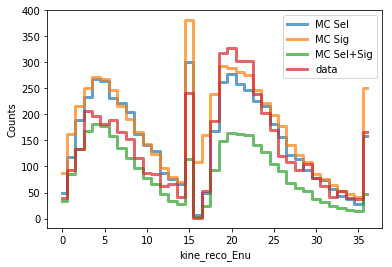

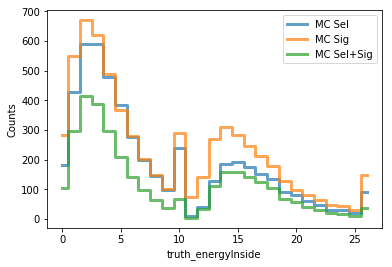

hi


In [209]:
df_data = data_all_df.query(sel_query)
df_sel = all_df.query(sel_query)
df_sig_sel = all_df.query(sig_query).query(sel_query)
df_sig = all_df.query(sig_query)

reco_sel = df_sel[m_variable].to_numpy()
reco_sig_sel = df_sig_sel[m_variable].to_numpy()
reco_sig = df_sig[m_variable].to_numpy()
reco_data = df_data[m_variable].to_numpy()
truth_sel = df_sel[s_variable].to_numpy()
truth_sig_sel = df_sig_sel[s_variable].to_numpy()
truth_sig = df_sig[s_variable].to_numpy()

if Xp_truth:     
    b_truth = np.linspace(min_s, max_s, nbins_truth+1) 
    nbins_truth_plot = nbins_truth
    if use_mbins:
        b_truth = mbins
        nbins_truth = len(mbins)-1
        nbins_truth_plot = nbins_truth   
    for x in range(len(extra_bins)):
        b_truth = np.append(b_truth,extra_bins[x])
        nbins_truth_plot+=1
    if overflow:
        b_truth = np.append(b_truth,1000000)
        nbins_truth_plot +=1
    if underflow:
        b_truth = np.insert(b_truth,0,-100000)
        nbins_truth_plot +=1
    truth_sel_bined, _ = np.histogram(truth_sel, bins=b_truth, weights=df_sel["net_weight"].to_numpy())
    truth_sig_sel_bined, _ = np.histogram(truth_sig_sel, bins=b_truth, weights=df_sig_sel["net_weight"].to_numpy())
    truth_sig_bined, _ = np.histogram(truth_sig, bins=b_truth, weights=df_sig["net_weight"].to_numpy()) 
else: #np0p for truth 
    b_truth_Np = np.linspace(min_s_Np, max_s_Np, nbins_truth_Np+1)
    b_truth_0p = np.linspace(min_s_0p, max_s_0p, nbins_truth_0p+1)
    nbins_truth_plot = nbins_truth_Np+nbins_truth_0p
    if use_mbins:
        b_truth_Np = mbins_Np
        b_truth_0p = mbins_0p
        nbins_truth_Np = len(mbins_Np)-1
        nbins_truth_0p = len(mbins_0p)-1
        nbins_truth_plot = nbins_truth_Np+nbins_truth_0p
    
    if overflow:
        b_truth_Np = np.append(b_truth_Np,1000000)
        b_truth_0p = np.append(b_truth_0p,1000000)
        nbins_truth_plot +=2
    if underflow:
        b_truth_Np = np.insert(b_truth_Np,0,-100000)
        b_truth_0p = np.insert(b_truth_0p,0,-100000)
        nbins_truth_plot +=2
    b_truth =np.hstack((b_truth_Np,b_truth_0p))
    df_sel_Np_true = df_sel.query(truthNp_query)
    df_sel_0p_true = df_sel.query(truth0p_query)
    df_sig_Np_true = df_sig.query(truthNp_query)
    df_sig_0p_true = df_sig.query(truth0p_query)
    df_sig_sel_Np_true = df_sig_sel.query(truthNp_query)
    df_sig_sel_0p_true = df_sig_sel.query(truth0p_query)
    
    truth_sel_bined_Np, _ = np.histogram(df_sel_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sel_Np_true["net_weight"].to_numpy())
    truth_sel_bined_0p, _ = np.histogram(df_sel_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sel_0p_true["net_weight"].to_numpy())
    truth_sel_bined = np.hstack((truth_sel_bined_Np,truth_sel_bined_0p)) 
    truth_sig_bined_Np, _ = np.histogram(df_sig_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sig_Np_true["net_weight"].to_numpy())
    truth_sig_bined_0p, _ = np.histogram(df_sig_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sig_0p_true["net_weight"].to_numpy())
    truth_sig_bined = np.hstack((truth_sig_bined_Np,truth_sig_bined_0p))
    truth_sig_sel_bined_Np, _ = np.histogram(df_sig_sel_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sig_sel_Np_true["net_weight"].to_numpy())
    truth_sig_sel_bined_0p, _ = np.histogram(df_sig_sel_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sig_sel_0p_true["net_weight"].to_numpy())
    truth_sig_sel_bined = np.hstack((truth_sig_sel_bined_Np,truth_sig_sel_bined_0p))
        
if Xp_reco:
    b_reco = np.linspace(min_m, max_m, nbins_reco+1)
    nbins_reco_plot = nbins_reco
    if use_mbins:
        b_reco = mbins
        nbins_reco = len(mbins)-1
        nbins_reco_plot = nbins_reco
    nbins_reco_plot = nbins_reco
    if overflow:
        b_reco = np.append(b_reco,1000000)
        nbins_reco_plot +=1
    if underflow:
        b_reco = np.insert(b_reco,0,-100000)
        nbins_reco_plot +=1
    reco_sel_bined, _ = np.histogram(reco_sel, bins=b_reco, weights=df_sel["net_weight"].to_numpy())    
    reco_sig_sel_bined, _ = np.histogram(reco_sig_sel, bins=b_reco, weights=df_sig_sel["net_weight"].to_numpy())
    reco_sig_bined, _ = np.histogram(reco_sig, bins=b_reco, weights=df_sig["net_weight"].to_numpy())
    reco_bined_data, _ = np.histogram(reco_data, bins=b_reco)
else: #Np0p for reco
    b_reco_Np = np.linspace(min_m_Np, max_m_Np, nbins_reco_Np+1)  
    b_reco_0p = np.linspace(min_m_0p, max_m_0p, nbins_reco_0p+1)
    nbins_reco_plot = nbins_reco_Np+nbins_reco_0p
    if use_mbins:
        b_reco_Np = mbins_Np
        b_reco_0p = mbins_0p
        nbins_reco_Np = len(mbins_Np)-1
        nbins_reco_0p = len(mbins_0p)-1
        nbins_reco_plot = nbins_reco_Np+nbins_reco_0p
    if overflow:
        b_reco_Np = np.append(b_reco_Np,1000000)
        b_reco_0p = np.append(b_reco_0p,1000000)
        nbins_reco_plot +=2
    if underflow:
        b_reco_Np = np.insert(b_reco_Np,0,-100000)
        b_reco_0p = np.insert(b_reco_0p,0,-100000)
        nbins_reco_plot +=2
    b_reco = np.hstack((b_reco_Np,b_reco_0p))
    df_sel_Np = df_sel.query(recoNp_query)
    df_sel_0p = df_sel.query(reco0p_query)
    df_sig_Np = df_sig.query(recoNp_query)
    df_sig_0p = df_sig.query(reco0p_query)
    df_sig_sel_Np = df_sig_sel.query(recoNp_query)
    df_sig_sel_0p = df_sig_sel.query(reco0p_query) 
    reco_sel_bined_Np, _ = np.histogram(df_sel_Np[m_variable].to_numpy(), bins=b_reco_Np, weights=df_sel_Np["net_weight"].to_numpy())
    reco_sel_bined_0p, _ = np.histogram(df_sel_0p[m_variable].to_numpy(), bins=b_reco_0p, weights=df_sel_0p["net_weight"].to_numpy())
    reco_sel_bined = np.hstack((reco_sel_bined_Np,reco_sel_bined_0p)) 
    reco_sig_bined_Np, _ = np.histogram(df_sig_Np[m_variable].to_numpy(), bins=b_reco_Np, weights=df_sig_Np["net_weight"].to_numpy())
    reco_sig_bined_0p, _ = np.histogram(df_sig_0p[m_variable].to_numpy(), bins=b_reco_0p, weights=df_sig_0p["net_weight"].to_numpy())
    reco_sig_bined = np.hstack((reco_sig_bined_Np,reco_sig_bined_0p))
    reco_sig_sel_bined_Np, _ = np.histogram(df_sig_sel_Np[m_variable].to_numpy(), bins=b_reco_Np, weights=df_sig_sel_Np["net_weight"].to_numpy())
    reco_sig_sel_bined_0p, _ = np.histogram(df_sig_sel_0p[m_variable].to_numpy(), bins=b_reco_0p, weights=df_sig_sel_0p["net_weight"].to_numpy())
    reco_sig_sel_bined = np.hstack((reco_sig_sel_bined_Np,reco_sig_sel_bined_0p))
    
    df_Np_data = df_data.query(recoNp_query)
    df_0p_data = df_data.query(reco0p_query)
    reco_binedNp_data, _ = np.histogram(df_Np_data[m_variable].to_numpy(), bins=b_reco_Np)
    reco_bined0p_data, _ = np.histogram(df_0p_data[m_variable].to_numpy(), bins=b_reco_0p)
    reco_bined_data = np.hstack((reco_binedNp_data,reco_bined0p_data))

#plotting the distributions as a check
fig, ax = plt.subplots()
ax.step(np.arange(nbins_reco_plot), reco_sel_bined, where='mid', lw=3,
        alpha=0.7, label='MC Sel')
ax.step(np.arange(nbins_reco_plot), reco_sig_bined, where='mid', lw=3,
        alpha=0.7, label='MC Sig')
ax.step(np.arange(nbins_reco_plot), reco_sig_sel_bined, where='mid', lw=3,
        alpha=0.7, label='MC Sel+Sig')
ax.step(np.arange(nbins_reco_plot), reco_bined_data, where='mid', lw=3,
       alpha=0.7, label='data')
ax.set(xlabel=f'{m_variable}', ylabel='Counts')
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.step(np.arange(nbins_truth_plot), truth_sel_bined, where='mid', lw=3,
        alpha=0.7, label='MC Sel')
ax.step(np.arange(nbins_truth_plot), truth_sig_bined, where='mid', lw=3,
        alpha=0.7, label='MC Sig')
ax.step(np.arange(nbins_truth_plot), truth_sig_sel_bined, where='mid', lw=3,
        alpha=0.7, label='MC Sel+Sig')
ax.set(xlabel=f'{s_variable}', ylabel='Counts')
ax.legend()
plt.show()

if(1):
    print("hi")
else:
    fig, ax = plt.subplots()
    ax.step(b_reco[0:-2], reco_sel_bined, where='mid', lw=3,
            alpha=0.7, label='MC Sel')
    ax.step(b_reco[0:-2], reco_sig_bined, where='mid', lw=3,
            alpha=0.7, label='MC Sig')
    ax.step(b_reco[0:-2], reco_sig_sel_bined, where='mid', lw=3,
            alpha=0.7, label='MC Sel+Sig')
    ax.step(b_reco[0:-2], reco_bined_data, where='mid', lw=3,
           alpha=0.7, label='data')
    ax.set(xlabel=f'{m_variable}', ylabel='Counts')
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    ax.step(b_truth, truth_sel_bined, where='mid', lw=3,
            alpha=0.7, label='MC Sel')
    ax.step(b_truth, truth_sig_bined, where='mid', lw=3,
            alpha=0.7, label='MC Sig')
    ax.step(b_truth, truth_sig_sel_bined, where='mid', lw=3,
            alpha=0.7, label='MC Sel+Sig')
    ax.set(xlabel=f'{s_variable}', ylabel='Counts')
    ax.legend()
    plt.show()

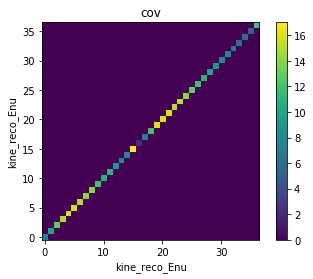

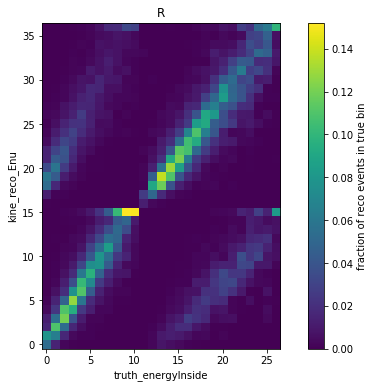

[ 32.8669244   86.47738522 133.41995101 168.96721789 181.5180591
 177.73996143 158.27595159 135.37922488 115.5402948   97.27637993
  78.42643353  65.66156542  47.06910839  34.31994854  27.92499899
 114.18958122   2.71009076  24.28394615  94.16668926 149.40664626
 164.99401353 162.04666109 159.64176985 141.32389336 128.32101643
 105.56899006  90.38369382  69.13493406  59.36882811  51.95609161
  37.82738534  31.53591887  23.15309629  21.07591464  17.01698841
  13.52760333  48.0119888 ]
[ 32.49708903  86.31534867 133.58825274 168.98828056 181.64889745
 177.65023542 158.3030687  135.39485684 115.55124627  97.28251494
  78.42961939  65.66415191  47.07080481  34.32009901  27.92594835
 114.19097708   2.49438496  22.82173476  91.98142075 149.17243714
 165.0790836  161.99494412 159.68240304 141.41189816 128.20745466
 105.61255532  90.42583019  69.15842197  58.98880741  51.76730378
  37.83305932  31.53923397  23.15342123  21.07661511  17.01808127
  13.52809647  48.01333973]
#####################

In [210]:
cov = np.array([[0]*nbins_reco_plot for _ in range(nbins_reco_plot)])
for i in range(len(reco_sel_bined)):
    if constrained:
        cov[i][i] = np.sqrt(m_c[i])
    else:
        cov[i][i] = np.sqrt(reco_sel_bined[i])

fig, ax = plt.subplots()
im = ax.imshow(cov, origin='lower')
cbar = plt.colorbar(im)
ax.set(xlabel=f"{m_variable}", ylabel=f"{m_variable}")
plt.title("cov")
plt.show()

R = [[0]*nbins_truth_plot for _ in range(nbins_reco_plot)]
if Xp_truth:
    len_bin_truth = (max_s-min_s)/nbins_truth
else: #Np0p for truth
    len_bin_truth_Np = (max_s_Np-min_s_Np)/nbins_truth_Np
    len_bin_truth_0p = (max_s_0p-min_s_0p)/nbins_truth_0p
if Xp_reco:
    len_bin_reco = (max_m-min_m)/nbins_reco
else: #Np0p for reco
    len_bin_reco_Np = (max_m_Np-min_m_Np)/nbins_reco_Np
    len_bin_reco_0p = (max_m_0p-min_m_0p)/nbins_reco_0p
    
truth_sig_sel = np.nan_to_num(truth_sig_sel)
reco_sig_sel = np.nan_to_num(reco_sig_sel)
weight = df_sig_sel["net_weight"].to_numpy()
nump = df_sig_sel["num_proton"].to_numpy()
#tnump = df_sig_sel["true_protons"].to_numpy()
tnump = df_sig_sel["num_prim_protons"].to_numpy()
pE = df_sig_sel["truth_max_prim_p_energy"].to_numpy()
for event in range(len(reco_sig_sel)):
    if Xp_truth:
        if truth_sig_sel[event]<min_s:
            if underflow: truth_bin = 0 
            else: continue
        elif truth_sig_sel[event]>max_s:
            if overflow: truth_bin = -1
            else: continue
        else: 
            if use_mbins:
                for b in range(len(mbins)-1):
                    if truth_sig_sel[event]>=mbins[b] and truth_sig_sel[event]<mbins[b+1]: truth_bin = b                   
            else: truth_bin = int(underflow+(truth_sig_sel[event]-min_s)//len_bin_truth)
    else: #N0pTruth
        if tnump[event]>0 and pE[event]>35:#TrueNp
            if truth_sig_sel[event]<min_s_Np:
                if underflow: truth_bin=0
                else: continue 
            elif truth_sig_sel[event]>max_s_Np:
                if overflow: truth_bin = nbins_truth_Np+underflow
                else: continue
            else: 
                if use_mbins:
                    for b in range(len(mbins_Np)):
                        if truth_sig_sel[event]>=mbins_Np[b] and truth_sig_sel[event]<mbins_Np[b+1]: truth_bin = b
                else: truth_bin = int(underflow+(truth_sig_sel[event]-min_s_Np)//len_bin_truth_Np)               
        else:#true0p 
            if truth_sig_sel[event]<min_s_0p:
                if underflow: truth_bin = nbins_truth_Np+underflow+overflow
                else: continue
            elif truth_sig_sel[event]>max_s_0p:
                if overflow: truth_bin = -1
                else: continue
            else: 
                if use_mbins:
                    for b in range(len(mbins_0p)):
                        if truth_sig_sel[event]>=mbins_0p[b] and truth_sig_sel[event]<mbins_0p[b+1]: truth_bin = b+len(mbins_Np)-1
                else: truth_bin = int(2*underflow+overflow+nbins_truth_Np+(truth_sig_sel[event]-min_s_0p)//len_bin_truth_0p)
    if Xp_reco:
        if reco_sig_sel[event]<min_m:
            if underflow: reco_bin = 0
            else: continue
        elif reco_sig_sel[event]>max_m:
            if overflow: reco_bin = -1 
            else: continue
        else: 
            if use_mbins:
                for b in range(len(mbins)-1):
                    if reco_sig_sel[event]>=mbins[b] and reco_sig_sel[event]<mbins[b+1]: reco_bin = b
            else: reco_bin = int(underflow+(reco_sig_sel[event]-min_m)//len_bin_reco)
    else: #Np0preco              
        if nump[event]>0:#recoNp
            if reco_sig_sel[event]<min_m_Np:
                if underflow: reco_bin=0
                else: continue  
            elif reco_sig_sel[event]>max_m_Np:
                if overflow: reco_bin = nbins_reco_Np+underflow  
                else: continue
            else: 
                if use_mbins:
                    for b in range(len(mbins_Np)):
                        if reco_sig_sel[event]>=mbins_Np[b] and reco_sig_sel[event]<mbins_Np[b+1]: reco_bin = b
                else: reco_bin = int(underflow+(reco_sig_sel[event]-min_m_Np)//len_bin_reco_Np)
        else:#reco0p
            if reco_sig_sel[event]<min_m_0p:
                if underflow: reco_bin = underflow+nbins_reco_Np+overflow
                else: continue  
            elif reco_sig_sel[event]>max_m_0p:
                if overflow: reco_bin = -1  
                else: continue
            else: 
                if use_mbins:
                    for b in range(len(mbins_0p)):
                        if reco_sig_sel[event]>=mbins_0p[b] and reco_sig_sel[event]<mbins_0p[b+1]: reco_bin = b + len(mbins_Np)-1
                else: reco_bin = int(2*underflow+overflow+nbins_reco_Np+(reco_sig_sel[event]-min_m_0p)//len_bin_reco_0p)               
    R[reco_bin][truth_bin] += weight[event]

                
column_sums = np.array(R).sum(axis=0)
normalization_factor = 1 / column_sums
normalization_factor = np.nan_to_num(normalization_factor)
R = R * normalization_factor

if Xp_truth:
    if constrained: normalization_factor2 = sig_c
    else: normalization_factor2, _ = np.histogram(df_sig_sel[s_variable].to_numpy(), bins=b_truth, weights=df_sig_sel["net_weight"].to_numpy())
    normalization_factor1, _ = np.histogram(df_sig[s_variable].to_numpy(), bins=b_truth, weights=df_sig["net_weight"].to_numpy())   
else:
    normalization_factor2_Np, _ = np.histogram(df_sig_sel_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sig_sel_Np_true["net_weight"].to_numpy())
    normalization_factor2_0p, _ = np.histogram(df_sig_sel_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sig_sel_0p_true["net_weight"].to_numpy())
    normalization_factor2 = np.hstack((normalization_factor2_Np,normalization_factor2_0p))
    normalization_factor1_Np, _ = np.histogram(df_sig_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sig_Np_true["net_weight"].to_numpy())
    normalization_factor1_0p, _ = np.histogram(df_sig_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sig_0p_true["net_weight"].to_numpy())
    normalization_factor1 = np.hstack((normalization_factor1_Np,normalization_factor1_0p))

normalization_factor = normalization_factor2/normalization_factor1

for i in range(len(normalization_factor)):
    if normalization_factor[i]<0: normalization_factor[i]=0

R = R * normalization_factor

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(R, origin='lower')
cbar = plt.colorbar(im, label='fraction of reco events in true bin')
ax.set(xlabel=f"{s_variable}", ylabel=f"{m_variable}")
plt.title("R")
plt.show()

if Xp_reco:
    bckg_df = df_sel.query(f"not ({sig_query})")
    bckg, _ = np.histogram(bckg_df[m_variable], bins=b_reco, weights=bckg_df["net_weight"].to_numpy())
else:
    #should double click on this here
    #bckg_Np_df = df_sel.query(f"not ({sig_query} and {truthNp_query}) and {recoNp_query}")
    #bckg_0p_df = df_sel.query(f"not ({sig_query} and {truth0p_query}) and {reco0p_query}")
    bckg_Np_df = df_sel.query(f"not ({sig_query}) and {recoNp_query}")
    bckg_0p_df = df_sel.query(f"not ({sig_query}) and {reco0p_query}")
    bckg_Np, _ = np.histogram(bckg_Np_df[m_variable], bins=b_reco_Np, weights=bckg_Np_df["net_weight"].to_numpy())
    bckg_0p, _ = np.histogram(bckg_0p_df[m_variable], bins=b_reco_0p, weights=bckg_0p_df["net_weight"].to_numpy())
    bckg = np.hstack((bckg_Np,bckg_0p))
    

print(reco_sel_bined-bckg)
print((np.matmul(R,truth_sig_bined)))
print("####################################")
if data:
    reco_sel_bined = reco_bined_data
if constrained:
    bckg = bckg_c 
    if not data: reco_sel_bined = m_c
    print("######################")
    truth_sig_bined = sig_c
    print([x-y for x,y in zip(m_c,bckg_c)])
    print((np.matmul(R,sig_c)))  
    
#saving stuff to a root file to put in the framework
with uproot.recreate("wiener.root") as file:

    file["R"] = uproot.newtree({"R": np.double})
    file["R"].extend({"R": R.flatten()})
    file["cov"] = uproot.newtree({"cov":np.double})
    file["cov"].extend({"cov": cov.flatten()})
    
    file["sig"] = uproot.newtree({"sig": np.double})#unused in reweight
    file["sig"].extend({"sig": truth_sel_bined})#unused in reweight
    file["bins"] = uproot.newtree({"bins": np.double})
    file["bins"].extend({"bins":b_truth})
    if not Xp_truth:
        file["Npbins"] = uproot.newtree({"Npbins": np.double})
        file["Npbins"].extend({"Npbins":b_truth_Np+1})
        file["0pbins"] = uproot.newtree({"0pbins": np.double})
        file["0pbins"].extend({"0pbins":b_truth_0p})
    file["meas"] = uproot.newtree({"meas": np.double})
    file["meas"].extend({"meas": reco_sel_bined})
    file["tsig"] = uproot.newtree({"tsig": np.double})#unused in reweight
    file["tsig"].extend({"tsig": truth_sig_sel_bined})#unused in reweight
    file["bckg"] = uproot.newtree({"bckg": np.double})
    file["bckg"].extend({"bckg": bckg})
    
    file["sig_all"] = uproot.newtree({"sig_all": np.double})
    file["sig_all"].extend({"sig_all": truth_sig_bined})
    
    
    

## Reweighting Systematic

In [306]:
#setup for systematic calculation
nbins_reco = 26
nbins_truth = 22
nbins_reco_Np = 15
nbins_truth_Np = 15
nbins_reco_0p = 15
nbins_truth_0p = 15

m_variable = "kine_reco_Enu"
s_variable = "truth_energyInside"

Xp_truth = False
overflow = True
underflow = False 

correlated = True
scale_ncdelta = True
with_ncdelta = True

if scale_ncdelta == True and with_ncdelta == False:
    print("not supported, setting with_ncdelta==True instead.")
    with_ncdelta = True

min_m = 0
max_m = 800
min_s = 0
max_s = 800

min_m_Np = 0
max_m_Np = 1500
min_s_Np = 200
max_s_Np = 1400
min_m_0p = 0
max_m_0p = 1500
min_s_0p = 100
max_s_0p = 800

ncdelta_range = [0,1500]

#ncdelta_scaling = [0.6475,1,1.2378,1] #includes overflow bins
ncdelta_scaling = [0.7688,1,1.0066,1]


re_Xp_truth = False
re_overflow = True
re_underflow = False

nbins_re = 26
nbins_re_Np = 24
nbins_re_0p = 14
re_min = 0
re_max = 1500
re_min_Np = 200
re_max_Np = 1400
re_min_0p = 100
re_max_0p = 800
#re_pi0 = [0.47346, 0.513817, 0.620152, 0.711642, 0.683565, 0.599427, 0.487592, 0.368639, 0.306867, 0.316878, 0.3627, 0.382381, 0.370914, 0.339537, 0.327263, 0.246093,
#      2.18203, 1.99804, 1.8456, 1.85226, 1.88324, 1.8381, 1.62346, 1.321, 1.08835, 1.0664, 1.26347, 1.62921, 2.07742, 2.68451, 3.2522, 2.67171]
re_pi0 = [0.279332, 0.388117, 0.553707, 0.679725, 0.688555, 0.617495, 0.567947, 0.560433, 0.59077, 0.617946, 0.584057, 0.519013, 0.471467, 0.458097, 0.553915, 0.735836, 0.990822, 1.26522, 1.57029, 1.73207, 1.9213, 1.99958, 2.05557, 2.18402, 1,
              1.2466, 1.18207, 1.16923, 1.37165, 1.51289, 1.42552, 1.11135, 0.76296, 0.574159, 0.617545, 0.864722, 1.15229, 1.64071, 2.08024, 1]

sel_query = "nc_pio_score > 1.816 and match_isFC==1 and kine_pio_energy_1 > 0 and kine_pio_energy_2 > 0"
sig_query ="truth_isCC==0 and truth_NprimPio>0"
sig_query_ncdelta = "truth_NCDelta==1"
sel_query_ncdelta = "nc_delta_score > 2.61 and reco_showerKE > 0"
reco0p_query = "num_proton == 0"
recoNp_query = "num_proton > 0"
truth0p_query = "true_protons==0 or truth_max_p_energy<35"
truthNp_query = "true_protons>0 and truth_max_p_energy>=35"




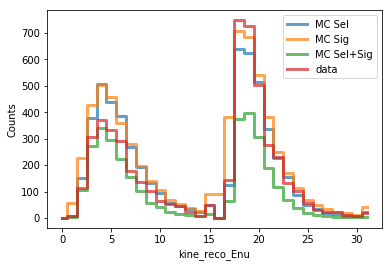

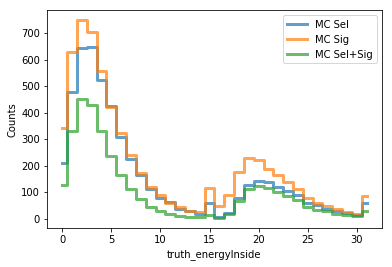

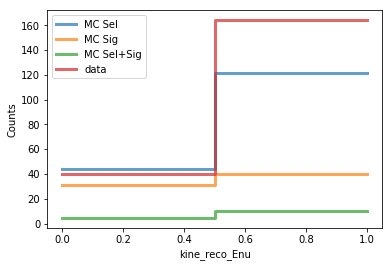

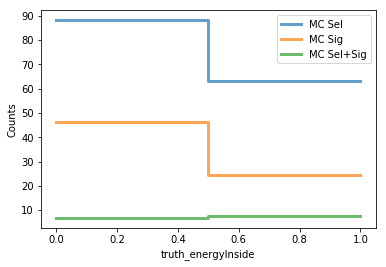

In [307]:
df_data = data_all_df.query(sel_query)
df_sel = all_df.query(sel_query)
df_sig_sel = all_df.query(sig_query).query(sel_query)
df_sig = all_df.query(sig_query)

reco_sel = df_sel[m_variable].to_numpy()
reco_sig_sel = df_sig_sel[m_variable].to_numpy()
reco_sig = df_sig[m_variable].to_numpy()
reco_data = df_data[m_variable].to_numpy()
truth_sel = df_sel[s_variable].to_numpy()
truth_sig_sel = df_sig_sel[s_variable].to_numpy()
truth_sig = df_sig[s_variable].to_numpy()

if Xp_truth:     
    b_truth = np.linspace(min_s, max_s, nbins_truth+1)   
    nbins_truth_plot = nbins_truth
    for x in range(len(extra_bins)):
        b_truth = np.append(b_truth,extra_bins[x])
        nbins_truth_plot+=1
    if overflow:
        b_truth = np.append(b_truth,1000000)
        nbins_truth_plot +=1
    if underflow:
        b_truth = np.insert(b_truth,0,-100000)
        nbins_truth_plot +=1
    truth_sel_bined, _ = np.histogram(truth_sel, bins=b_truth, weights=df_sel["net_weight"].to_numpy())
    truth_sig_sel_bined, _ = np.histogram(truth_sig_sel, bins=b_truth, weights=df_sig_sel["net_weight"].to_numpy())
    truth_sig_bined, _ = np.histogram(truth_sig, bins=b_truth, weights=df_sig["net_weight"].to_numpy()) 
else: #np0p for truth 
    b_truth_Np = np.linspace(min_s_Np, max_s_Np, nbins_truth_Np+1)
    b_truth_0p = np.linspace(min_s_0p, max_s_0p, nbins_truth_0p+1)
    nbins_truth_plot = nbins_truth_Np+nbins_truth_0p
    if overflow:
        b_truth_Np = np.append(b_truth_Np,1000000)
        b_truth_0p = np.append(b_truth_0p,1000000)
        nbins_truth_plot +=2
    if underflow:
        b_truth_Np = np.insert(b_truth_Np,0,-100000)
        b_truth_0p = np.insert(b_truth_0p,0,-100000)
        nbins_truth_plot +=2
    b_truth =np.hstack((b_truth_Np,b_truth_0p))
    df_sel_Np_true = df_sel.query(truthNp_query)
    df_sel_0p_true = df_sel.query(truth0p_query)
    df_sig_Np_true = df_sig.query(truthNp_query)
    df_sig_0p_true = df_sig.query(truth0p_query)
    df_sig_sel_Np_true = df_sig_sel.query(truthNp_query)
    df_sig_sel_0p_true = df_sig_sel.query(truth0p_query)
    
    truth_sel_bined_Np, _ = np.histogram(df_sel_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sel_Np_true["net_weight"].to_numpy())
    truth_sel_bined_0p, _ = np.histogram(df_sel_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sel_0p_true["net_weight"].to_numpy())
    truth_sel_bined = np.hstack((truth_sel_bined_Np,truth_sel_bined_0p)) 
    truth_sig_bined_Np, _ = np.histogram(df_sig_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sig_Np_true["net_weight"].to_numpy())
    truth_sig_bined_0p, _ = np.histogram(df_sig_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sig_0p_true["net_weight"].to_numpy())
    truth_sig_bined = np.hstack((truth_sig_bined_Np,truth_sig_bined_0p))
    truth_sig_sel_bined_Np, _ = np.histogram(df_sig_sel_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sig_sel_Np_true["net_weight"].to_numpy())
    truth_sig_sel_bined_0p, _ = np.histogram(df_sig_sel_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sig_sel_0p_true["net_weight"].to_numpy())
    truth_sig_sel_bined = np.hstack((truth_sig_sel_bined_Np,truth_sig_sel_bined_0p))
        
if Xp_reco:
    b_reco = np.linspace(min_m, max_m, nbins_reco+1)
    nbins_reco_plot = nbins_reco
    if overflow:
        b_reco = np.append(b_reco,1000000)
        nbins_reco_plot +=1
    if underflow:
        b_reco = np.insert(b_reco,0,-100000)
        nbins_reco_plot +=1
    reco_sel_bined, _ = np.histogram(reco_sel, bins=b_reco, weights=df_sel["net_weight"].to_numpy())    
    reco_sig_sel_bined, _ = np.histogram(reco_sig_sel, bins=b_reco, weights=df_sig_sel["net_weight"].to_numpy())
    reco_sig_bined, _ = np.histogram(reco_sig, bins=b_reco, weights=df_sig["net_weight"].to_numpy())
    reco_bined_data, _ = np.histogram(reco_data, bins=b_reco)
else: #Np0p for reco
    b_reco_Np = np.linspace(min_m_Np, max_m_Np, nbins_reco_Np+1)  
    b_reco_0p = np.linspace(min_m_0p, max_m_0p, nbins_reco_0p+1) 
    nbins_reco_plot = nbins_reco_Np+nbins_reco_0p
    if overflow:
        b_reco_Np = np.append(b_reco_Np,1000000)
        b_reco_0p = np.append(b_reco_0p,1000000)
        nbins_reco_plot +=2
    if underflow:
        b_reco_Np = np.insert(b_reco_Np,0,-100000)
        b_reco_0p = np.insert(b_reco_0p,0,-100000)
        nbins_reco_plot +=2
    b_reco = np.hstack((b_reco_Np,b_reco_0p))
    df_sel_Np = df_sel.query(recoNp_query)
    df_sel_0p = df_sel.query(reco0p_query)
    df_sig_Np = df_sig.query(recoNp_query)
    df_sig_0p = df_sig.query(reco0p_query)
    df_sig_sel_Np = df_sig_sel.query(recoNp_query)
    df_sig_sel_0p = df_sig_sel.query(reco0p_query) 
    reco_sel_bined_Np, _ = np.histogram(df_sel_Np[m_variable].to_numpy(), bins=b_reco_Np, weights=df_sel_Np["net_weight"].to_numpy())
    reco_sel_bined_0p, _ = np.histogram(df_sel_0p[m_variable].to_numpy(), bins=b_reco_0p, weights=df_sel_0p["net_weight"].to_numpy())
    reco_sel_bined = np.hstack((reco_sel_bined_Np,reco_sel_bined_0p)) 
    reco_sig_bined_Np, _ = np.histogram(df_sig_Np[m_variable].to_numpy(), bins=b_reco_Np, weights=df_sig_Np["net_weight"].to_numpy())
    reco_sig_bined_0p, _ = np.histogram(df_sig_0p[m_variable].to_numpy(), bins=b_reco_0p, weights=df_sig_0p["net_weight"].to_numpy())
    reco_sig_bined = np.hstack((reco_sig_bined_Np,reco_sig_bined_0p))
    reco_sig_sel_bined_Np, _ = np.histogram(df_sig_sel_Np[m_variable].to_numpy(), bins=b_reco_Np, weights=df_sig_sel_Np["net_weight"].to_numpy())
    reco_sig_sel_bined_0p, _ = np.histogram(df_sig_sel_0p[m_variable].to_numpy(), bins=b_reco_0p, weights=df_sig_sel_0p["net_weight"].to_numpy())
    reco_sig_sel_bined = np.hstack((reco_sig_sel_bined_Np,reco_sig_sel_bined_0p))
    
    df_Np_data = df_data.query(recoNp_query)
    df_0p_data = df_data.query(reco0p_query)
    reco_binedNp_data, _ = np.histogram(df_Np_data[m_variable].to_numpy(), bins=b_reco_Np)
    reco_bined0p_data, _ = np.histogram(df_0p_data[m_variable].to_numpy(), bins=b_reco_0p)
    reco_bined_data = np.hstack((reco_binedNp_data,reco_bined0p_data))

#plotting the distributions as a check
fig, ax = plt.subplots()
ax.step(np.arange(nbins_reco_plot), reco_sel_bined, where='mid', lw=3,
        alpha=0.7, label='MC Sel')
ax.step(np.arange(nbins_reco_plot), reco_sig_bined, where='mid', lw=3,
        alpha=0.7, label='MC Sig')
ax.step(np.arange(nbins_reco_plot), reco_sig_sel_bined, where='mid', lw=3,
        alpha=0.7, label='MC Sel+Sig')
ax.step(np.arange(nbins_reco_plot), reco_bined_data, where='mid', lw=3,
       alpha=0.7, label='data')
ax.set(xlabel=f'{m_variable}', ylabel='Counts')
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.step(np.arange(nbins_truth_plot), truth_sel_bined, where='mid', lw=3,
        alpha=0.7, label='MC Sel')
ax.step(np.arange(nbins_truth_plot), truth_sig_bined, where='mid', lw=3,
        alpha=0.7, label='MC Sig')
ax.step(np.arange(nbins_truth_plot), truth_sig_sel_bined, where='mid', lw=3,
        alpha=0.7, label='MC Sel+Sig')
ax.set(xlabel=f'{s_variable}', ylabel='Counts')
ax.legend()
plt.show()



R = [[0]*nbins_truth_plot for _ in range(nbins_reco_plot)]
if with_ncdelta:
    if Xp_reco: nbins_reco_plot+=2
    else: nbins_reco_plot+=4
    if scale_ncdelta: nbins_truth_plot+=4
    R = [[0]*nbins_truth_plot for _ in range(nbins_reco_plot)]
    
    #do the selection for nc delta
    df_data_ncdelta = data_all_df.query(sel_query_ncdelta)
    df_sel_ncdelta = all_df.query(sel_query_ncdelta)
    df_sig_sel_ncdelta = all_df.query(sig_query_ncdelta).query(sel_query_ncdelta)
    df_sig_ncdelta = all_df.query(sig_query_ncdelta)
    
    reco_sel_bined_ncdelta_Np, _ = np.histogram(df_sel_ncdelta.query(recoNp_query)[m_variable].to_numpy(), bins=ncdelta_range, weights=df_sel_ncdelta.query(recoNp_query)["net_weight"].to_numpy())
    reco_sig_sel_bined_ncdelta_Np, _ = np.histogram(df_sig_sel_ncdelta.query(recoNp_query)[m_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_sel_ncdelta.query(recoNp_query)["net_weight"].to_numpy())
    reco_sig_bined_ncdelta_Np, _ = np.histogram(df_sig_ncdelta.query(recoNp_query)[m_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_ncdelta.query(recoNp_query)["net_weight"].to_numpy())
    truth_sel_bined_ncdelta_Np, _ = np.histogram(df_sel_ncdelta.query(truthNp_query)[s_variable].to_numpy(), bins=ncdelta_range, weights=df_sel_ncdelta.query(truthNp_query)["net_weight"].to_numpy())
    truth_sig_sel_bined_ncdelta_Np, _ = np.histogram(df_sig_sel_ncdelta.query(truthNp_query)[s_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_sel_ncdelta.query(truthNp_query)["net_weight"].to_numpy())
    truth_sig_bined_ncdelta_Np, _ = np.histogram(df_sig_ncdelta.query(truthNp_query)[s_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_ncdelta.query(truthNp_query)["net_weight"].to_numpy())
    reco_sel_bined_ncdelta_0p, _ = np.histogram(df_sel_ncdelta.query(reco0p_query)[m_variable].to_numpy(), bins=ncdelta_range, weights=df_sel_ncdelta.query(reco0p_query)["net_weight"].to_numpy())
    reco_sig_sel_bined_ncdelta_0p, _ = np.histogram(df_sig_sel_ncdelta.query(reco0p_query)[m_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_sel_ncdelta.query(reco0p_query)["net_weight"].to_numpy())
    reco_sig_bined_ncdelta_0p, _ = np.histogram(df_sig_ncdelta.query(reco0p_query)[m_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_ncdelta.query(reco0p_query)["net_weight"].to_numpy())
    truth_sel_bined_ncdelta_0p, _ = np.histogram(df_sel_ncdelta.query(truth0p_query)[s_variable].to_numpy(), bins=ncdelta_range, weights=df_sel_ncdelta.query(truth0p_query)["net_weight"].to_numpy())
    truth_sig_sel_bined_ncdelta_0p, _ = np.histogram(df_sig_sel_ncdelta.query(truth0p_query)[s_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_sel_ncdelta.query(truth0p_query)["net_weight"].to_numpy())
    truth_sig_bined_ncdelta_0p, _ = np.histogram(df_sig_ncdelta.query(truth0p_query)[s_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_ncdelta.query(truth0p_query)["net_weight"].to_numpy())
    
    reco_sel_bined_ncdelta = np.hstack((reco_sel_bined_ncdelta_Np,reco_sel_bined_ncdelta_0p))
    reco_sig_sel_bined_ncdelta = np.hstack((reco_sig_sel_bined_ncdelta_Np,reco_sig_sel_bined_ncdelta_0p))
    reco_sig_bined_ncdelta = np.hstack((reco_sig_bined_ncdelta_Np,reco_sig_bined_ncdelta_0p))
    truth_sel_bined_ncdelta = np.hstack((truth_sel_bined_ncdelta_Np,truth_sel_bined_ncdelta_0p))
    truth_sig_sel_bined_ncdelta = np.hstack((truth_sig_sel_bined_ncdelta_Np,truth_sig_sel_bined_ncdelta_0p))
    truth_sig_bined_ncdelta = np.hstack((truth_sig_bined_ncdelta_Np,truth_sig_bined_ncdelta_0p))
                                        
    reco_binedNp_data_ncdelta, _ = np.histogram(df_data_ncdelta.query(recoNp_query)[m_variable].to_numpy(), bins=ncdelta_range)
    reco_bined0p_data_ncdelta, _ = np.histogram(df_data_ncdelta.query(reco0p_query)[m_variable].to_numpy(), bins=ncdelta_range)
    reco_bined_data_ncdelta = np.hstack((reco_binedNp_data_ncdelta,reco_bined0p_data_ncdelta))
                                                
    fig, ax = plt.subplots()
    ax.step(np.arange(2), reco_sel_bined_ncdelta, where='mid', lw=3,
        alpha=0.7, label='MC Sel')
    ax.step(np.arange(2), reco_sig_bined_ncdelta, where='mid', lw=3,
        alpha=0.7, label='MC Sig')
    ax.step(np.arange(2), reco_sig_sel_bined_ncdelta, where='mid', lw=3,
        alpha=0.7, label='MC Sel+Sig')
    ax.step(np.arange(2), reco_bined_data_ncdelta, where='mid', lw=3,
       alpha=0.7, label='data')
    ax.set(xlabel=f'{m_variable}', ylabel='Counts')
    ax.legend()
    plt.show()
    
    fig, ax = plt.subplots()
    ax.step(np.arange(2), truth_sel_bined_ncdelta, where='mid', lw=3,
        alpha=0.7, label='MC Sel')
    ax.step(np.arange(2), truth_sig_bined_ncdelta, where='mid', lw=3,
        alpha=0.7, label='MC Sig')
    ax.step(np.arange(2), truth_sig_sel_bined_ncdelta, where='mid', lw=3,
        alpha=0.7, label='MC Sel+Sig')
    ax.set(xlabel=f'{s_variable}', ylabel='Counts')
    ax.legend()
    plt.show()
    
    truth_sig_sel_bined_ncdelta_Np_Np, _ = np.histogram(df_sig_sel_ncdelta.query(truthNp_query).query(recoNp_query)[s_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_sel_ncdelta.query(truthNp_query).query(recoNp_query)["net_weight"].to_numpy())
    truth_sig_sel_bined_ncdelta_0p_0p, _ = np.histogram(df_sig_sel_ncdelta.query(truth0p_query).query(reco0p_query)[s_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_sel_ncdelta.query(truth0p_query).query(reco0p_query)["net_weight"].to_numpy())
    reco_sig_sel_bined_ncdelta_Np_Np, _ = np.histogram(df_sig_sel_ncdelta.query(truthNp_query).query(recoNp_query)[m_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_sel_ncdelta.query(truthNp_query).query(recoNp_query)["net_weight"].to_numpy())
    reco_sig_sel_bined_ncdelta_0p_0p, _ = np.histogram(df_sig_sel_ncdelta.query(truth0p_query).query(reco0p_query)[m_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_sel_ncdelta.query(truth0p_query).query(reco0p_query)["net_weight"].to_numpy())

[3.14674945e+01 4.66813995e-04 7.07459790e+01 0.00000000e+00
 0.00000000e+00 4.41543524e+00 1.04778450e+02 2.73185792e+02
 3.42459803e+02 2.96780760e+02 2.24196190e+02 1.54274982e+02
 1.01031453e+02 5.87022623e+01 4.17503647e+01 2.43867103e+01
 1.63900657e+01 9.77050494e+00 7.35356057e+00 1.49631476e+01
 3.79169414e-02 5.90430183e+01 3.70962010e+02 3.97995085e+02
 3.07491400e+02 1.91393433e+02 1.19301060e+02 6.70181269e+01
 3.97815582e+01 1.71489792e+01 1.14236227e+01 6.00163067e+00
 4.13390835e+00 2.93947870e+00 2.07701275e+00 4.49809885e+00]


C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:127: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in true_divide


[0.4010328         nan 0.52973103        nan 0.3692861  0.5374126
 0.61551911 0.6263235  0.60749118 0.57169646 0.52274534 0.4834935
 0.43212613 0.36908591 0.34810053 0.28250062 0.26989261 0.21646231
 0.20474481 0.12324871 0.05057553 0.18189251 0.38820835 0.51636383
 0.5929608  0.64171956 0.65670552 0.67135443 0.66899029 0.63225306
 0.60752806 0.61246348 0.5168332  0.527969   0.4826204  0.33214968]
[3.14674945e+01 4.66813995e-04 7.07459790e+01 0.00000000e+00
 0.00000000e+00 4.41543524e+00 1.04778450e+02 2.73185792e+02
 3.42459803e+02 2.96780760e+02 2.24196190e+02 1.54274982e+02
 1.01031453e+02 5.87022623e+01 4.17503647e+01 2.43867103e+01
 1.63895298e+01 9.76843050e+00 7.35309376e+00 1.49520649e+01
 3.79169414e-02 5.90430183e+01 3.70962010e+02 3.97995085e+02
 3.07491400e+02 1.91393433e+02 1.19301060e+02 6.70181269e+01
 3.97815582e+01 1.71489792e+01 1.14236227e+01 6.00163067e+00
 4.13390835e+00 2.93901188e+00 2.07701275e+00 4.49709616e+00]


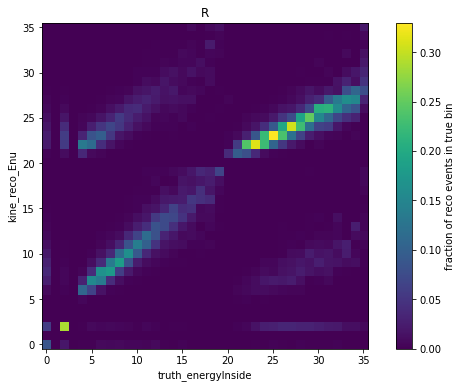

In [308]:
if Xp_truth:
    len_bin_truth = (max_s-min_s)/nbins_truth
else: #Np0p for truth
    len_bin_truth_Np = (max_s_Np-min_s_Np)/nbins_truth_Np
    len_bin_truth_0p = (max_s_0p-min_s_0p)/nbins_truth_0p

len_bin_reco_Np = (max_m_Np-min_m_Np)/nbins_reco_Np
len_bin_reco_0p = (max_m_0p-min_m_0p)/nbins_reco_0p

if with_ncdelta:
    #create the new response matrix
    df_R = all_df.copy()
    if scale_ncdelta:
        df_R_reco_pi0 = df_R.query(sig_query).query(sel_query)
        df_R_reco_pi0["pi0_sel"] = [1 for i in range(df_R_reco_pi0.shape[0])]
        df_R_reco_pi0["pi0_sig"] = [1 for i in range(df_R_reco_pi0.shape[0])]
        df_R_reco_ncdelta = df_R.query(sig_query).query(sel_query_ncdelta)
        df_R_reco_ncdelta["pi0_sel"] = [0 for i in range(df_R_reco_ncdelta.shape[0])]
        df_R_reco_ncdelta["pi0_sig"] = [1 for i in range(df_R_reco_ncdelta.shape[0])]
        
        df_R_ncdelta_reco_pi0 = df_R.query(sig_query_ncdelta).query(sel_query)
        df_R_ncdelta_reco_pi0["pi0_sel"] = [1 for i in range(df_R_ncdelta_reco_pi0.shape[0])]
        df_R_ncdelta_reco_pi0["pi0_sig"] = [0 for i in range(df_R_ncdelta_reco_pi0.shape[0])]
        df_R_ncdelta_reco_ncdelta = df_R.query(sig_query_ncdelta).query(sel_query_ncdelta)
        df_R_ncdelta_reco_ncdelta["pi0_sel"] = [0 for i in range(df_R_ncdelta_reco_ncdelta.shape[0])]
        df_R_ncdelta_reco_ncdelta["pi0_sig"] = [0 for i in range(df_R_ncdelta_reco_ncdelta.shape[0])]
        
        df_R = pd.concat([df_R_ncdelta_reco_pi0,df_R_ncdelta_reco_ncdelta,df_R_reco_pi0,df_R_reco_ncdelta])
    
    elif with_ncdelta:
        df_R_reco_pi0 = df_R.query(sig_query).query(sel_query)
        df_R_reco_pi0["pi0_sel"] = [1 for i in range(df_R_reco_pi0.shape[0])]
        df_R_reco_pi0["pi0_sig"] = [1 for i in range(df_R_reco_pi0.shape[0])]
        df_R_reco_ncdelta = df_R.query(sig_query).query(sel_query_ncdelta)
        df_R_reco_ncdelta["pi0_sel"] = [0 for i in range(df_R_reco_ncdelta.shape[0])]
        df_R_reco_ncdelta["pi0_sig"] = [1 for i in range(df_R_reco_ncdelta.shape[0])]
        df_R = pd.concat([df_R_reco_pi0,df_R_reco_ncdelta])
    truth_R = df_R[s_variable].to_numpy()
    reco_R = df_R[m_variable].to_numpy()
    weight = df_R["net_weight"].to_numpy()
    nump = df_R["num_proton"].to_numpy()
    tnump =  df_R["true_protons"].to_numpy()
    pE = df_R["truth_max_p_energy"].to_numpy()
    reco_ncpi0 = df_R["pi0_sel"].to_numpy()
    true_ncpi0 = df_R["pi0_sig"].to_numpy()
    for event in range(len(reco_R)):
        if scale_ncdelta:
            if true_ncpi0[event] == 1: #reco ncpi0
                if tnump[event]>0 and pE[event]>35:
                    if truth_R[event]<min_s_Np:
                        if underflow: truth_bin=4
                        else: continue 
                    elif truth_R[event]>max_s_Np:
                        if overflow: truth_bin = 4+nbins_truth_Np+underflow
                        else: continue
                    else: truth_bin = int(4+underflow+(truth_R[event]-min_s_Np)//len_bin_truth_Np)               
                else:#true0p 
                    if truth_R[event]<min_s_0p:
                        if underflow: truth_bin = 4+nbins_truth_Np+underflow+overflow
                        else: continue
                    elif truth_R[event]>max_s_0p:
                        if overflow: truth_bin = -1
                        else: continue
                    else: truth_bin = int(4+2*underflow+overflow+nbins_truth_Np+(truth_R[event]-min_s_0p)//len_bin_truth_0p)
            elif truth_R[event]<=ncdelta_range[1] and truth_R[event]>=ncdelta_range[0]: #reco ncdelta
                if tnump[event]>0 and pE[event]>35: truth_bin=0 #ncdeltaNp
                else: truth_bin=2 #ncdelta0p
            else: #ncdelta outside of range
                if tnump[event]>0 and pE[event]>35: truth_bin=1 #ncdeltaNp
                else: truth_bin=3 #ncdelta0p
        else: #no nc delta scaling
            if tnump[event]>0 and pE[event]>35:
                if truth_R[event]<min_s_Np:
                    if underflow: truth_bin=0
                    else: continue 
                elif truth_R[event]>max_s_Np:
                    if overflow: truth_bin = nbins_truth_Np+underflow
                    else: continue
                else: truth_bin = int(underflow+(truth_R[event]-min_s_Np)//len_bin_truth_Np)               
            else:#true0p 
                if truth_R[event]<min_s_0p:
                    if underflow: truth_bin = nbins_truth_Np+underflow+overflow
                    else: continue
                elif truth_R[event]>max_s_0p:
                    if overflow: truth_bin = -1
                    else: continue
                else: truth_bin = int(2*underflow+overflow+nbins_truth_Np+(truth_R[event]-min_s_0p)//len_bin_truth_0p)
        if Xp_reco:
            if reco_ncpi0[event] == 1: #reco ncpi0
                if reco_R[event]<min_m:
                    if underflow: reco_bin = 2
                    else: continue
                elif reco_R[event]>max_m:
                    if overflow: reco_bin = -1 
                    else: continue
                else: reco_bin = int(2+underflow+(reco_R[event]-min_m)//len_bin_reco)
            elif reco_R[event]<=ncdelta_range[1] and reco_R[event]>=ncdelta_range[0]: reco_bin = 0 #reco ncdelta
            else: reco_bin = 1 #ncdelta outside of rangetruth_R
        else: #Np0preco  
            if reco_ncpi0[event] == 1: #reco ncpi0
                if nump[event]>0:#recoNp
                    if reco_R[event]<min_m_Np:
                        if underflow: reco_bin=4
                        else: continue  
                    elif reco_R[event]>max_m_Np:
                        if overflow: reco_bin = 4+nbins_reco_Np+underflow  
                        else: continue
                    else: reco_bin = int(4+underflow+(reco_R[event]-min_m_Np)//len_bin_reco_Np)
                else:#reco0p
                    if reco_R[event]<min_m_0p:
                        if underflow: reco_bin = 4+underflow+nbins_reco_Np+overflow
                        else: continue  
                    elif reco_R[event]>max_m_0p:
                        if overflow: reco_bin = -1  
                        else: continue
                    else: reco_bin = int(4+2*underflow+overflow+nbins_reco_Np+(reco_R[event]-min_m_0p)//len_bin_reco_0p)  
            elif reco_R[event]<=ncdelta_range[1] and reco_R[event]>=ncdelta_range[0]: #reco ncdelta
                if nump[event]>0: reco_bin=0 #ncdeltaNp
                else: reco_bin=2 #ncdelta0p
            else: #ncdelta outside of range
                if nump[event]>0: reco_bin=1 #ncdeltaNp
                else: reco_bin=3 #ncdelta0p
        R[reco_bin][truth_bin] += weight[event]
        
    column_sums = np.array(R).sum(axis=0)
    print(np.array(R).sum(axis=1))
    normalization_factor = 1 / column_sums
    normalization_factor = np.nan_to_num(normalization_factor)
    R = R * normalization_factor
    
    
    if scale_ncdelta:
        normalization_factor1_Np, _ = np.histogram(df_sig_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sig_Np_true["net_weight"].to_numpy())
        normalization_factor1_0p, _ = np.histogram(df_sig_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sig_0p_true["net_weight"].to_numpy())
        normalization_factor1_Np_tncdelta, _ = np.histogram(df_sig_ncdelta.query(truthNp_query)[s_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_ncdelta.query(truthNp_query)["net_weight"].to_numpy())
        normalization_factor1_0p_tncdelta, _ = np.histogram(df_sig_ncdelta.query(truth0p_query)[s_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_ncdelta.query(truth0p_query)["net_weight"].to_numpy())
        normalization_factor1 = np.concatenate((normalization_factor1_Np_tncdelta,[0],normalization_factor1_0p_tncdelta,[0],normalization_factor1_Np,normalization_factor1_0p))
        
        normalization_factor2_Np, _ = np.histogram(df_sig_sel_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sig_sel_Np_true["net_weight"].to_numpy())
        normalization_factor2_0p, _ = np.histogram(df_sig_sel_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sig_sel_0p_true["net_weight"].to_numpy())
        normalization_factor2_Np_tncdelta, _ = np.histogram(df_sel.query(truthNp_query).query(sig_query_ncdelta)[s_variable].to_numpy(), bins=ncdelta_range, weights=df_sel.query(truthNp_query).query(sig_query_ncdelta)["net_weight"].to_numpy())
        normalization_factor2_0p_tncdelta, _ = np.histogram(df_sel.query(truth0p_query).query(sig_query_ncdelta)[s_variable].to_numpy(), bins=ncdelta_range, weights=df_sel.query(truth0p_query).query(sig_query_ncdelta)["net_weight"].to_numpy())
        normalization_factor2 = np.concatenate((normalization_factor2_Np_tncdelta,[0],normalization_factor2_0p_tncdelta,[0],normalization_factor2_Np,normalization_factor2_0p))        
        
        ncdelta_normalization_factor2_Np, _ = np.histogram(df_sel_ncdelta.query(truthNp_query).query(sig_query)[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sel_ncdelta.query(truthNp_query).query(sig_query)["net_weight"].to_numpy())
        ncdelta_normalization_factor2_0p, _ = np.histogram(df_sel_ncdelta.query(truth0p_query).query(sig_query)[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sel_ncdelta.query(truth0p_query).query(sig_query)["net_weight"].to_numpy())
        ncdelta_normalization_factor2_Np_tncdelta, _ = np.histogram(df_sig_sel_ncdelta.query(truthNp_query)[s_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_sel_ncdelta.query(truthNp_query)["net_weight"].to_numpy())
        ncdelta_normalization_factor2_0p_tncdelta, _ = np.histogram(df_sig_sel_ncdelta.query(truth0p_query)[s_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_sel_ncdelta.query(truth0p_query)["net_weight"].to_numpy())
        ncdelta_normalization_factor2 = np.concatenate((ncdelta_normalization_factor2_Np_tncdelta,[0],ncdelta_normalization_factor2_0p_tncdelta,[0],ncdelta_normalization_factor2_Np,ncdelta_normalization_factor2_0p))
        
        normalization_factor2 = normalization_factor2+ncdelta_normalization_factor2
        
        normalization_factor = normalization_factor2/normalization_factor1

        print(normalization_factor)
        
    else:  
        normalization_factor2_Np, _ = np.histogram(df_sig_sel_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sig_sel_Np_true["net_weight"].to_numpy())
        normalization_factor2_0p, _ = np.histogram(df_sig_sel_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sig_sel_0p_true["net_weight"].to_numpy())
        normalization_factor2 = np.concatenate((normalization_factor2_Np,normalization_factor2_0p))
        normalization_factor1_Np, _ = np.histogram(df_sig_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sig_Np_true["net_weight"].to_numpy())
        normalization_factor1_0p, _ = np.histogram(df_sig_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sig_0p_true["net_weight"].to_numpy())
        normalization_factor1 = np.concatenate((normalization_factor1_Np,normalization_factor1_0p))     
        
        ncdelta_normalization_factor2_Np, _ = np.histogram(df_sel_ncdelta.query(truthNp_query).query(sig_query)[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sel_ncdelta.query(truthNp_query).query(sig_query)["net_weight"].to_numpy())
        ncdelta_normalization_factor2_0p, _ = np.histogram(df_sel_ncdelta.query(truth0p_query).query(sig_query)[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sel_ncdelta.query(truth0p_query).query(sig_query)["net_weight"].to_numpy())
        ncdelta_normalization_factor2 = np.concatenate((ncdelta_normalization_factor2_Np,ncdelta_normalization_factor2_0p))
        
        normalization_factor2 = normalization_factor2+ncdelta_normalization_factor2
        
        normalization_factor = normalization_factor2/normalization_factor1
        
        print(normalization_factor)
        
    for i in range(len(normalization_factor)):
        if normalization_factor[i]<0: normalization_factor[i]=0
    normalization_factor = np.nan_to_num(normalization_factor)
    
    R = R * normalization_factor           
    
    if scale_ncdelta:
        tsig_binedNp, _ = np.histogram(df_sig_ncdelta.query(truthNp_query)[s_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_ncdelta.query(truthNp_query)["net_weight"].to_numpy())
        tsig_bined0p, _ = np.histogram(df_sig_ncdelta.query(truth0p_query)[s_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_ncdelta.query(truth0p_query)["net_weight"].to_numpy())
        tsig_bined = np.concatenate((tsig_binedNp,[0],tsig_bined0p,[0],truth_sig_bined))
        print((np.matmul(R,tsig_bined)))
    else:print((np.matmul(R,truth_sig_bined)))

        
else:
    R = [[0]*nbins_truth_plot for _ in range(nbins_reco_plot)]
    if Xp_truth:
        len_bin_truth = (max_s-min_s)/nbins_truth
    else: #Np0p for truth
        len_bin_truth_Np = (max_s_Np-min_s_Np)/nbins_truth_Np
        len_bin_truth_0p = (max_s_0p-min_s_0p)/nbins_truth_0p
    if Xp_reco:
        len_bin_reco = (max_m-min_m)/nbins_reco
    else: #Np0p for reco
        len_bin_reco_Np = (max_m_Np-min_m_Np)/nbins_reco_Np
        len_bin_reco_0p = (max_m_0p-min_m_0p)/nbins_reco_0p

    truth_sig_sel = np.nan_to_num(truth_sig_sel)
    reco_sig_sel = np.nan_to_num(reco_sig_sel)
    weight = df_sig_sel["net_weight"].to_numpy()
    nump = df_sig_sel["num_proton"].to_numpy()
    tnump = df_sig_sel["true_protons"].to_numpy()
    pE = df_sig_sel["truth_max_p_energy"].to_numpy()
    for event in range(len(reco_sig_sel)):
        if Xp_truth:
            if truth_sig_sel[event]<min_s:
                if underflow: truth_bin = 0 
                else: continue
            elif truth_sig_sel[event]>max_s:
                if overflow: truth_bin = -1
                else: continue
            else: truth_bin = int(underflow+(truth_sig_sel[event]-min_s)//len_bin_truth)
        else: #N0pTruth
            if tnump[event]>0 and pE[event]>35:#TrueNp
                if truth_sig_sel[event]<min_s_Np:
                    if underflow: truth_bin=0
                    else: continue 
                elif truth_sig_sel[event]>max_s_Np:
                    if overflow: truth_bin = nbins_truth_Np+underflow
                    else: continue
                else: truth_bin = int(underflow+(truth_sig_sel[event]-min_s_Np)//len_bin_truth_Np)               
            else:#true0p 
                if truth_sig_sel[event]<min_s_0p:
                    if underflow: truth_bin = nbins_truth_Np+underflow+overflow
                    else: continue
                elif truth_sig_sel[event]>max_s_0p:
                    if overflow: truth_bin = -1
                    else: continue
                else: truth_bin = int(2*underflow+overflow+nbins_truth_Np+(truth_sig_sel[event]-min_s_0p)//len_bin_truth_0p)
        if Xp_reco:
            if reco_sig_sel[event]<min_m:
                if underflow: reco_bin = 0
                else: continue
            elif reco_sig_sel[event]>max_m:
                if overflow: reco_bin = -1 
                else: continue
            else: reco_bin = int(underflow+(reco_sig_sel[event]-min_m)//len_bin_reco)
        else: #Np0preco              
            if nump[event]>0:#recoNp
                if reco_sig_sel[event]<min_m_Np:
                    if underflow: reco_bin=0
                    else: continue  
                elif reco_sig_sel[event]>max_m_Np:
                    if overflow: reco_bin = nbins_reco_Np+underflow  
                    else: continue
                else: reco_bin = int(underflow+(reco_sig_sel[event]-min_m_Np)//len_bin_reco_Np)
            else:#reco0p
                if reco_sig_sel[event]<min_m_0p:
                    if underflow: reco_bin = underflow+nbins_reco_Np+overflow
                    else: continue  
                elif reco_sig_sel[event]>max_m_0p:
                    if overflow: reco_bin = -1  
                    else: continue
                else: reco_bin = int(2*underflow+overflow+nbins_reco_Np+(reco_sig_sel[event]-min_m_0p)//len_bin_reco_0p)               
        R[reco_bin][truth_bin] += weight[event]


    column_sums = np.array(R).sum(axis=0)
    normalization_factor = 1 / column_sums
    normalization_factor = np.nan_to_num(normalization_factor)
    R = R * normalization_factor

    if Xp_truth:
        if constrained: normalization_factor2 = sig_c
        else: normalization_factor2, _ = np.histogram(df_sig_sel[s_variable].to_numpy(), bins=b_truth, weights=df_sig_sel["net_weight"].to_numpy())
        normalization_factor1, _ = np.histogram(df_sig[s_variable].to_numpy(), bins=b_truth, weights=df_sig["net_weight"].to_numpy())   
    else:
        normalization_factor2_Np, _ = np.histogram(df_sig_sel_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sig_sel_Np_true["net_weight"].to_numpy())
        normalization_factor2_0p, _ = np.histogram(df_sig_sel_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sig_sel_0p_true["net_weight"].to_numpy())
        normalization_factor2 = np.hstack((normalization_factor2_Np,normalization_factor2_0p))
        normalization_factor1_Np, _ = np.histogram(df_sig_Np_true[s_variable].to_numpy(), bins=b_truth_Np, weights=df_sig_Np_true["net_weight"].to_numpy())
        normalization_factor1_0p, _ = np.histogram(df_sig_0p_true[s_variable].to_numpy(), bins=b_truth_0p, weights=df_sig_0p_true["net_weight"].to_numpy())
        normalization_factor1 = np.hstack((normalization_factor1_Np,normalization_factor1_0p))

    normalization_factor = normalization_factor2/normalization_factor1

    for i in range(len(normalization_factor)):
        if normalization_factor[i]<0: normalization_factor[i]=0
    normalization_factor = np.nan_to_num(normalization_factor)

    R = R * normalization_factor

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(R, origin='lower')
cbar = plt.colorbar(im, label='fraction of reco events in true bin')
ax.set(xlabel=f"{s_variable}", ylabel=f"{m_variable}")
plt.title("R")
plt.show()

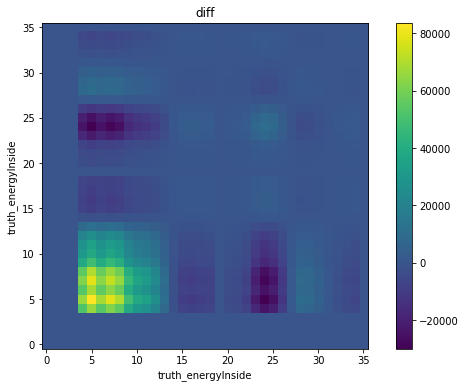

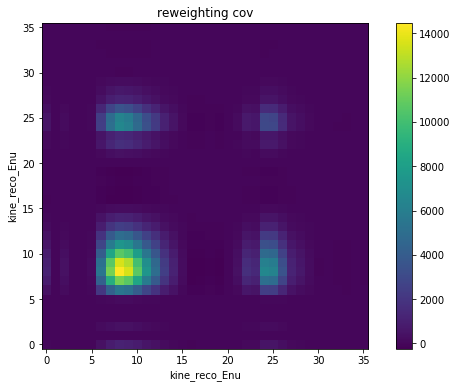

90.11716371058628
11.59716526538053


In [309]:
#add constrained and do the full reweighting to remake truth_bined
#calculate this addtional uncertainty
diff = [[0]*nbins_truth_plot for _ in range(nbins_truth_plot)]

if 0: #may need to adjust this
    tsig_binedNp = [const_ncdelta_true_all*trueNp_frac]
    tsig_bined0p = [const_ncdelta_true_all*true0p_frac]
    tsig_bined = np.concatenate((tsig_binedNp,[0],tsig_bined0p,[0],sig_c))
    
    retsig_binedNp = [const_ncdelta_true_all*trueNp_frac + (const_ncdelta_recoNp_true*recoNp_trueNp_frac*ncdelta_scaling[0] - const_ncdelta_recoNp_true*recoNp_trueNp_frac) + (const_ncdelta_reco0p_true*reco0p_trueNp_frac*ncdelta_scaling[2] - const_ncdelta_reco0p_true*reco0p_trueNp_frac)]
    retsig_bined0p = [const_ncdelta_true_all*true0p_frac + (const_ncdelta_reco0p_true*reco0p_true0p_frac*ncdelta_scaling[2] - const_ncdelta_reco0p_true*reco0p_true0p_frac) + (const_ncdelta_recoNp_true*recoNp_true0p_frac*ncdelta_scaling[0] - const_ncdelta_recoNp_true*recoNp_true0p_frac)]
    #retsig_bined = np.concatenate((retsig_binedNp,[0],retsig_bined0p,[0],resig_c))
    tsig_bined = np.concatenate((retsig_binedNp,[0],retsig_bined0p,[0], [x*y for x,y in zip(truth_sig_bined,re_pi0)])) #just a hck , works unless binning changes
    
    
else:
    tsig_binedNp, _ = np.histogram(df_sig_ncdelta.query(truthNp_query)[s_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_ncdelta.query(truthNp_query)["net_weight"].to_numpy())
    tsig_bined0p, _ = np.histogram(df_sig_ncdelta.query(truth0p_query)[s_variable].to_numpy(), bins=ncdelta_range, weights=df_sig_ncdelta.query(truth0p_query)["net_weight"].to_numpy())
    tsig_bined = np.concatenate((tsig_binedNp,[0],tsig_bined0p,[0],truth_sig_bined))

    if Xp_truth: len_bin_re = (re_max-re_min)/nbins_re
    else: #Np0p for truth
        len_bin_re_Np = (re_max_Np-re_min_Np)/nbins_re_Np
        len_bin_re_0p = (re_max_0p-re_min_0p)/nbins_re_0p
    
    #ned to add np and overflow
    wall_df = all_df.copy()
    weight = wall_df["net_weight"].to_numpy()
    truth_isCC = wall_df["truth_isCC"].to_numpy()
    truth_NprimPio = wall_df["truth_NprimPio"].to_numpy()
    tnump =  wall_df["true_protons"].to_numpy()
    pE = wall_df["truth_max_p_energy"].to_numpy()
    w = wall_df[s_variable].to_numpy()
    for event in range(len(weight)):
        if truth_isCC[event]==0 and truth_NprimPio[event]>0:
            #if math.isnan(w[event]): continue
            if re_Xp_truth:
                if w[event]<re_min:
                    if re_underflow: truth_bin = 0 
                    else: continue
                elif w[event]>re_max:
                    if re_overflow: truth_bin = -1
                    else: continue
                else: truth_bin = int(re_underflow+(w[event]-re_min)//len_bin_re)
            else: #N0p
                if tnump[event]>0 and pE[event]>35:#Np
                    if w[event]<re_min_Np:
                        if re_underflow: truth_bin=0
                        else: continue 
                    elif w[event]>re_max_Np:
                        if re_overflow: truth_bin = nbins_re_Np+re_underflow
                        else: continue
                    else: truth_bin = int(re_underflow+(w[event]-re_min_Np)//len_bin_re_Np)               
                else:#0p 
                    if w[event]<re_min_0p:
                        if re_underflow: truth_bin = nbins_re_Np+re_underflow+re_overflow
                        else: continue
                    elif w[event]>re_max_0p:
                        if re_overflow: truth_bin = -1
                        else: continue
                    else: truth_bin = int(2*re_underflow+re_overflow+nbins_re_Np+(w[event]-re_min_0p)//len_bin_re_0p)
            weight[event] = weight[event] * re_pi0[int(truth_bin)]

    if scale_ncdelta: 
        reco_protons = wall_df["num_proton"].to_numpy(copy=True)
        nc_delta_score = wall_df["nc_delta_score"].to_numpy(copy=True)
        reco_showerKE = wall_df["reco_showerKE"].to_numpy(copy=True)
        for i in range(len(weight)):
            if reco_showerKE[i]>0 and nc_delta_score[i] > 2.61 and truth_isCC[i]==0:
                if reco_protons[i]>0: weight[i]*ncdelta_scaling[0]#should add scaling for overflow
                elif reco_protons[i]==0: weight[i]*ncdelta_scaling[2]


    wall_df["net_weight"] = weight
    wall_df=wall_df.replace(np.nan, 0)
                            
    retsig_binedNp_ncdelta, _ = np.histogram(wall_df.query(sig_query_ncdelta).query(truthNp_query)[s_variable].to_numpy(), bins=ncdelta_range, weights=wall_df.query(sig_query_ncdelta).query(truthNp_query)["net_weight"].to_numpy())
    retsig_bined0p_ncdelta, _ = np.histogram(wall_df.query(sig_query_ncdelta).query(truth0p_query)[s_variable].to_numpy(), bins=ncdelta_range, weights=wall_df.query(sig_query_ncdelta).query(truth0p_query)["net_weight"].to_numpy())
    retsig_binedNp, _ = np.histogram(wall_df.query(sig_query).query(truthNp_query)[s_variable].to_numpy(), bins=b_truth_Np, weights=wall_df.query(sig_query).query(truthNp_query)["net_weight"].to_numpy())
    retsig_bined0p, _ = np.histogram(wall_df.query(sig_query).query(truth0p_query)[s_variable].to_numpy(), bins=b_truth_0p, weights=wall_df.query(sig_query).query(truth0p_query)["net_weight"].to_numpy())
    retsig_bined = np.concatenate((retsig_binedNp_ncdelta,[0],retsig_bined0p_ncdelta,[0],retsig_binedNp,retsig_bined0p))

    
        
if correlated:
    for i in range(nbins_truth_plot):
        for j in range(nbins_truth_plot):
            diff[i][j] = (retsig_bined[i] - tsig_bined[i])*(retsig_bined[j] - tsig_bined[j])
else:
    for i in range(nbins_truth_plot):
        diff[i][i] = (retsig_bined[i] - tsig_bined[i])**2
        
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(diff, origin='lower')
cbar = plt.colorbar(im, label='')
ax.set(xlabel=f"{s_variable}", ylabel=f"{s_variable}")
plt.title("diff")
plt.show()
    
new_cov = np.matmul(np.matmul(R,diff),R.T)

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(new_cov, origin='lower')
cbar = plt.colorbar(im, label='')
ax.set(xlabel=f"{m_variable}", ylabel=f"{m_variable}")
plt.title("reweighting cov")
plt.show()

print(new_cov[0][0])
print(new_cov[2][2])

with uproot.recreate("reweight_cov.root") as file:

    file["R"] = uproot.newtree({"R": np.double})
    file["R"].extend({"R": R.flatten()})
    file["diff"] = uproot.newtree({"diff": np.double})
    file["diff"].extend({"diff": np.array(diff).flatten()})
    file["new_cov"] = uproot.newtree({"new_cov": np.double})
    file["new_cov"].extend({"new_cov": new_cov.flatten()})

In [42]:
num_cat = 5
categories = [None] * num_cat
queries = [None] * num_cat
colors = [None] * num_cat

#origional 1
categories[0] = ["NC Delta radiative", "NC 1 Pi0", "numuCC 1 Pi0", "nueCC", "numuCC other", "NC other", "outFV", "badmatch/cosmic", "dirt", "ext"]

queries[0] = [
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NCDelta==1",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NprimPio==1 and not (truth_NCDelta==1)",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==1 and abs(truth_nuPdg)==14 and truth_NprimPio==1",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==1 and abs(truth_nuPdg)==12",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==1 and abs(truth_nuPdg)==14 and truth_NprimPio!=1",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NprimPio!=1 and not (truth_NCDelta==1)",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and not (truth_vtxInside==1)",
    "not (isDirt==1) and not (isEXT==1) and not (match_completeness_energy/truth_energyInside>=0.1)",
    "isDirt==1",
    "isEXT==1",
]

colors[0] = [
    "yellow",
    "tomato",
    "royalblue",
    "orchid",
    "orange",
    "pink",
    "cyan",
    "turquoise",
    "brown",
    "limegreen"
]

sig_query = "not (isEXT==1) and not (isDirt==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NCDelta==1"
bkg_query = f"not ({sig_query})"

signal_string = "NC Delta Radiative"

In [43]:
#origional 2
categories[1] = ["NC Delta radiative 1g >=1(p,pi0,pi+/-)", "NC Delta radiative 1g 0(p,pi0,pi+/-)", "NC 1 Pi0", "numuCC 1 Pi0", "nueCC", "numuCC other", "NC other", "outFV", "badmatch/cosmic", "dirt", "ext"]

queries[1] = [
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NCDelta==1 and not(num_prim_protons==0 and num_prim_pi0s==0 and num_prim_charged_pions==0)",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NCDelta==1 and num_prim_protons==0 and num_prim_pi0s==0 and num_prim_charged_pions==0",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NprimPio==1 and not (truth_NCDelta==1)",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==1 and abs(truth_nuPdg)==14 and truth_NprimPio==1",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==1 and abs(truth_nuPdg)==12",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==1 and abs(truth_nuPdg)==14 and truth_NprimPio!=1",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NprimPio!=1 and not (truth_NCDelta==1)",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and not (truth_vtxInside==1)",
    "not (isDirt==1) and not (isEXT==1) and not (match_completeness_energy/truth_energyInside>=0.1)",
    "isDirt==1",
    "isEXT==1",
]

colors[1] = [
    "yellow",
    "grey",
    "tomato",
    "royalblue",
    "orchid",
    "orange",
    "pink",
    "cyan",
    "turquoise",
    "brown",
    "limegreen"
]

sig_query = "not (isEXT==1) and not (isDirt==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NCDelta==1"
bkg_query = f"not ({sig_query})"

signal_string = "NC Delta Radiative"

In [44]:
#This is the one I have been using to creat plots based on Truth_NuIntType
categories[2] = ["NC Delta radiative", 
              "NC 1 pi0 kREsNCNuProtonPi0", 
              "NC 1 pi0 kREsNCNuNuetronPi0", 
              "CC nuetron+pi0", 
              "NC pi+-", 
              "CC pi+", 
              "NC DIS", 
              "CC DIS", 
              "COH", 
              "QE", 
              "other", 
              "outFV", 
              "badmatch/cosmic", 
              "dirt", 
              "ext"
]


queries[2] = [
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_NCDelta==1",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and not (truth_NCDelta==1) and truth_NprimPio==1 and (truth_nuIntType==1006 or truth_nuIntType==1013) ",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and not (truth_NCDelta==1) and truth_NprimPio==1 and (truth_nuIntType==1008 or truth_nuIntType==1015) ",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and not (truth_NCDelta==1) and truth_NprimPio==1 and truth_nuIntType==1004",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and not (truth_NCDelta==1) and (truth_nuIntType==1007 or truth_nuIntType==1009 or truth_nuIntType==1014 or truth_nuIntType==1016)",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and not (truth_NCDelta==1) and (truth_nuIntType==1003 or truth_nuIntType==1005)",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and not (truth_NCDelta==1) and truth_nuIntType==1092",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and not (truth_NCDelta==1) and truth_nuIntType==1091",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and not (truth_NCDelta==1) and (truth_nuIntType==1096 or truth_nuIntType==1097)",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and not (truth_NCDelta==1) and (truth_nuIntType==1001 or truth_nuIntType==1002)",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_NprimPio==1 and not (truth_NCDelta==1) and not (truth_nuIntType==1001 or truth_nuIntType==1002 or truth_nuIntType==1003 or truth_nuIntType==1004 or truth_nuIntType==1005 or truth_nuIntType==1006 or truth_nuIntType==1007 or truth_nuIntType==1008 or truth_nuIntType==1009 or truth_nuIntType==1013 or truth_nuIntType==1014 or truth_nuIntType==1015 or truth_nuIntType==1016 or truth_nuIntType==1091 or truth_nuIntType==1092 or truth_nuIntType==1096 or truth_nuIntType==1097)",    
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and not (truth_vtxInside==1)",
    "not (isDirt==1) and not (isEXT==1) and not (match_completeness_energy/truth_energyInside>=0.1)",
    "isDirt==1",
    "isEXT==1",
]

colors[2] = [
    "yellow",
    "blue",
    "lightblue",
    "orange",
    "red",
    "tomato",
    "purple",
    "pink",
    "black",
    "grey",
    "tan",
    "cyan",
    "turquoise",
    "brown",
    "limegreen",
]
print(colors[1])

['yellow', 'grey', 'tomato', 'royalblue', 'orchid', 'orange', 'pink', 'cyan', 'turquoise', 'brown', 'limegreen']


In [45]:
#enrgy or p/pi
categories[3] = ["NC Delta 1gN(p>35Mev, pi0,pi+/->10Mev)", "NC Delta 1g0(p>35Mev, pi0,pi+/->10Mev)", "NC 1 Pi0", "numuCC 1 Pi0", "nueCC", "numuCC other", "NC other", "outFV", "badmatch/cosmic", "dirt", "ext"]

queries[3] = [
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NCDelta==1 and (truth_max_p_energy>35 or truth_max_pi_energy>35)",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NCDelta==1 and truth_max_p_energy<=35 and truth_max_pi_energy<=35",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NprimPio==1 and not (truth_NCDelta==1)",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==1 and abs(truth_nuPdg)==14 and truth_NprimPio==1",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==1 and abs(truth_nuPdg)==12",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==1 and abs(truth_nuPdg)==14 and truth_NprimPio!=1",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NprimPio!=1 and not (truth_NCDelta==1)",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and not (truth_vtxInside==1)",
    "not (isDirt==1) and not (isEXT==1) and not (match_completeness_energy/truth_energyInside>=0.1)",
    "isDirt==1",
    "isEXT==1",
]

colors[3] = [
    "yellow",
    "grey",
    "tomato",
    "royalblue",
    "orchid",
    "orange",
    "pink",
    "cyan",
    "turquoise",
    "brown",
    "limegreen"
]

sig_query = "not (isEXT==1) and not (isDirt==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NCDelta==1"
bkg_query = f"not ({sig_query})"

signal_string = "NC Delta Radiative"

In [46]:
complete_all_df = all_df.query("net_weight > 0") # getting rid of events with no weight, which will happen if we're excluding run 2 MC for example
complete_data_all_df = data_all_df.query("match_isFC != 0.") # should be everything, just making a copy
all_df = all_df.query("net_weight > 0") # getting rid of events with no weight, which will happen if we're excluding run 2 MC for example
data_all_df = data_all_df.query("match_isFC != 0.") # should be everything, just making a copy

In [47]:
#enrgy or p/pi
categories[4] = ["NC Pi0", "CC Pi0", "nu_mu bckg", "nu_e bckg", "outFV", "badmatch/cosmic", "dirt", "ext"]

queries[4] = [
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NprimPio>0",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==1 and truth_NprimPio>0",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_NprimPio==0 and abs(truth_nuPdg)==14",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_NprimPio==0 and abs(truth_nuPdg)==12",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and not (truth_vtxInside==1)",
    "not (isDirt==1) and not (isEXT==1) and not (match_completeness_energy/truth_energyInside>=0.1)",
    "isDirt==1",
    "isEXT==1",
]

colors[4] = [
    "purple",
    "pink",
    "tomato",
    "orange",
    "cyan",
    "turquoise",
    "brown",
    "limegreen"
]

sig_query = "not (isEXT==1) and not (isDirt==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NCDelta==1"
bkg_query = f"not ({sig_query})"

signal_string = "NC Delta Radiative"

In [57]:
#enrgy or p/pi
categories[5] = ["overlay", "dirt", "ext"]

queries[5] = [
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NprimPio>0",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==1 and truth_NprimPio>0",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_NprimPio==0 and abs(truth_nuPdg)==14",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_NprimPio==0 and abs(truth_nuPdg)==12",
    "not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and not (truth_vtxInside==1)",
    "not (isDirt==1) and not (isEXT==1) and not (match_completeness_energy/truth_energyInside>=0.1)",
    "isDirt==1",
    "isEXT==1",
]

colors[5] = [
    "purple",
    "pink",
    "tomato",
    "orange",
    "cyan",
    "turquoise",
    "brown",
    "limegreen"
]

sig_query = "not (isEXT==1) and not (isDirt==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NCDelta==1"
bkg_query = f"not ({sig_query})"

signal_string = "NC Delta Radiative"

IndexError: list assignment index out of range

In [48]:
# these also use the global open_data, run1_to_3_pred_only, open_data_new_file, numi_data, fake_data_5, fake_data_7

# and the global variables: queries, colors, categories

plt.rcParams.update({'font.size': 12})

def make_histograms(df, data_df, sel, x_variables, cat, include_nc_delta_model=False, include_nc_delta_0p_model=False, extra_name=None):
    # cutting to selection channel
    
    inclusive_cut = 2.61
    n_track_cut = 2.5
    zero_track_cut = 2.5
    nc_pio_cut = 1.816
    #nc_pio_cut = 1.68
    
    if sel == "1gNp":
        selected_query = f"nc_delta_score > {inclusive_cut} and reco_showerKE > 0 and num_proton >= 1"
    elif sel == "1g0p":
        selected_query = f"nc_delta_score > {inclusive_cut} and reco_showerKE > 0 and num_proton == 0"

    
    elif sel == "1gNtrack":
        selected_query = f"nc_delta_ntrack_score > {n_track_cut} and nc_delta_ntrack_score > nc_delta_0track_score and reco_showerKE > 0"        
    elif sel == "1g0track":
        selected_query = f"nc_delta_0track_score > {zero_track_cut} and nc_delta_0track_score > nc_delta_ntrack_score and reco_showerKE > 0" 

        
    elif sel == "NC_Pi0_Np":
        selected_query = f"nc_pio_score > {nc_pio_cut} and reco_showerKE > 0 and num_proton >= 1  and match_isFC==1 and kine_pio_mass>0"
    elif sel == "NC_Pi0_0p":
        selected_query = f"nc_pio_score > {nc_pio_cut} and reco_showerKE > 0 and num_proton == 0  and match_isFC==1 and kine_pio_mass>0"
    elif sel == "NC_Pi0":
        selected_query = f"nc_pio_score > {nc_pio_cut} and match_isFC==1 and kine_pio_mass>0"
    elif sel == "Pio_flag":
        selected_query = f"kine_pio_flag>0 and reco_showerKE>0"
    elif sel == "NC_Pi0_Pio_flag":
        selected_query = f"kine_pio_flag>0 and reco_showerKE>0 and nc_pio_score > {nc_pio_cut}"

        
        
        
    elif sel == "simpCC_Pi0":
        selected_query = f"kine_pio_flag>0 and kine_pio_mass>0 and nc_pio_score < {nc_pio_cut}"
    elif sel == "modCC_Pi0":
        selected_query = f"kine_pio_flag>0 and kine_pio_vtx_dis < 9  and kine_pio_energy_1 > 40 and kine_pio_energy_2 > 25 and kine_pio_dis_1 < 110 and kine_pio_dis_2 < 120 and kine_pio_angle > 0 and kine_pio_angle < 174  and kine_pio_mass > 22 and kine_pio_mass < 300 and nc_pio_score < {nc_pio_cut}"   
    elif sel == "modNC_Pi0":
        selected_query = f"kine_pio_flag>0 and kine_pio_vtx_dis < 9  and kine_pio_energy_1 > 40 and kine_pio_energy_2 > 25 and kine_pio_dis_1 < 110 and kine_pio_dis_2 < 120 and kine_pio_angle > 0 and kine_pio_angle < 174  and kine_pio_mass > 22 and kine_pio_mass < 300 and nc_pio_score > {nc_pio_cut}"   
    elif sel == "mod_Pi0":
        selected_query = f"kine_pio_flag>0 and kine_pio_vtx_dis < 9  and kine_pio_energy_1 > 40 and kine_pio_energy_2 > 25 and kine_pio_dis_1 < 110 and kine_pio_dis_2 < 120 and kine_pio_angle > 0 and kine_pio_angle < 174  and kine_pio_mass > 22 and kine_pio_mass < 300"


    elif sel == "NC_Pi0_NRG":
        selected_query = f"reco_showerKE>80 and nc_pio_score > {nc_pio_cut}"
    elif sel == "NC_Pi0_NRG2":
        selected_query = f"kine_pio_energy_1>35 and kine_pio_energy_2>35 and nc_pio_score > {nc_pio_cut}"
    elif sel == "NC_Pi0_mass":
        selected_query = f"kine_pio_mass>0 and nc_pio_score > {nc_pio_cut}"
        
    
    selected_data_df = data_df.query(selected_query).copy()
    selected_all_df = df.query(selected_query).copy()
    selected_data_df = selected_data_df.replace(np.nan, 0)
    selected_all_df = selected_all_df.replace(np.nan, 0)
    
    # setting x axis bins
    
    for x_variable in x_variables:
        x_variable_original_name = x_variable
        if x_variable == "reco_showerKE":
            bin_edges = np.linspace(0., 1200., 13)
        elif x_variable == "reco_showerKE_one_bin":
            bin_edges = [0, 1200.]
            x_variable = "reco_showerKE"
        elif x_variable == "reco_showerKE_gLEE_1g0p_bins":
            bin_edges = [100., 200., 250., 300., 350., 400., 450., 500., 550., 600., 700.]
            x_variable = "reco_showerKE"
        elif x_variable == "reco_showerKE_gLEE_1g1p_bins":
            bin_edges = [0., 100., 200., 300., 400., 500., 600.]
            x_variable = "reco_showerKE"
        elif x_variable == "kine_reco_Enu":
            bin_edges = np.linspace(0., 1500, 16)
        elif x_variable == "reco_nuvtxX":
            bin_edges = np.linspace(0., 260., 14)
        elif x_variable == "reco_nuvtxY":
            bin_edges = np.linspace(-120., 120., 13)
        elif x_variable == "reco_nuvtxZ":
            bin_edges = np.linspace(0., 1050., 14)
        elif x_variable == "reco_showervtxX":
            bin_edges = np.linspace(0., 260., 14)
        elif x_variable == "reco_showervtxY":
            bin_edges = np.linspace(-120., 120., 13)
        elif x_variable == "reco_showervtxZ":
            bin_edges = np.linspace(0., 1050., 14)
        elif x_variable == "reco_nu_vtx_reco_shwr_vtx_diff":
            bin_edges = [0] + list(np.logspace(-1., math.log10(10000.), 10))
        elif x_variable == "E_nu_QE":
            bin_edges = np.linspace(0., 1000., 11)
        elif x_variable == "median_dQ_dx":
            bin_edges = np.linspace(0., 0.0001, 11)
        elif x_variable == "median_dE_dx":
            bin_edges = np.linspace(0., 8., 9)
        elif x_variable == "mip_angle_beam":
            bin_edges = np.linspace(0., 180., 10)
        elif x_variable == "spt_angle_vertical":
            bin_edges = np.linspace(0., 180., 9)
        elif x_variable == "proton_theta":
            bin_edges = np.linspace(0., 180., 9)
        elif x_variable == "proton_phi":
            bin_edges = np.linspace(-180., 180., 9)
        elif x_variable == "shower_theta":
            bin_edges = np.linspace(0., 180., 9)
        elif x_variable == "shower_phi":
            bin_edges = np.linspace(-180., 180., 9)
        elif x_variable == "num_proton":
            bin_edges = np.linspace(0., 5., 6)
        elif x_variable == "num_other_tracks":
            bin_edges = np.linspace(0., 5., 6)
        elif x_variable == "shower_costheta":
            bin_edges = np.linspace(-1., 1., 13)
        elif x_variable == "nue_score":
            bin_edges = np.linspace(-20., 14., 10)
        elif x_variable == "nc_delta_score":
            bin_edges = np.linspace(1, 9, 40)
        elif x_variable == "nc_delta_ntrack_score":
            bin_edges = np.linspace(-20., 14., 10)
        elif x_variable == "nc_delta_0track_score":
            bin_edges = np.linspace(-20., 14., 10)
        elif x_variable == "numu_score":
            bin_edges = np.linspace(-3., 2., 10)    
        elif x_variable == "nc_pio_score":
            bin_edges = np.linspace(-3., 6., 10) 
        elif x_variable == "inwardness_2d":
            bin_edges = np.linspace(-1., 1., 11)    
        elif x_variable == "inwardness_3d":
            bin_edges = np.linspace(-1., 1., 11)  
        elif x_variable == "invariant_mass":
            bin_edges = np.linspace(500., 2000., 11)
        elif x_variable == "proton_photon_angle":
            bin_edges = np.linspace(0., 180., 9)
        elif x_variable == "proton_energy":
            bin_edges = np.linspace(0., 2000., 11)
        elif x_variable == "distance_to_boundary":
            bin_edges = np.linspace(0., 130., 11)
        elif x_variable == "pio_mom":
            bin_edges = np.linspace(0., 1200., 24)
        elif x_variable == "pio_mom2":
            bin_edges = np.linspace(0., 1200., 24)
        elif x_variable == "pio_KE":
            bin_edges = np.linspace(0., 800., 16)
        elif x_variable == "pio_E":
            bin_edges = np.linspace(100., 1000., 20)
        elif x_variable == "kine_pio_mass":
            bin_edges = np.linspace(0., 500., 25) 
        elif x_variable == "kine_pio_angle":
            bin_edges = np.linspace(0, 180, 12) 
        elif x_variable == "nonpio_E":
            bin_edges = np.linspace(-500., 1500., 20)
        elif x_variable == "frac_pioE":
            bin_edges = np.linspace(0, 1., 20)
        elif x_variable == "frac_pioE2":
            bin_edges = np.linspace(0, 1., 20)
        elif x_variable == "nonpio_E":
            bin_edges = np.linspace(0, 1000, 20)
        elif x_variable == "nonpio_E2":
            bin_edges = np.linspace(0, 1000, 20)
        else:
            bin_edges = [-1e6, 1e6]
        bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2. for i in range(len(bin_edges) - 1)]
        num_bins = len(bin_edges) - 1
        
        
        # getting data points
        
        data_points, bin_edges_ = np.histogram(data_df.query(selected_query)[x_variable], bins=bin_edges)
        data_xerr = [(bin_edges[i + 1] - bin_edges[i]) / 2. for i in range(len(bin_edges) - 1)]
        data_yerr = [np.sqrt(x) for x in data_points]


        # picking out specific backgrounds from the selected events   

        selected_e_categories = []
        selected_w_categories = []
        for q in queries[cat]:
            selected_e_categories.append(selected_all_df.query(q)[x_variable].to_numpy())
            selected_w_categories.append(selected_all_df.query(q)["net_weight"].to_numpy())

        
        # finding total prediction
            
        total_counts = []
        total_counts_unweighted = []
        for i in range(len(selected_e_categories)):
            hist_, bin_edges_ = np.histogram(selected_e_categories[i], bins=1, range=(bin_edges[0], bin_edges[-1]), weights=selected_w_categories[i])
            total_counts.append(hist_[0])
            hist_, bin_edges_ = np.histogram(selected_e_categories[i], bins=1, range=(bin_edges[0], bin_edges[-1]))
            total_counts_unweighted.append(hist_[0])

        legend_strings = [categories[cat][i] + ", " + str(np.round(total_counts[i], 3)) + " (" + str(total_counts_unweighted[i]) + ")" for i in range(len(categories[cat]))]

        
        # plotting
        
        plt.clf()
        plt.figure(dpi=200, figsize=(10,7))
        plt.plot([], [], " ", label="total prediction: " + str(np.round(np.sum(total_counts), 4)))
        # plotting prediction categories
        n_, bins_, patches_ = plt.hist(selected_e_categories, bins=bin_edges, weights=selected_w_categories, color=colors[cat], label=legend_strings, stacked=True)
        
        
        # plotting LEE models
        
        if include_nc_delta_model:
                    
            nc_delta_total_e = np.append(selected_e_categories[0], selected_e_categories[1])
            nc_delta_total_weights = np.append(selected_w_categories[0], selected_w_categories[1])

            nc_delta_model_counts, bin_edges_ = np.histogram(nc_delta_total_e, weights=nc_delta_total_weights * (nc_delta_LEE_model_factor - 1), bins=bin_edges)
            
            plt.hist(bin_centers, weights = n_[-1] + nc_delta_model_counts, bins=bin_edges, 
                     histtype="step", linestyle="dashed", linewidth=2, color="orange",
                     label=f"{round(nc_delta_LEE_model_factor, 3)}x NC Delta, {round(np.sum(nc_delta_model_counts), 3)} excess")

        if include_nc_delta_0p_model:
            
            nc_delta_0p_e = selected_e_categories[1]
            nc_delta_0p_weights = selected_w_categories[1]
            zero_p_model_counts, bin_edges_ = np.histogram(nc_delta_0p_e, weights=nc_delta_0p_weights * (zero_p_LEE_model_factor - 1), bins=bin_edges)

            plt.hist(bin_centers, weights = n_[-1] + zero_p_model_counts, bins=bin_edges, 
                     histtype="step", linestyle="dotted", linewidth=2, color="green",
                     label=f"{round(zero_p_LEE_model_factor, 3)}x NC Delta 1g 0(p,pi0,pi+/-), {round(np.sum(zero_p_model_counts), 3)} excess")


        if not run1_to_3_pred_only: # should plot data points
            
            plt.errorbar(bin_centers, data_points, yerr=data_yerr, xerr=data_xerr, fmt="none", capsize=5, c="black", zorder=10)
            
            if open_data_new_file:
                plt.scatter(bin_centers, data_points, label=f"4.516e19 BNB open data, {np.sum(data_points)}", color="black", zorder=10)
            elif run1_to_3_pred_only:
                plt.scatter(bin_centers, [0 for x in data_points], label=f"6.369e20 POT BNB prediction", color="black", zorder=10)
            elif all_data:
                plt.scatter(bin_centers, data_points, label=f"6.369e20 POT BNB prediction", color="black", zorder=10)
            elif open_data and (sel == "1gNp_run1" or sel == "1g0p_run1"):
                plt.scatter(bin_centers, data_points, label=f"4.427e19 run 1 BNB open data, {np.sum(data_points)}", color="black", zorder=10)
            elif open_data and (sel == "1gNp_run3" or sel == "1g0p_run3"):
                plt.scatter(bin_centers, data_points, label=f"9.000e18 run 3 BNB open data, {np.sum(data_points)}", color="black", zorder=10)        
            elif open_data:
                plt.scatter(bin_centers, data_points, label=f"5.327e19 BNB open data, {np.sum(data_points)}", color="black", zorder=10)
            elif fake_data_5:
                plt.scatter(bin_centers, data_points, label=f"7.243e20 fake data set 5, {np.sum(data_points)}", color="black", zorder=10)
            elif fake_data_7:
                plt.scatter(bin_centers, data_points, label=f"3.842e20 fake data set 7, {np.sum(data_points)}", color="black", zorder=10)
            elif numi_data:
                plt.scatter(bin_centers, data_points, label=f"2.099e20 numi run1 FHC data, {np.sum(data_points)}", color="black", zorder=10)

        
        handles, labels = plt.gca().get_legend_handles_labels()
        
        
        order = np.arange(1, len(categories[cat])+1, dtype=int)
        order = np.append(order,[0])       
        if not run1_to_3_pred_only:
            order = np.append(order, [len(labels) - 1]) # adding the last label, the data
        if include_nc_delta_model and include_nc_delta_0p_model:
            order = np.append(order, [len(categories[cat])+2, len(categories[cat])+3])
        elif include_nc_delta_model or include_nc_delta_0p_model:
            order = np.append(order, [len(categories[cat])+2])  
        
        L = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=10)
        L.set_zorder(20)


        
        pred = [0] * len(n_[0])
        for i in range(len(selected_e_categories)):
            hist_, bin_edges_ = np.histogram(selected_e_categories[i], bins=bin_edges, weights=selected_w_categories[i])
            pred = [a + b for a, b in zip(pred, hist_)]
        #print(pred)
        #print(data_points)
        chisqr = 0
        for p in range(len(pred)):
            if pred[p]>0:
                chisqr = chisqr + ((pred[p] - data_points[p])**2 / pred[p])
        
        
        
        # label x axis
        
        if x_variable == "kine_reco_Enu":
            plt.xlabel("Reconstructed Neutrino Energy (MeV)")
        elif x_variable == "reco_showerKE":
            plt.xlabel("Shower Energy (MeV)")
        elif x_variable == "reco_nuvtxX":
            plt.xlabel("Reconstructed Neutrino Vertex X (cm)")
        elif x_variable == "reco_nuvtxY":
            plt.xlabel("Reconstructed Neutrino Vertex Y (cm)")
        elif x_variable == "reco_nuvtxZ":
            plt.xlabel("Reconstructed Neutrino Vertex Z (cm)")
        elif x_variable == "reco_showervtxX":
            plt.xlabel("Reconstructed shower Vertex X (cm)")
        elif x_variable == "reco_showervtxY":
            plt.xlabel("Reconstructed shower Vertex Y (cm)")
        elif x_variable == "reco_showervtxZ":
            plt.xlabel("Reconstructed Neutrino Vertex Z (cm)")
        elif x_variable == "reco_nu_vtx_reco_shwr_vtx_diff":
            plt.xlabel("Distance Between Reco Neutrino Vertex\nand Reco Shower Vertex (cm)")
            plt.yscale("log")
            plt.xscale('symlog', linthresh=1)
            plt.xlim(0., 10000.)
        elif x_variable == "mip_angle_beam":
            plt.xlabel("shower-beam angle (degrees)")
        elif x_variable == "spt_angle_vertical":
            plt.xlabel("shower-vertical angle (degrees)")
        elif x_variable == "E_nu_QE":
            plt.xlabel("E_nu_QE (MeV)")
        elif x_variable == "median_dE_dx":
            plt.xlabel("Primary Shower Stem Median dE/dx (MeV/cm)")
        elif x_variable == "proton_theta":
            plt.xlabel("Proton Polar Angle (degrees)")
        elif x_variable == "proton_phi":
            plt.xlabel("Proton Azimuthal Angle (degrees)")
        elif x_variable == "num_protons":
            plt.xlabel("Reco Proton Multiplicity\n(35 MeV threshold, primary or non-primary)")
        elif x_variable == "num_other_tracks":
            plt.xlabel("Reco Non-proton Track Multiplicity\n(10 MeV threshold, primary or non-primary)")
        elif x_variable == "shower_costheta":
            plt.xlabel("Primary Shower Cos(theta)")
        elif x_variable == "shower_theta":
            plt.xlabel("Primary Shower theta")
        elif x_variable == "shower_phi":
            plt.xlabel("Primary Shower Phi")
        elif x_variable == "invariant_mass":
            plt.xlabel("photon-proton invariant mass")
        elif x_variable == "proton_photon_angle":
            plt.xlabel("proton-photon opening angle (degrees)")
        elif x_variable == "proton_energy":
            plt.xlabel("Proton Energy (MeV)")
        elif x_variable == "distance_to_boundary":
            plt.xlabel("Distance to Active Volume Boundary (cm)")
        elif x_variable == "pio_mom":
            plt.xlabel("Reconstructed Pi0 momentum (MeV)")
        elif x_variable == "pio_KE":
            plt.xlabel("Reconstructed Pi0 KE (MeV)")
        elif x_variable == "pio_E":
            plt.xlabel("Reconstructed Pi0 Energy (MeV)")
        elif x_variable == "kine_pio_mass":
            plt.xlabel("Reconstructed Pi0 mass (MeV)")  
        elif x_variable == "kine_pio_angle":
            plt.xlabel("kine_pio_angle")  
        elif x_variable == "nonpio_E":
            plt.xlabel("Reconstructed non-Pi0 Energy (MeV)")
        elif x_variable == "fracpio_E":
            plt.xlabel("pioE/reco_Enu")
        elif x_variable == "fracpio_E2":
            plt.xlabel("pioE/reco_Enu")
            
        else:
            plt.xlabel(x_variable)
        
        plt.title(f"{sel} selection: Data/MC={str(np.round(np.sum(data_points)/np.sum(total_counts),2))} chisqr={str(np.round(chisqr,2))}")
        plt.ylabel("count")

        
        
        
        # saving figure
        if extra_name:
            plt.title(f"{sel} selection {extra_name}: Data/MC={str(np.round(np.sum(data_points)/np.sum(total_counts),2))} chisqr={str(np.round(chisqr,2))}")
        
            if fake_data_5:
                plt.savefig(f"C:/Users/Ben/Documents/GradSchool/reweighting/pyplot/fake_data_5_{sel}_{x_variable_original_name}_{cat}_{extra_name}.png")
            elif fake_data_7:
                plt.savefig(f"C:/Users/Ben/Documents/GradSchool/reweighting/pyplot/fake_data_7_{sel}_{x_variable_original_name}_{cat}_{extra_name}.png")
            elif open_data or open_data_new_file or all_data:
                plt.savefig(f"C:/Users/Ben/Documents/GradSchool/reweighting/pyplot/{sel}_{x_variable_original_name}_{cat}_{extra_name}.png")
            elif run1_to_3_pred_only:
                plt.savefig(f"C:/Users/Ben/Documents/GradSchool/reweighting/pyplot/full_pred{sel}_{x_variable_original_name}_{cat}_{extra_name}.png")
            elif numi_data:
                plt.savefig(f"C:/Users/Ben/Documents/GradSchool/reweighting/pyplot/numi_data_{sel}_{x_variable_original_name}_{cat}_{extra_name}.png")
        else:
            if fake_data_5:
                plt.savefig(f"C:/Users/Ben/Documents/GradSchool/reweighting/pyplot/fake_data_5_{sel}_{x_variable_original_name}_{cat}.png")
            elif fake_data_7:
                plt.savefig(f"C:/Users/Ben/Documents/GradSchool/reweighting/pyplot/fake_data_7_{sel}_{x_variable_original_name}_{cat}.png")
            elif open_data or open_data_new_file or all_data:
                plt.savefig(f"C:/Users/Ben/Documents/GradSchool/reweighting/pyplot/{sel}_{x_variable_original_name}_{cat}.png")
            elif run1_to_3_pred_only:
                plt.savefig(f"C:/Users/Ben/Documents/GradSchool/reweighting/pyplot/full_pred{sel}_{x_variable_original_name}_{cat}.png")
            elif numi_data:
                plt.savefig(f"C:/Users/Ben/Documents/GradSchool/reweighting/pyplot/numi_data_{sel}_{x_variable_original_name}_{cat}.png")

        plt.clf()
        

def make_score_distribution(df, sel): # rewrite this here
    pass


def make_2d_energy_angle(df, sel):
    pass

shower_energy_variables = ["reco_showerKE", "reco_showerKE_one_bin"]
other_energy_variables = ["kine_reco_Enu", "E_nu_QE"]
shower_angle_variables = ["shower_costheta","shower_cosphi", "shower_phi", "shower_theta"]
proton_angle_variables = ["proton_theta", "proton_phi", "proton_energy"]
particle_content_variables = ["num_protons", "num_other_tracks"]
vtx_position_variables = ["reco_nuvtxX", "reco_nuvtxY", "reco_nuvtxZ"]
score_variables = ["nue_score", "numu_score", "nc_pio_score"]
inwardness_variables = ["inwardness_3d", "inwardness_2d"]

In [261]:
make_histograms(wall_df, data_all_df, "NC_Pi0_Np", ["kine_reco_Enu"], 4, include_nc_delta_model=False, include_nc_delta_0p_model=False)
make_histograms(wall_df, data_all_df, "NC_Pi0_0p", ["kine_reco_Enu"], 4, include_nc_delta_model=False, include_nc_delta_0p_model=False)
make_histograms(wall_df, data_all_df, "NC_Pi0", ["kine_reco_Enu"], 4, include_nc_delta_model=False, include_nc_delta_0p_model=False)

C:\Users\Ben\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

In [361]:
make_histograms(all_df, data_all_df, "NC_Pi0_Np", ["kine_reco_Enu", "pio_E"], 4, include_nc_delta_model=False, include_nc_delta_0p_model=False)
make_histograms(all_df, data_all_df, "NC_Pi0_0p", ["kine_reco_Enu", "pio_E"], 4, include_nc_delta_model=False, include_nc_delta_0p_model=False)
make_histograms(all_df, data_all_df, "NC_Pi0", ["kine_reco_Enu", "pio_E"], 4, include_nc_delta_model=False, include_nc_delta_0p_model=False)

C:\Users\Ben\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

In [195]:
print(((2.2-1.2)+19.2+(1.7-1.7)+(0.6-0.5)+0)/((2.7-1.2)+26.1+(1.7-1.7)+(0.6-0.5)+0))
print(((18.1-12.3)+55.3+(5.3-5.3)+(1.6-1.3)+(1.3-1.3))/((19.5-12.3)+57.2+(5.3-5.3)+(1.6-1.3)+(1.3-1.3)))

0.7328519855595668
0.9489953632148376


In [211]:
print(((2.1-1.2)+18.1+(1.7-1.7)+(0.5-0.5)+0)/((2.7-1.2)+26.1+(1.7-1.7)+(0.6-0.5)+0))
print(((19.1-12.3)+71.3+(5.3-5.3)+(1.7-1.3)+(1.3-1.3))/((19.5-12.3)+57.2+(5.3-5.3)+(1.6-1.3)+(1.3-1.3)))

0.6859205776173285
1.213292117465224
